<a href="https://colab.research.google.com/github/da03/Residual-EBM/blob/main/REBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Residual Energy-Based Models for Text Generation

This notebook implements the Residual Energy-Based Model as described in [Residual Energy-Based Models for Text Generation](https://openreview.net/pdf?id=B1l4SgHKDH). Note that both data and model (generator+discriminator) are different from the original paper: the goal is just to show how the entire pipeline works, using much less computational resource.

The entire pipeline consists of three steps:

1. Train a base autoregressive language model (generator, or LM, or base LM) $P_{LM}$;

2. Sample from the base LM $P_{LM}$ and dump samples to disk;

3. Train a discriminator to classify real data versus model generations such that $P(x=real) = \text{sigmoid}(-E_\theta (x))$.

After these three steps, the generator and the discriminator defines a joint generative model of text:

$P_{joint}(x) \propto P_{LM}(x) \exp(-E_\theta(x))$

In order to sample from the joint model, we first sample a set of samples from base LM $P_{LM}$, then we resample from this set with probability proportional to $\exp (-E_\theta(x))$. This is summarized in Algorithm 1 in the original paper, and we can prove that as the number of samples from base LM approaches infinity, this sample-resample procedure approaches exact sampling from the joint distribution.

## Setup

First, define some global control flags.

In [ ]:
# Global flags
WORKING_DIR = 'REBMtest'
OVERWRITE_DATA = False
RETRAIN_GENERATOR = False
if OVERWRITE_DATA and (not RETRAIN_GENERATOR):
  print ('Warning: generator should be retrained since data is regenerated!')

RESAMPLE = False
if RETRAIN_GENERATOR and (not RESAMPLE):
  print ('Warning: should be resampled since generator is retrained!')

RETRAIN_PRETRAIN = False
if OVERWRITE_DATA and RETRAIN_PRETRAIN:
  print ('Warning: pretraining should be done again since data is overwritten!')

Next, connect to Google Drive to save intermediate checkpoits/generated data, etc.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os 
working_directory = f'/content/drive/MyDrive/{WORKING_DIR}'
! mkdir -p $working_directory
%cd $working_directory

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/REBMtest


In [ ]:
if not os.path.exists('mingpt'):
  os.system('git clone https://github.com/da03/minGPT.git')
  os.system('cp -r minGPT/mingpt ./')

In [ ]:
import math
import warnings
import copy
import os
import io
import re
import random

import torch
import torch.nn as nn
import torchtext as tt
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from mingpt.trainer import Trainer, TrainerConfig
from mingpt.model import *

We strongly recommend using a GPU instance to run this notebook, otherwise it might take too long to finish.

In [ ]:
# GPU check, make sure to use GPU where available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (device)

cuda


## Data Generation

We construct a synthetic language of arithmetic expressions. To be more precise, we consider the task of adding two 10-digit numbers together. One example from the dataset is shown below:

```
1 0 7 6 0 9 9 7 2 3 + 7 3 8 0 1 6 5 7 2 6 = 0 8 4 5 6 2 6 5 4 4 9
```

The task we use here is language modeling on this dataset. The benefit of using such a task is that we can evaluate the quality of samples from the model by evaluating whether the generated equation is correct, unlike in unconstrained language modeling of natural languages which usually requires human evaluation.

Note that here we use this dataset for unconditional language modeling for simplicity of implementation, although it appears more natural to do conditional language modeling which gives the model a prefix of the left-hand-side of the equation.


In [ ]:
# Generate data
train_file = 'data/train.txt'
val_file = 'data/val.txt'
test_file = 'data/test.txt'
files = [train_file, val_file, test_file]

if not all([os.path.exists(d) for d in files]):
  if not OVERWRITE_DATA:
    print ('rewriting data since it doesn\'t exist!')
    OVERWRITE_DATA = True

if OVERWRITE_DATA:
  numbers = set([])
  np.random.seed(1234)
  num_digits = 10
  dataset_size = 200000
  min_num = 10**(num_digits-1)
  max_num = 10**(num_digits)
  numbers = np.random.randint(min_num, max_num, size=dataset_size)

  numbers = set(numbers)
  numbers = list(numbers)
  
  random.seed(1234)
  random.shuffle(numbers)
  os.system(f'mkdir -p {os.path.dirname(train_file)}')
  with open(f'{train_file}.tmp', 'w') as ftrain:
    with open(f'{val_file}.tmp', 'w') as fval:
      with open(f'{test_file}.tmp', 'w') as ftest:
        for num in numbers[:700]:
          ftest.write(f'{" ".join([c for c in str(num)])}\n')
        for num in numbers[700:1400]:
          fval.write(f'{" ".join([c for c in str(num)])}\n')
        for num in numbers[1400:]:
          ftrain.write(f'{" ".join([c for c in str(num)])}\n')

  def transform_data(input_file, output_file):
    with open(input_file) as fin:
      with open(output_file, 'w') as fout:
        lines = fin.readlines()
        numbers1 = lines[:(len(lines)//2)]
        numbers2 = lines[(len(lines)//2):]
        for number1, number2 in zip(numbers1, numbers2):
          num1 = int(number1.replace(' ', '').strip())
          num2 = int(number2.replace(' ', '').strip())
          result = num1 + num2
          result = str(result)
          result = ' '.join([i for i in result])
          if True:
            number1 = '%010d' % num1
            number1 = ' '.join([i for i in number1])
            number2 = '%010d' % num2
            number2 = ' '.join([i for i in number2])
            result = int(result.replace(' ', ''))
            result = '%011d' % result
            result = ' '.join([i for i in result])
          fout.write(f'{number1.strip()} + {number2.strip()} = {result}\n')

  transform_data(f'{train_file}.tmp', train_file)
  transform_data(f'{val_file}.tmp',   val_file)
  transform_data(f'{test_file}.tmp',  test_file)

rewriting data since it doesn't exist!


Let's take a look at the data used for language modeling.

In [ ]:
!head data/val.txt

8 9 1 2 8 9 6 0 6 2 + 9 6 6 6 9 6 3 1 6 7 = 1 8 5 7 9 8 5 9 2 2 9
1 0 7 6 0 9 9 7 2 3 + 7 3 8 0 1 6 5 7 2 6 = 0 8 4 5 6 2 6 5 4 4 9
6 0 2 3 2 2 0 3 8 6 + 4 0 1 0 6 0 8 9 5 2 = 1 0 0 3 3 8 2 9 3 3 8
5 1 8 7 3 9 5 3 6 6 + 6 8 5 7 7 9 2 6 0 2 = 1 2 0 4 5 1 8 7 9 6 8
1 1 3 5 6 4 3 5 2 8 + 3 0 8 5 0 1 1 1 1 0 = 0 4 2 2 0 6 5 4 6 3 8
2 6 0 7 0 5 1 3 2 1 + 5 8 2 7 7 9 9 4 7 2 = 0 8 4 3 4 8 5 0 7 9 3
1 4 4 6 0 0 9 3 9 6 + 6 3 4 7 7 3 0 6 7 0 = 0 7 7 9 3 7 4 0 0 6 6
5 6 5 4 5 2 1 5 9 5 + 8 8 1 4 9 7 6 5 0 6 = 1 4 4 6 9 4 9 8 1 0 1
5 7 7 3 9 3 0 8 5 6 + 3 3 4 9 7 7 6 9 5 9 = 0 9 1 2 3 7 0 7 8 1 5
5 1 9 3 2 8 4 5 0 3 + 2 5 5 2 3 7 8 4 9 1 = 0 7 7 4 5 6 6 2 9 9 4


## Data Preprocessing

We use torchtext to load data.

In [ ]:
# adapted from https://github.com/pytorch/text/blob/master/torchtext/legacy/datasets/language_modeling.py
class LanguageModelingDataset(tt.legacy.data.Dataset):
    """Defines a dataset for language modeling."""
    name = 'LM'
    def __init__(self, path, text_field, newline_eos=True,
                 encoding='utf-8', **kwargs):
        """Create a LanguageModelingDataset given a path and a field.
        Args:
            path: Path to the data file.
            text_field: The field that will be used for text data.
            newline_eos: Whether to add an <eos> token for every newline in the
                data file. Default: True.
            encoding: The encoding of the file.
            kwargs: Passed to the constructor of
                data.Dataset.
        """
        fields = [('text', text_field)]
        examples = []
        with io.open(path, encoding=encoding) as f:
            for line in f:
                text = text_field.preprocess(line)
                if newline_eos:
                    text.append(u'<eos>')
                examples.append(tt.legacy.data.Example.fromlist([text], fields))
        super(LanguageModelingDataset, self).__init__(
            examples, fields, **kwargs)

In [ ]:
TEXT = tt.legacy.data.Field(include_lengths=False, # do not include lengths
                    batch_first=False,            # batches will be max_len x batch_size
                    tokenize=lambda x: x.split(), # use split to tokenize
                    init_token="<bos>",           # prepend <bos>
                    eos_token="<eos>"
)

# Make splits for data
train_data, val_data, test_data = LanguageModelingDataset.splits(
    path='./data', root='.', train='train.txt', validation='val.txt', test='test.txt',  
    text_field=TEXT, newline_eos=False,
)

# Build vocabulary
TEXT.build_vocab(train_data.text)

print ("Vocab: ", TEXT.vocab.itos)

Vocab:  ['<unk>', '<pad>', '<bos>', '<eos>', '1', '0', '7', '2', '3', '5', '8', '6', '9', '4', '+', '=']


In [ ]:
BATCH_SIZE = 512
train_iter, val_iter, test_iter = tt.legacy.data.BucketIterator.splits((train_data, val_data, test_data),
                                                     batch_size=BATCH_SIZE, 
                                                     device=device,
                                                     repeat=False, 
                                                     sort_key=lambda x: len(x.text), # sort by length to minimize padding
                                                     sort_within_batch=True)

In [ ]:
batch = next(iter(train_iter))
text = batch.text
print (f"Size of text batch: {text.shape}")
print (f"Third text sentence in batch: {text[:, 2]}")
print (f"Converted back to string: {' '.join([TEXT.vocab.itos[i] for i in text[:, 2]])}")

Size of text batch: torch.Size([35, 512])
Third text sentence in batch: tensor([ 2, 10,  4,  4,  6,  4,  8,  7,  9,  8,  6, 14,  9,  8,  8, 11,  6,  8,
         6,  4, 12,  7, 15,  4,  8, 13,  9,  8, 10, 11, 12,  6,  7, 12,  3],
       device='cuda:0')
Converted back to string: <bos> 8 1 1 7 1 3 2 5 3 7 + 5 3 3 6 7 3 7 1 9 2 = 1 3 4 5 3 8 6 9 7 2 9 <eos>


## Training Base LM (Generator)

We then train a base language model (base LM, or generator) on the dataset. Here we use an LSTM (without attention) as the generator, which cannot solve this task. Note that we can solve this task perfectly using a transformer generator, but for the purpose of illustration we use an LSTM instead.

In [ ]:
class Generator(nn.Module):
  def __init__(self, text_field, embedding_size=64, hidden_size=64, layers=3):
    """
    Initializer. Creates network modules and loss function.
    Arguments:
        text_field: text field
        embedding_size: word embedding size
        hidden_size: hidden layer size of both encoder and decoder
        layers: number of layers of both encoder and decoder
    """
    super(Generator, self).__init__()
    self.text_field = text_field
    
    # Keep the vocabulary size available
    self.V = len(text_field.vocab.itos)
    
    # Get special word ids or tokens
    self.padding_id = text_field.vocab.stoi[text_field.pad_token]
    self.bos_id = text_field.vocab.stoi[text_field.init_token]
    self.eos_id = text_field.vocab.stoi[text_field.eos_token]

    # Keep hyper-parameters available
    self.embedding_size = embedding_size
    self.hidden_size = hidden_size
    self.layers = layers

    # Create essential modules
    self.word_embeddings = nn.Embedding(self.V, embedding_size)

    # RNN cell
    self.rnn = nn.LSTM(
      input_size    = embedding_size,
      hidden_size   = hidden_size,
      num_layers    = layers,
      bidirectional = False
    )

    # Final projection layer
    self.hidden2output = nn.Linear(hidden_size, self.V)

    # Create loss function
    self.loss_function = nn.CrossEntropyLoss(reduction='sum', 
                                             ignore_index=self.padding_id)

  def forward(self, text_in):
    """
    Performs forward computation, returns logits.
    Arguments:
        text_in: decoder input
    """
    # Compute word embeddings
    embeddings = self.word_embeddings(text_in) # tgt_len, bsz, hidden
    # Forward RNN and return all hidden states
    outs, _ = self.rnn(embeddings)
    # Project to get logits
    logits = self.hidden2output(outs) # tgt_len, bsz, V
    return logits

  def forward_incrementally(self, state, text_in):
    """
    Forward the model at `state` for a single step with token `text_in`.
    This function will only be used in the beam search section.
    Arguments:
        state: a tuple (h, c) where h/c is of size (layers, 1, hidden_size)
        text_in: a tensor of size (bsz), tokens for a single step
    Returns:
        `logits`: Log probabilities for `tgt_in` of size (V)
        `state`: updated state, ready for next incremental update
    """
    # Compute word embeddings
    embeddings = self.word_embeddings(text_in.view(1, -1)) # tgt_len, bsz, hidden
    # Forward RNN and return all hidden states
    outs, state = self.rnn(embeddings, state)
    # Project to get logits
    logits = self.hidden2output(outs) # tgt_len, bsz, V
    # Get log probabilities
    logits = torch.log_softmax(logits, -1) # tgt_len, bsz, V
    return logits[0], state

  def evaluate_ppl(self, iterator):
    """Returns the model's perplexity on a given dataset `iterator`."""
    # Switch to eval mode
    self.eval()
    total_loss = 0
    total_words = 0
    for batch in iterator:
      # Input and target
      text = batch.text
      text_in = text[:-1] # remove <eos> for decode input (y_0=<bos>, y_1, y_2)
      text_out = text[1:] # remove <bos> as target        (y_1, y_2, y_3=<eos>)
      # Forward to get logits
      logits = self.forward(text_in)
      # Compute cross entropy loss
      loss = self.loss_function(logits.view(-1, self.V), text_out.view(-1))
      total_loss += loss.item()
      total_words += text_out.ne(self.padding_id).float().sum().item()
    return math.exp(total_loss/total_words)

  def predict(self, bsz, prefix, max_len=33):
    self.eval()
    state = None
    prev_token = torch.LongTensor([self.bos_id]).to(device).view(1, 1).repeat(1, bsz)
    i = 0
    if prefix is not None:
      prev_token = torch.cat([prev_token, prefix], 0)
      i = prefix.size(0)
      feed = prev_token[:-1]
      embeddings = self.word_embeddings(feed) # tgt_len, bsz, hidden
      # Forward RNN and return all hidden states
      _, state = self.rnn(embeddings, state)
      prev_token = prev_token[-1:]

    sample = []
    finished = torch.zeros(bsz).eq(1)
    while i < max_len:
      i += 1
      logits, state = self.forward_incrementally(state, prev_token)
      token = torch.multinomial(logits.exp(), 1).view(-1)
      token[finished] = self.eos_id
      sample.append(token)
      prev_token = token
      finished[token.eq(self.eos_id)] = True
      if finished.all():
        break
    sample = torch.stack(sample, -1)
    if prefix is not None:
      sample = torch.cat([prefix.transpose(0,1), sample], -1)
    samples = []
    for i in range(bsz):
      samples.append(' '.join([self.text_field.vocab.itos[item] for item in sample[i] if item != self.eos_id]))
    return samples

  def train_all(self, train_iter, val_iter, epochs=10, learning_rate=0.001):
    """Train the model."""
    # Switch the module to training mode
    self.train()
    # Use Adam to optimize the parameters
    optim = torch.optim.Adam(self.parameters(), lr=learning_rate)
    best_validation_ppl = float('inf')
    best_model = None
    val_ppls = []
    # Run the optimization for multiple epochs
    for epoch in range(epochs): 
      total_words = 0
      total_loss = 0.0
      for batch in train_iter:
        # Zero the parameter gradients
        self.zero_grad()
        # Input and target
        text = batch.text # text: max_src_length, bsz
        text_in = text[:-1] # Remove <eos> for decode input (y_0=<bos>, y_1, y_2)
        text_out = text[1:] # Remove <bos> as target        (y_1, y_2, y_3=<eos>)
        batch_size = text_in.size(1)
        # Run forward pass and compute loss along the way.
        logits = self.forward(text_in)
        loss = self.loss_function(logits.view(-1, self.V), text_out.view(-1))
        # Training stats
        num_words = text_out.ne(self.padding_id).float().sum().item()
        total_words += num_words
        total_loss += loss.item()
        # Perform backpropagation
        loss.div(batch_size).backward()
        optim.step()

      # Evaluate and track improvements on the validation dataset
      validation_ppl = self.evaluate_ppl(val_iter)
      val_ppls.append(validation_ppl)
      self.train()
      if validation_ppl < best_validation_ppl:
        best_validation_ppl = validation_ppl
        self.best_model = copy.deepcopy(self.state_dict())
      epoch_loss = total_loss / total_words
      print (f'Epoch: {epoch} Training Perplexity: {math.exp(epoch_loss):.4f} '
             f'Validation Perplexity: {validation_ppl:.4f}')
    return val_ppls

Now we train the generator. Note that it takes a very long time since we are training it for 2000 epochs. To reduce the runtime, you can change `EPOCHS` to 200, at the cost of a worse generator.

have to retrain generator since it does not exist!
Epoch: 0 Training Perplexity: 9.0120 Validation Perplexity: 7.7305
Epoch: 1 Training Perplexity: 7.7319 Validation Perplexity: 7.5509
Epoch: 2 Training Perplexity: 7.4912 Validation Perplexity: 7.4430
Epoch: 3 Training Perplexity: 7.4032 Validation Perplexity: 7.3592
Epoch: 4 Training Perplexity: 7.3432 Validation Perplexity: 7.3012
Epoch: 5 Training Perplexity: 7.2923 Validation Perplexity: 7.2753
Epoch: 6 Training Perplexity: 7.2457 Validation Perplexity: 7.2362
Epoch: 7 Training Perplexity: 7.2023 Validation Perplexity: 7.1969
Epoch: 8 Training Perplexity: 7.1676 Validation Perplexity: 7.1518
Epoch: 9 Training Perplexity: 7.1354 Validation Perplexity: 7.1073
Epoch: 10 Training Perplexity: 7.1098 Validation Perplexity: 7.0993
Epoch: 11 Training Perplexity: 7.0834 Validation Perplexity: 7.0626
Epoch: 12 Training Perplexity: 7.0647 Validation Perplexity: 7.0690
Epoch: 13 Training Perplexity: 7.0437 Validation Perplexity: 7.0430
Epoch: 

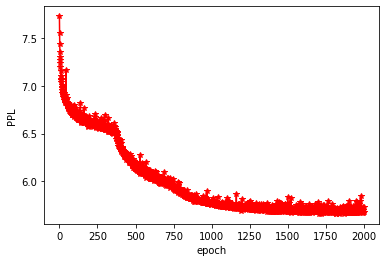

In [ ]:
# Warning: this cell might take an hour to run
generator_path = 'data/generator.pt'

# Instantiate and train classifier
generator = Generator(TEXT,
  embedding_size = 256,
  hidden_size    = 256,
  layers         = 1,
).to(device)

if not os.path.exists(generator_path):
  if not RETRAIN_GENERATOR:
    print ('have to retrain generator since it does not exist!')

if RETRAIN_GENERATOR or (not os.path.exists(generator_path)):
  EPOCHS = 2000 # for faster training, change this to 200
  LEARNING_RATE = 6e-4

  val_ppls = generator.train_all(train_iter, val_iter, epochs=EPOCHS, learning_rate=LEARNING_RATE)
  generator.load_state_dict(generator.best_model)
  
  plt.plot(range(len(val_ppls)), val_ppls, 'r*-')
  plt.xlabel('epoch')
  plt.ylabel('PPL')

  torch.save(generator.state_dict(), generator_path)
else:
  generator.load_state_dict(torch.load(generator_path))

With a trained generator, we can evaluate the quality of the generated samples. We use per-digit accuracy since per-equation accuracy would be too low to be informative.

In [ ]:
# Evaluation Metrics
def num_of_correct(expression):
  expression = expression.replace(' ', '')
  m = re.match(r'(\d+)\+(\d+)=(\d+)', expression)
  if not m:
    print (expression)
    return 0, 0, 0
  a = m.group(1)
  b = m.group(2)
  res = int(a) + int(b)
  res = '%011d' % res
  tot = max(len(res), len(m.group(3)))
  correct_pos = 0
  correct_len = 1 if len(m.group(3)) == len(res) else 0
  for c1, c2 in zip(res, m.group(3)):
    if c1 == c2:
      correct_pos += 1
  return correct_pos / tot, correct_len

In [ ]:
num_samples = 100

total = 0
num_correct_pos = 0.
num_correct_len = 0.
for i in range(num_samples):
  sample = generator.predict(1, None)[0]
  c_pos, c_len = num_of_correct(sample)
  num_correct_pos += c_pos
  num_correct_len += c_len
  total += 1
  sample_orig = sample
  sample = sample.replace(' ', '')
  m = re.match(r'(\d+)\+(\d+)=(\d+)', sample)
  a = int(m.group(1))
  b = int(m.group(2))
  c = a+b
  c = '%011d'%c
  print (sample_orig + ' | ' + ' '.join(c))
print (num_correct_pos/total)
print (num_correct_len/total)

4 2 2 0 0 1 7 0 6 9 + 4 4 4 9 8 7 7 4 0 9 = 0 8 6 6 9 9 2 2 1 9 7 | 0 8 6 6 9 8 9 4 4 7 8
4 7 1 6 6 1 0 6 2 9 + 6 1 3 7 6 5 2 1 9 7 = 1 0 8 5 4 3 0 0 4 2 0 | 1 0 8 5 4 2 6 2 8 2 6
7 8 0 8 9 8 8 6 8 6 + 7 6 2 5 5 3 8 2 4 9 = 1 5 4 3 4 3 9 3 6 2 6 | 1 5 4 3 4 5 2 6 9 3 5
2 9 8 8 4 9 9 5 4 1 + 1 3 0 6 0 1 1 2 5 6 = 0 4 2 9 4 6 3 9 7 8 9 | 0 4 2 9 4 5 1 0 7 9 7
2 5 1 1 0 4 8 4 7 7 + 9 2 5 5 7 9 0 1 3 5 = 1 1 7 6 6 9 0 9 0 6 2 | 1 1 7 6 6 8 3 8 6 1 2
8 1 1 4 0 0 4 2 9 1 + 1 2 5 7 7 6 3 1 7 2 = 0 9 3 7 1 8 0 8 8 8 4 | 0 9 3 7 1 7 6 7 4 6 3
1 3 7 1 6 9 5 7 3 1 + 3 4 1 2 1 8 9 7 1 5 = 0 4 7 8 3 5 3 2 2 0 4 | 0 4 7 8 3 8 8 5 4 4 6
8 9 6 1 4 9 3 1 7 1 + 2 6 3 7 5 2 7 1 1 8 = 1 1 5 9 9 1 3 8 7 9 5 | 1 1 5 9 9 0 2 0 2 8 9
4 4 7 1 4 6 3 5 0 1 + 9 1 5 0 8 8 7 3 8 7 = 1 3 6 2 2 2 7 9 4 3 9 | 1 3 6 2 2 3 5 0 8 8 8
5 2 1 3 5 3 1 9 1 5 + 8 3 9 5 2 6 8 8 0 2 = 1 3 6 0 8 7 4 5 1 8 7 | 1 3 6 0 8 8 0 0 7 1 7
8 6 2 9 1 9 4 4 4 4 + 6 7 2 1 6 6 3 1 1 5 = 1 5 3 5 0 7 0 3 8 6 1 | 1 5 3 5 0 8 5 7 5 5 9
4 1 3 5 6 

## Sampling from Base LM

Now, we sample from the base LM (generator) to prepare the data we need for training the discriminator.

In [ ]:
train_file = f'data/LM_generated/train.txt'
val_file = f'data/LM_generated/val.txt'
test_file = f'data/LM_generated/test.txt'

files = [train_file, val_file, test_file]

if not (all([os.path.exists(f) for f in files])):
  if not RESAMPLE:
    print ('needs to resample data!')

if RESAMPLE or (not (all([os.path.exists(f) for f in files]))):
  if not os.path.exists('data/LM_generated'):
    os.makedirs('data/LM_generated')
  def sample_data(data_iter, fout):
    for batch in tqdm(data_iter):
        bsz = batch.text.size(1)
        sample = generator.predict(bsz, None)
        for s in sample:
          fout.write(s+'\n')

  with open(f'data/LM_generated/train.txt', 'w') as fout:
    sample_data(train_iter, fout)
  with open(f'data/LM_generated/val.txt', 'w') as fout:
    sample_data(val_iter, fout)
  with open(f'data/LM_generated/test.txt', 'w') as fout:
    sample_data(test_iter, fout)

  0%|          | 0/194 [00:00<?, ?it/s]

needs to resample data!


100%|██████████| 1/1 [00:00<00:00,  2.04it/s]


As before, we need to load those generated data using torchtext.

In [ ]:
# Make splits for data
lmgen_train_data, lmgen_val_data, lmgen_test_data = LanguageModelingDataset.splits(
    path='./data/LM_generated', root='.', train='train.txt', validation='val.txt', test='test.txt',  
    text_field=TEXT, newline_eos=False,
)

In [ ]:
lmgen_train_iter, lmgen_val_iter, lmgen_test_iter = tt.legacy.data.BucketIterator.splits(
                                                     (lmgen_train_data, lmgen_val_data, lmgen_test_data),
                                                     batch_size=BATCH_SIZE, 
                                                     device=device,
                                                     repeat=False, 
                                                     sort_key=lambda x: len(x.text), # sort by length to minimize padding
                                                     sort_within_batch=True)

## Training Discriminator

With generated samples (negatives), and the original real data (positives), we can train a discriminator to distinguish real versus fake. The pre-sigmoid outputs of the discriminator will be used as a residual over the log likelihood $\log P_{LM}$ to define a joint model REBM.

We use a bi-directional transformer as our discriminator. Our preliminary experiments using an LSTM-based discriminator will also lead to improvements, but transformers are much faster to train and lead to larger improvements so we ended up using it.

In [ ]:
# train a discriminator
class Discriminator(nn.Module):
  def __init__(self, text_field, hidden_size=128, layers=2, heads=4):
    """
    Initializer. Creates network modules and loss function.
    Arguments:
        text_field: text field
        hidden_size: word embedding size and hidden size
        layers: number of layers
        heads: number of heads
    """
    super(Discriminator, self).__init__()
    self.text_field = text_field
    
    # Keep the vocabulary sizes available
    self.V = len(text_field.vocab.itos)
    
    # Get special word ids or tokens
    self.padding_id = text_field.vocab.stoi[text_field.pad_token]
    self.bos_id = text_field.vocab.stoi[text_field.init_token]
    self.eos_id = text_field.vocab.stoi[text_field.eos_token]

    # Keep hyper-parameters available
    self.hidden_size = hidden_size
    self.layers = layers
    self.heads = heads

    # Final projection layer
    self.hidden2output = nn.Linear(hidden_size, 2)

    # Final projection layer for masked-LM pretraining
    self.hidden2output_pretrain = nn.Linear(hidden_size, self.V)

    self.loss_function = nn.CrossEntropyLoss(reduction='sum')

    self.loss_function_pretrain = nn.CrossEntropyLoss(reduction='sum', ignore_index=0)
    
    mconf = GPTConfig(self.V, 50,
                  n_layer=layers, n_head=heads, n_embd=hidden_size)
    self.model = GPT(mconf)
    def f(m):
      m.causal = False
    self.model.apply(f) # make GPT model use bidirectional attention

  def extract_features(self, text):
    """
    Extract features from `text`.
    Arguments:
        text: text batch of size (max_len, batch_size)
    Returns:
        features of size (max_len, bsz, hidden_size) 
    """
    # Compute word embeddings
    bsz = text.size(1)
    seq_len = text.size(0)

    all_contexts = self.model.extract_features(text.transpose(0, 1))
    all_contexts = all_contexts.transpose(0, 1) # seq_len, bsz, hidden
    return all_contexts

  def forward_pretrain(self, text):
    all_contexts = self.extract_features(text) # seq_len, bsz, hidden
    logits = self.hidden2output_pretrain(all_contexts) # seq_len, bsz, V
    return logits

  def forward(self, text):
    """
    Performs forward computation, returns logits.
    Arguments:
        text: batch of size (max_len, batch_size)
    """
    all_contexts = self.extract_features(text)
    state = all_contexts.mean(0)
    logits = self.hidden2output(state)
    return logits

  def pretrain_all(self, real_train_iter, real_val_iter,
                   epochs=50, learning_rate=6e-4, mask=0.3, accumulate=1, warmup_tokens=1024):
    """Train the model."""
    # Switch the module to training mode
    self.train()
    
    best_validation_loss = float('inf')
    best_model = None

    # initialize a trainer instance and kick off training
    tconf = TrainerConfig(max_epochs=epochs, batch_size=BATCH_SIZE, learning_rate=learning_rate,
                          lr_decay=True, warmup_tokens=warmup_tokens, 
                          final_tokens=50*len(train_data)*(10+1),
                          num_workers=4)
    optim = self.model.configure_optimizers(tconf)
    self.tokens = 0

    # Run the optimization for multiple epochs
    step = -1
    for epoch in range(epochs): 
      total_words = 0
      total_loss = 0.0
      correct_counts = torch.zeros(50).fill_(0).to(device)
      total_counts = torch.zeros(50).fill_(0).to(device)
      for real_batch in real_train_iter:
        step += 1
        # Input and target
        src = real_batch.text # text: max_len, bsz
        tgt = src.data.clone()
        batch_size = src.size(-1)
        seq_len = src.size(0)

        src_mask = src.new(src.size()).float().uniform_() > 0.9
        src[src_mask] = 0 # change to unk
        tgt[~src_mask] = 0 # seqlen, bsz
        total_counts[:seq_len] += src_mask.long().sum(1)
      
        # Run forward pass and compute loss along the way.
        logits = self.forward_pretrain(src).view(-1, self.V) # seqlen*bsz, V
        loss = self.loss_function_pretrain(logits, tgt.view(-1))

        # Training stats
        prediction_correct = logits.view(seq_len, -1, self.V).max(-1)[1] == tgt
        prediction_correct = prediction_correct * src_mask
        correct_counts[:seq_len] += prediction_correct.long().sum(1)
        total_words += (src_mask).long().sum() #+ src2.size(1)
        total_loss += loss.item()

        # Perform backpropagation
        loss.div((tgt >= 0).long().sum()).backward()
        if step % accumulate == 0:
          optim.step()
          self.zero_grad()
        
        self.tokens += (tgt >= 0).sum()/accumulate # number of tokens processed this step (i.e. label is not -100)
        final_tokens=50*len(train_data)*11
        if self.tokens < warmup_tokens:
            # linear warmup
            lr_mult = float(self.tokens) / float(max(1, warmup_tokens))
        else:
            # cosine learning rate decay
            progress = float(self.tokens - warmup_tokens) / float(max(1, final_tokens - warmup_tokens))
            lr_mult = max(0.1, 0.5 * (1.0 + math.cos(math.pi * progress)))
        lr = learning_rate * lr_mult
        for param_group in optim.param_groups:
            param_group['lr'] = lr
      
      # Evaluate and track improvements on the validation dataset
      validation_acc, validation_loss = self.evaluate_pretrain(real_val_iter)
      self.train()
      ratio = correct_counts / total_counts.clamp(min=1)
      ratio = ratio.cpu().tolist()
      plt.figure()
      plt.plot(range(len(ratio)), ratio, 'r*', range(len(ratio)), [0.1]*len(ratio), 'b--')
      plt.xlabel('position')
      plt.ylabel('MLM accuracy')
      plt.show()
      if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        self.best_model = copy.deepcopy(self.state_dict())
      epoch_loss = total_loss / total_words
      print (f'Epoch: {epoch} Pretraining Perplexity: {math.exp(epoch_loss):.4f} '
                f'Validation accuracy: {validation_acc:.4f} '
                f'Validation ppl: {math.exp(validation_loss):.4f} lr: {lr}')

  def evaluate_pretrain(self, real_iterator):
    """Returns the model's perplexity on a given dataset `iterator`."""
    # Switch to eval mode
    self.eval()
    num_correct = 0
    total = 0
    total_loss = 0
    for batch in real_iterator:
      # Input and target
      src = batch.text
      tgt = src.data.clone()

      src_mask = src.new(src.size()).float().uniform_() > 0.9
      src[src_mask] = 0 # change to unk
      tgt[~src_mask] = 0 # seqlen, bsz
     
      # Forward to get logits
      logits = self.forward_pretrain(src).view(-1, self.V)
      _, argmax = logits.max(-1)
      src_mask_flatten = src_mask.view(-1)
      to_predict = argmax[src_mask_flatten]
      to_predict_gt = tgt.view(-1)[src_mask_flatten]
      loss = self.loss_function_pretrain(logits, tgt.view(-1))
      total_loss += loss.item()
      # Compute cross entropy loss
      num_correct += to_predict.eq(to_predict_gt).sum().item()
      # Compute cross entropy loss
      total += (src_mask).long().sum()
    return num_correct/total, total_loss/total

  def evaluate(self, real_iterator, fake_iterator):
    """Returns the model's perplexity on a given dataset `iterator`."""
    # Switch to eval mode
    self.eval()
    num_correct = 0
    total = 0
    total_loss = 0
    for real_batch, fake_batch in zip(real_iterator, fake_iterator):
      real_text = real_batch.text
      fake_text = fake_batch.text

      # Forward to get logits
      real_logits = self.forward(real_text)
      loss = self.loss_function(real_logits, 
                                torch.LongTensor(real_text.size(1)).fill_(0).to(device))
      total_loss += loss.item()
      # Compute cross entropy loss
      num_correct += real_logits[:,0].ge(real_logits[:,1]).float().sum().item()

      fake_logits = self.forward(fake_text)
      loss = self.loss_function(fake_logits, 
                                torch.LongTensor(fake_text.size(1)).fill_(1).to(device))
      total_loss += loss.item()
      num_correct += fake_logits[:,0].le(fake_logits[:,1]).float().sum().item()
      # Compute cross entropy loss
      total += real_text.size(1) + fake_text.size(1)
    return num_correct/total, total_loss/total

  def train_all(self, real_train_iter, fake_train_iter, real_val_iter, fake_val_iter, 
                epochs=50, learning_rate=6e-4, warmup_tokens=1024):
    """Train the model."""
    # Switch the module to training mode
    self.train()
    
    best_validation_loss = float('inf')
    best_model = None
    # initialize a trainer instance and kick off training
    tconf = TrainerConfig(max_epochs=epochs, batch_size=BATCH_SIZE, learning_rate=learning_rate,
                          lr_decay=True, warmup_tokens=warmup_tokens, final_tokens=50*len(train_data)*(10+1),
                          num_workers=4)
    optim = self.model.configure_optimizers(tconf)

    # Run the optimization for multiple epochs
    self.tokens = 0
    for epoch in range(epochs): 
      total_words = 0
      total_loss = 0.0
      for real_batch, fake_batch in zip(real_train_iter, fake_train_iter):
        # Zero the parameter gradients
        self.zero_grad()
        real_text = real_batch.text # text: max_length, bsz
        fake_text = fake_batch.text # text: max_length, bsz

        # Run forward pass and compute loss along the way.
        # real data: label 0
        real_logits = self.forward(real_text)
        loss = self.loss_function(real_logits, 
                                  torch.LongTensor(real_text.size(1)).fill_(0).to(device))
        # fake data: label 1
        fake_logits = self.forward(fake_text)
        loss += self.loss_function(fake_logits, 
                                   torch.LongTensor(fake_text.size(1)).fill_(1).to(device))
        # Training stats
        total_words += real_text.size(1) + fake_text.size(1)
        total_loss += loss.item()

        # Perform backpropagation
        loss.div(real_text.size(1) + fake_text.size(1)).backward()
        optim.step()
        self.tokens += (real_text >= 0).sum()
        final_tokens=50*len(train_data)*11
        if self.tokens < warmup_tokens:
            # linear warmup
            lr_mult = float(self.tokens) / float(max(1, warmup_tokens))
        else:
            # cosine learning rate decay
            progress = float(self.tokens - warmup_tokens) / float(max(1, final_tokens - warmup_tokens))
            lr_mult = max(0.1, 0.5 * (1.0 + math.cos(math.pi * progress)))
        lr = learning_rate * lr_mult
        for param_group in optim.param_groups:
            param_group['lr'] = lr

      # Evaluate and track improvements on the validation dataset
      validation_acc, validation_loss = self.evaluate(real_val_iter, fake_val_iter)
      self.train()
      if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        self.best_model = copy.deepcopy(self.state_dict())
        print ('best model sofar')
      epoch_loss = total_loss / total_words
      print (f'Epoch: {epoch} Training Perplexity: {math.exp(epoch_loss):.4f} '
                f'Validation accuracy: {validation_acc:.4f} '
                f'Validation ppl: {math.exp(validation_loss):.4f} lr: {lr}')

Optionally, we need to pretrain the discriminator using a masked language modeling (MLM) objective. You can skip this cell at the cost of some accuracy improvements.

On this synthetic task, this step is optional. However, in experiments on real text, we found this pretraining to be important, and that without it the optimization in the next step is likely to get stuck at a local optimum.

has to pretrain because checkpoint does not exist!


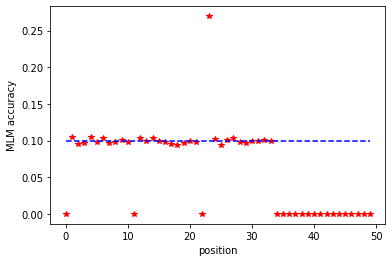

Epoch: 0 Pretraining Perplexity: 13.2949 Validation accuracy: 0.1035 Validation ppl: 12.5377 lr: 0.0005999404007685902


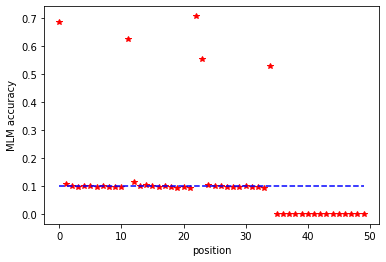

Epoch: 1 Pretraining Perplexity: 10.4119 Validation accuracy: 0.2488 Validation ppl: 7.6635 lr: 0.0005997609219172313


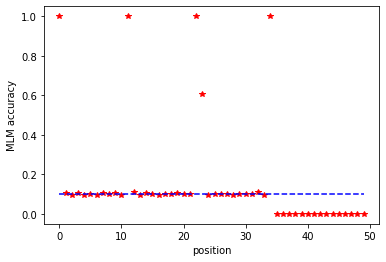

Epoch: 2 Pretraining Perplexity: 7.8269 Validation accuracy: 0.2200 Validation ppl: 7.4916 lr: 0.0005994616346595416


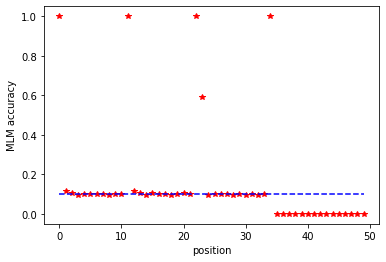

Epoch: 3 Pretraining Perplexity: 7.6043 Validation accuracy: 0.2371 Validation ppl: 7.2004 lr: 0.0005990426586146134


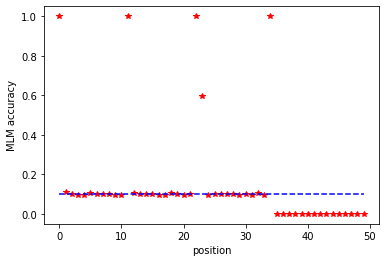

Epoch: 4 Pretraining Perplexity: 7.5612 Validation accuracy: 0.2080 Validation ppl: 7.5804 lr: 0.0005985041612387379


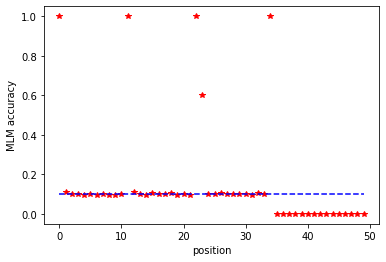

Epoch: 5 Pretraining Perplexity: 7.5346 Validation accuracy: 0.2359 Validation ppl: 7.3422 lr: 0.0005978463577584761


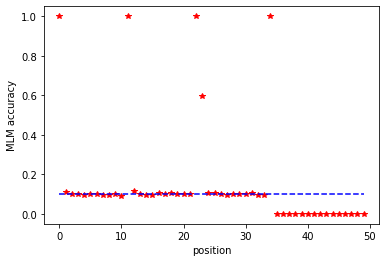

Epoch: 6 Pretraining Perplexity: 7.5294 Validation accuracy: 0.2098 Validation ppl: 7.5499 lr: 0.000597069511084638


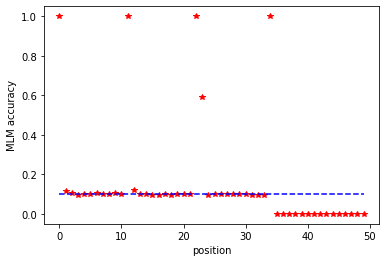

Epoch: 7 Pretraining Perplexity: 7.4931 Validation accuracy: 0.2366 Validation ppl: 7.2699 lr: 0.000596173931707201


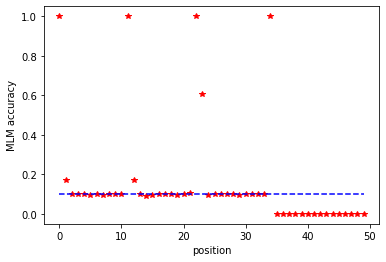

Epoch: 8 Pretraining Perplexity: 7.4484 Validation accuracy: 0.2149 Validation ppl: 7.3857 lr: 0.0005951599775712141


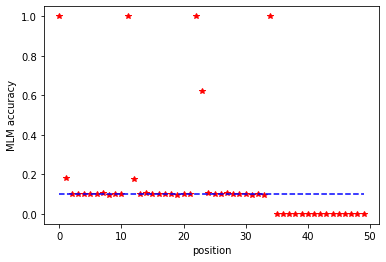

Epoch: 9 Pretraining Perplexity: 7.4053 Validation accuracy: 0.2337 Validation ppl: 7.2123 lr: 0.0005940280539337352


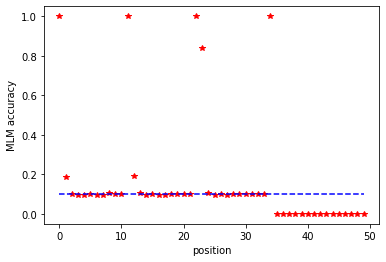

Epoch: 10 Pretraining Perplexity: 7.3377 Validation accuracy: 0.2390 Validation ppl: 7.0611 lr: 0.0005927786132018563


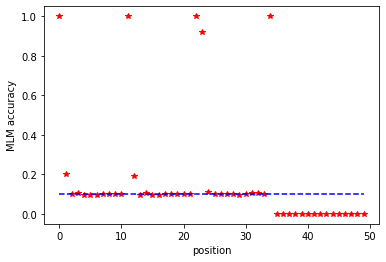

Epoch: 11 Pretraining Perplexity: 7.2791 Validation accuracy: 0.2459 Validation ppl: 7.0159 lr: 0.0005914121547518868


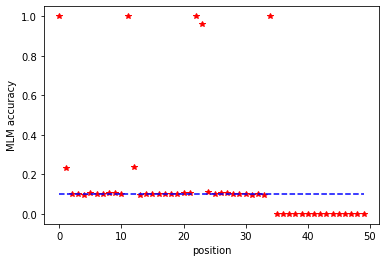

Epoch: 12 Pretraining Perplexity: 7.1979 Validation accuracy: 0.2226 Validation ppl: 7.2885 lr: 0.0005899292247297627


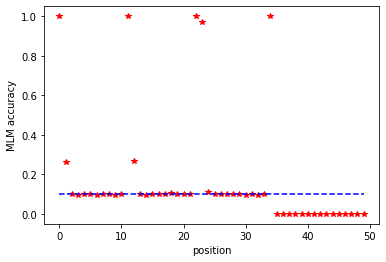

Epoch: 13 Pretraining Perplexity: 7.1386 Validation accuracy: 0.2605 Validation ppl: 6.7927 lr: 0.0005883304158327624


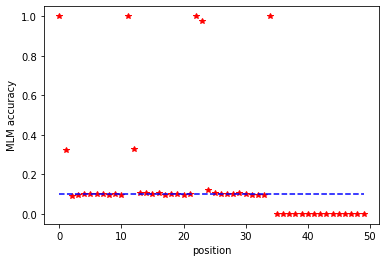

Epoch: 14 Pretraining Perplexity: 7.0866 Validation accuracy: 0.2370 Validation ppl: 7.1592 lr: 0.0005866163670726183


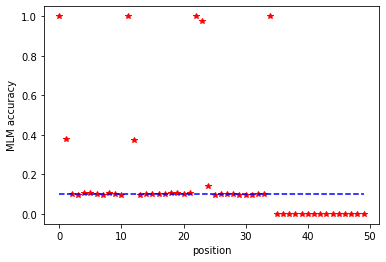

Epoch: 15 Pretraining Perplexity: 7.0018 Validation accuracy: 0.2448 Validation ppl: 7.0215 lr: 0.000584787763520116


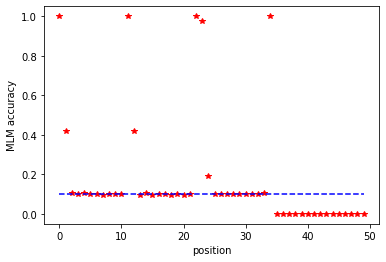

Epoch: 16 Pretraining Perplexity: 6.9504 Validation accuracy: 0.2731 Validation ppl: 6.6049 lr: 0.000582845336031286


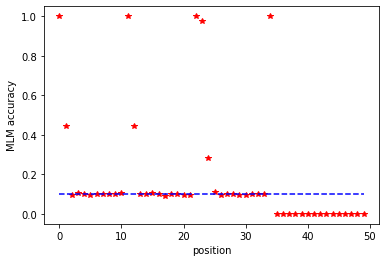

Epoch: 17 Pretraining Perplexity: 6.8630 Validation accuracy: 0.2850 Validation ppl: 6.4403 lr: 0.0005807898609552946


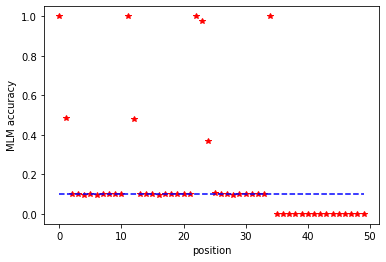

Epoch: 18 Pretraining Perplexity: 6.7783 Validation accuracy: 0.2994 Validation ppl: 6.2681 lr: 0.0005786221598241533


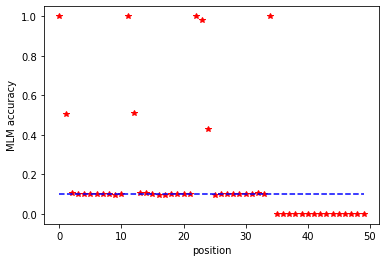

Epoch: 19 Pretraining Perplexity: 6.7135 Validation accuracy: 0.2680 Validation ppl: 6.5235 lr: 0.0005763430990243683


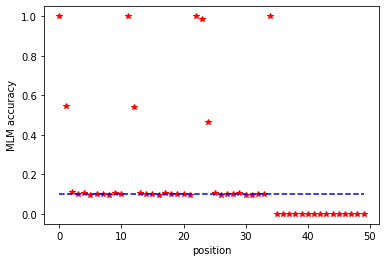

Epoch: 20 Pretraining Perplexity: 6.6573 Validation accuracy: 0.2579 Validation ppl: 6.5836 lr: 0.0005739535894506643


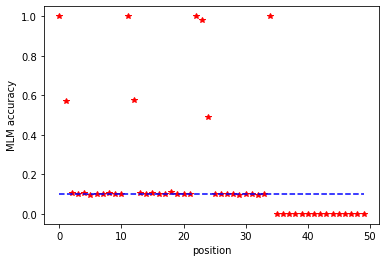

Epoch: 21 Pretraining Perplexity: 6.5981 Validation accuracy: 0.2699 Validation ppl: 6.4112 lr: 0.000571454586141917


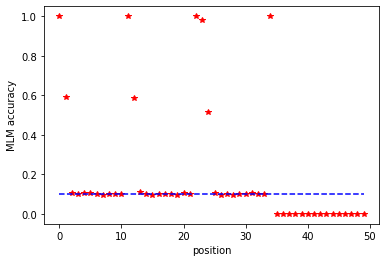

Epoch: 22 Pretraining Perplexity: 6.5728 Validation accuracy: 0.2670 Validation ppl: 6.5927 lr: 0.0005688470878994446


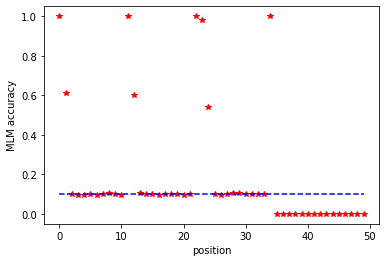

Epoch: 23 Pretraining Perplexity: 6.5762 Validation accuracy: 0.2972 Validation ppl: 6.0940 lr: 0.0005661321368878056


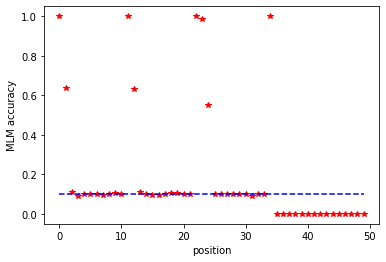

Epoch: 24 Pretraining Perplexity: 6.5299 Validation accuracy: 0.2884 Validation ppl: 6.3204 lr: 0.0005633108223531533


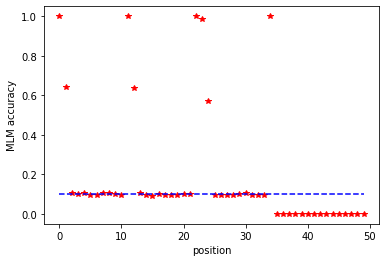

Epoch: 25 Pretraining Perplexity: 6.5177 Validation accuracy: 0.2845 Validation ppl: 6.4023 lr: 0.000560384268086027


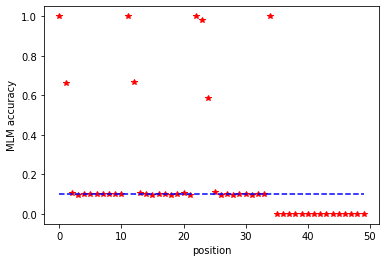

Epoch: 26 Pretraining Perplexity: 6.4890 Validation accuracy: 0.3032 Validation ppl: 6.2909 lr: 0.0005573536437678908


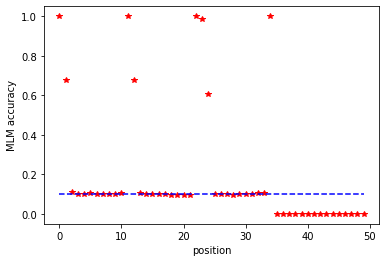

Epoch: 27 Pretraining Perplexity: 6.4791 Validation accuracy: 0.2921 Validation ppl: 6.2587 lr: 0.000554220160674793


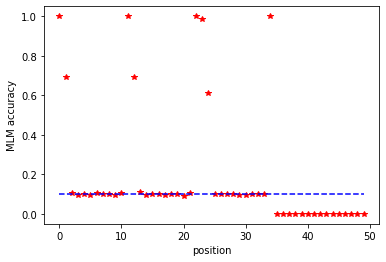

Epoch: 28 Pretraining Perplexity: 6.4327 Validation accuracy: 0.2782 Validation ppl: 6.3765 lr: 0.0005509850711932461


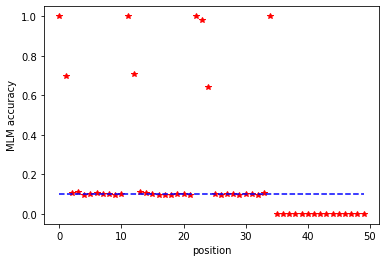

Epoch: 29 Pretraining Perplexity: 6.4358 Validation accuracy: 0.2676 Validation ppl: 6.5072 lr: 0.0005476496683196734


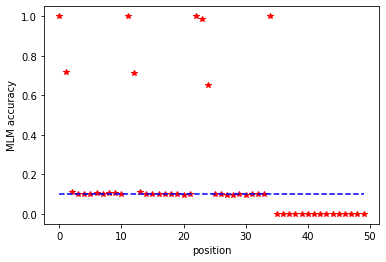

Epoch: 30 Pretraining Perplexity: 6.4241 Validation accuracy: 0.2794 Validation ppl: 6.2028 lr: 0.0005442152851436265


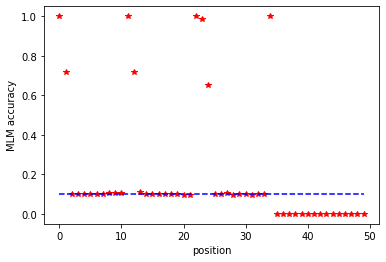

Epoch: 31 Pretraining Perplexity: 6.3996 Validation accuracy: 0.3085 Validation ppl: 6.0589 lr: 0.0005406832943149777


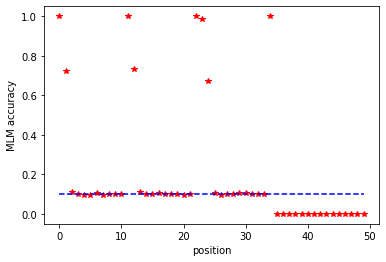

Epoch: 32 Pretraining Perplexity: 6.3829 Validation accuracy: 0.3060 Validation ppl: 6.1133 lr: 0.0005370551074953009


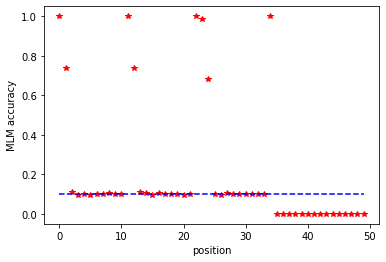

Epoch: 33 Pretraining Perplexity: 6.3712 Validation accuracy: 0.2793 Validation ppl: 6.4817 lr: 0.0005333321747936605


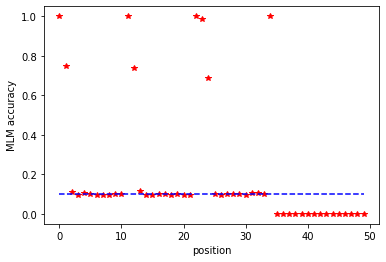

Epoch: 34 Pretraining Perplexity: 6.3555 Validation accuracy: 0.2988 Validation ppl: 5.8728 lr: 0.000529515984187034


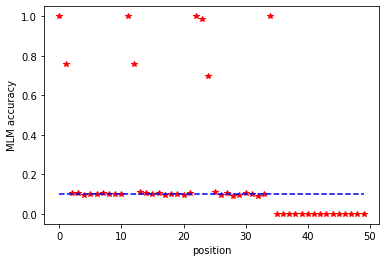

Epoch: 35 Pretraining Perplexity: 6.3438 Validation accuracy: 0.2971 Validation ppl: 6.0435 lr: 0.0005256080609255987


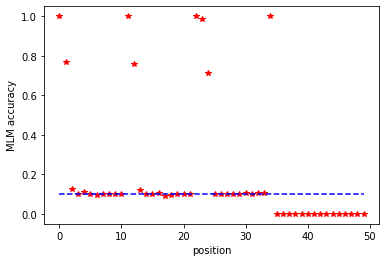

Epoch: 36 Pretraining Perplexity: 6.3134 Validation accuracy: 0.2777 Validation ppl: 6.3603 lr: 0.0005216099669231221


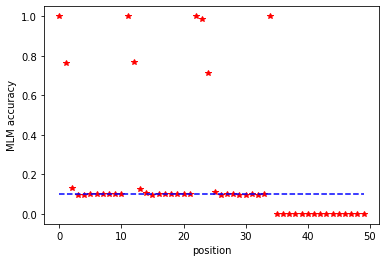

Epoch: 37 Pretraining Perplexity: 6.3065 Validation accuracy: 0.3063 Validation ppl: 6.1225 lr: 0.0005175233001326979


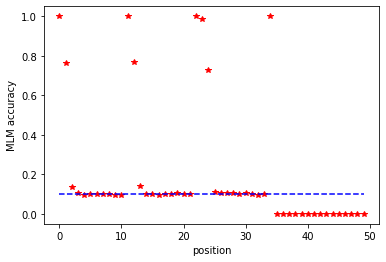

Epoch: 38 Pretraining Perplexity: 6.3028 Validation accuracy: 0.3029 Validation ppl: 6.1707 lr: 0.0005133496939080788


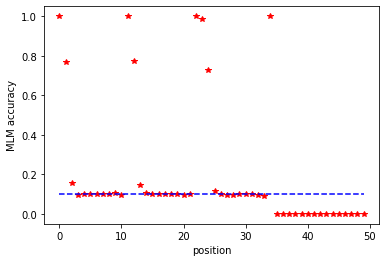

Epoch: 39 Pretraining Perplexity: 6.2912 Validation accuracy: 0.3017 Validation ppl: 5.9520 lr: 0.0005090908163508588


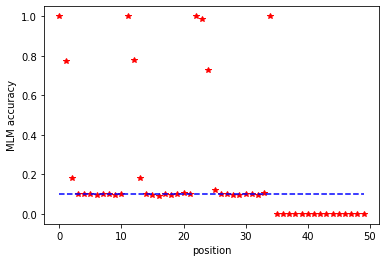

Epoch: 40 Pretraining Perplexity: 6.2544 Validation accuracy: 0.2847 Validation ppl: 6.0874 lr: 0.000504748369643769


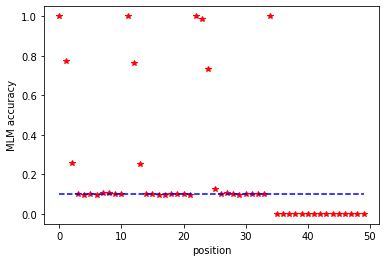

Epoch: 41 Pretraining Perplexity: 6.1965 Validation accuracy: 0.3036 Validation ppl: 6.0287 lr: 0.0005003240893703518


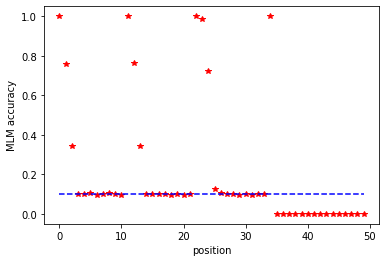

Epoch: 42 Pretraining Perplexity: 6.1095 Validation accuracy: 0.3139 Validation ppl: 5.9280 lr: 0.0004958197438212843


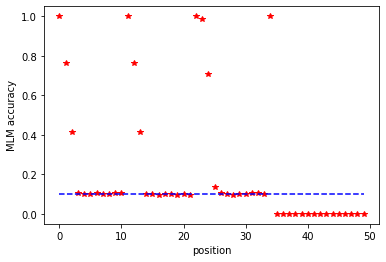

Epoch: 43 Pretraining Perplexity: 6.0177 Validation accuracy: 0.3241 Validation ppl: 5.6357 lr: 0.0004912371332876304


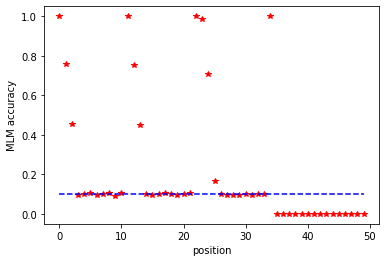

Epoch: 44 Pretraining Perplexity: 5.9629 Validation accuracy: 0.3303 Validation ppl: 5.6828 lr: 0.0004865780893413032


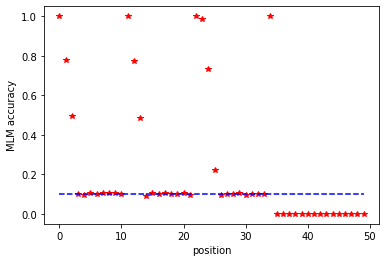

Epoch: 45 Pretraining Perplexity: 5.8823 Validation accuracy: 0.3307 Validation ppl: 5.5465 lr: 0.00048184447410302414


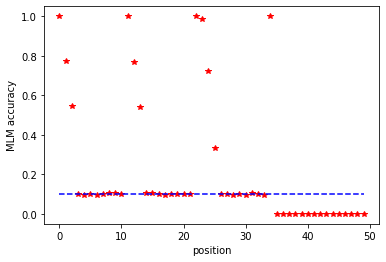

Epoch: 46 Pretraining Perplexity: 5.7945 Validation accuracy: 0.3372 Validation ppl: 5.5208 lr: 0.00047703817949807325


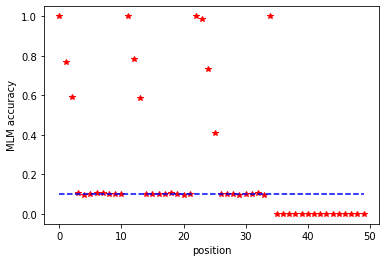

Epoch: 47 Pretraining Perplexity: 5.7070 Validation accuracy: 0.3386 Validation ppl: 5.4267 lr: 0.0004721611265001267


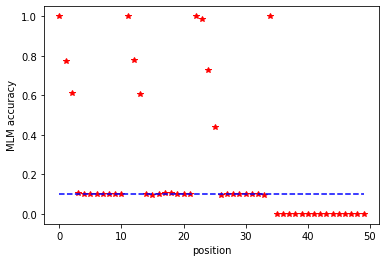

Epoch: 48 Pretraining Perplexity: 5.7037 Validation accuracy: 0.3265 Validation ppl: 5.4152 lr: 0.00046721526436348487


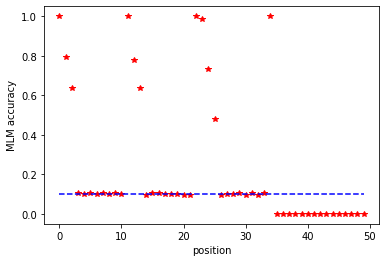

Epoch: 49 Pretraining Perplexity: 5.6464 Validation accuracy: 0.3453 Validation ppl: 5.4545 lr: 0.00046220256984399636


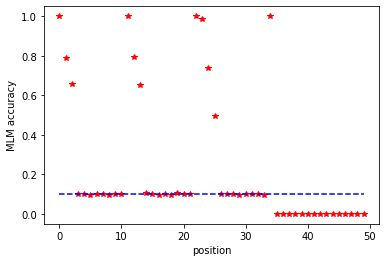

Epoch: 50 Pretraining Perplexity: 5.6118 Validation accuracy: 0.3364 Validation ppl: 5.4294 lr: 0.000457125046408991


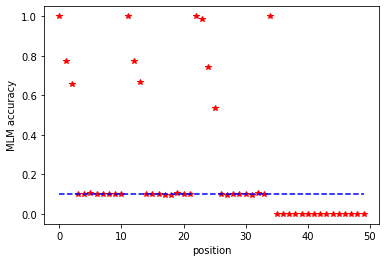

Epoch: 51 Pretraining Perplexity: 5.5898 Validation accuracy: 0.3445 Validation ppl: 5.3233 lr: 0.00045198472343653697


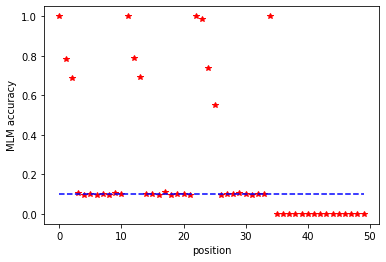

Epoch: 52 Pretraining Perplexity: 5.5756 Validation accuracy: 0.3628 Validation ppl: 5.3611 lr: 0.00044678365540434074


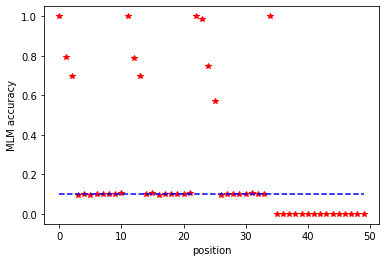

Epoch: 53 Pretraining Perplexity: 5.5558 Validation accuracy: 0.3503 Validation ppl: 5.3701 lr: 0.0004415239210686168


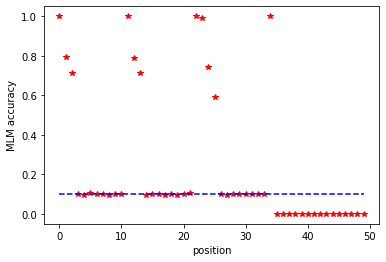

Epoch: 54 Pretraining Perplexity: 5.5436 Validation accuracy: 0.3451 Validation ppl: 5.2423 lr: 0.00043620762263325266


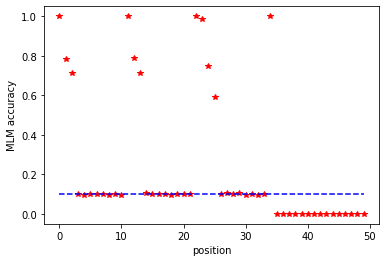

Epoch: 55 Pretraining Perplexity: 5.5320 Validation accuracy: 0.3609 Validation ppl: 5.2089 lr: 0.0004308368849096028


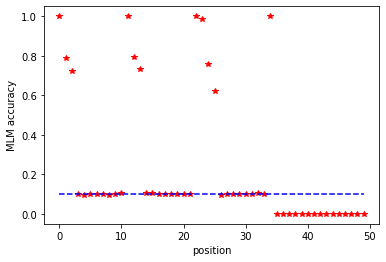

Epoch: 56 Pretraining Perplexity: 5.4876 Validation accuracy: 0.3485 Validation ppl: 5.3794 lr: 0.00042541385446724677


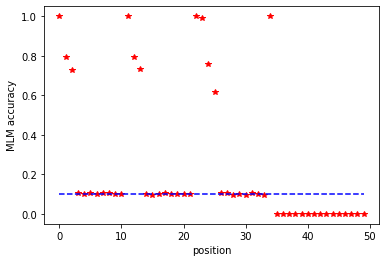

Epoch: 57 Pretraining Perplexity: 5.4923 Validation accuracy: 0.3402 Validation ppl: 5.3695 lr: 0.00041994069877605096


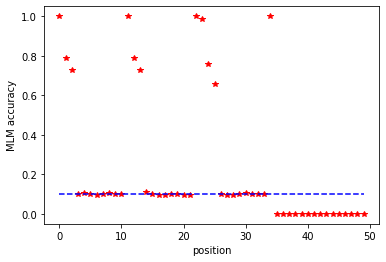

Epoch: 58 Pretraining Perplexity: 5.4742 Validation accuracy: 0.3276 Validation ppl: 5.5257 lr: 0.000414419605339877


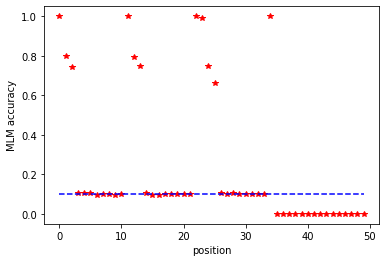

Epoch: 59 Pretraining Perplexity: 5.4713 Validation accuracy: 0.3578 Validation ppl: 5.2033 lr: 0.0004088527808222832


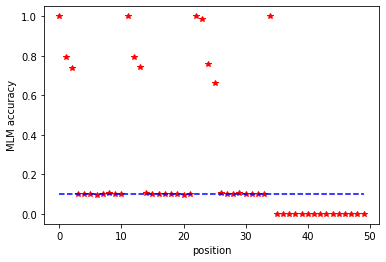

Epoch: 60 Pretraining Perplexity: 5.4725 Validation accuracy: 0.3779 Validation ppl: 5.0504 lr: 0.000403242450164568


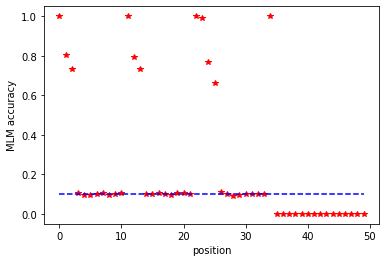

Epoch: 61 Pretraining Perplexity: 5.4658 Validation accuracy: 0.3328 Validation ppl: 5.5326 lr: 0.00039759085569650825


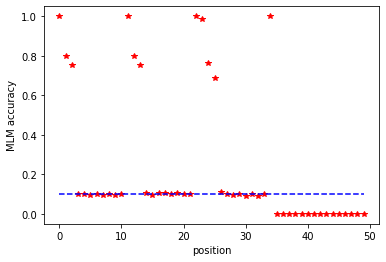

Epoch: 62 Pretraining Perplexity: 5.4406 Validation accuracy: 0.3513 Validation ppl: 5.3474 lr: 0.00039190025624014747


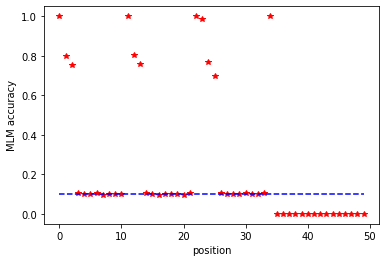

Epoch: 63 Pretraining Perplexity: 5.4174 Validation accuracy: 0.3590 Validation ppl: 5.2697 lr: 0.0003861729262069931


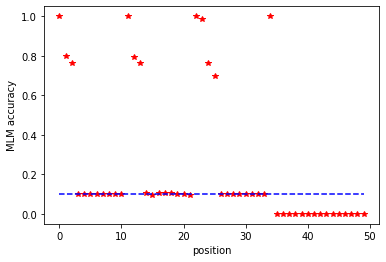

Epoch: 64 Pretraining Perplexity: 5.4333 Validation accuracy: 0.3539 Validation ppl: 5.2435 lr: 0.0003804111546889827


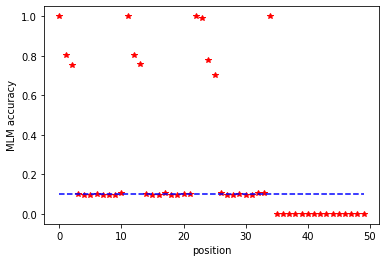

Epoch: 65 Pretraining Perplexity: 5.4215 Validation accuracy: 0.3520 Validation ppl: 5.2880 lr: 0.00037461724454358226


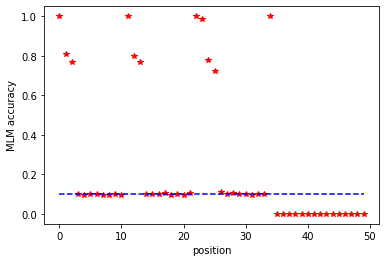

Epoch: 66 Pretraining Perplexity: 5.4147 Validation accuracy: 0.3486 Validation ppl: 5.2542 lr: 0.00036879351147338303


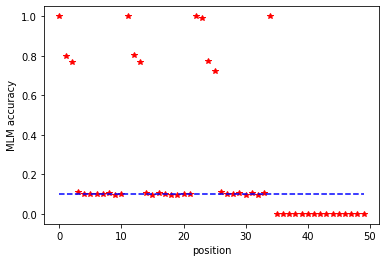

Epoch: 67 Pretraining Perplexity: 5.3973 Validation accuracy: 0.3458 Validation ppl: 5.3082 lr: 0.0003629422831005652


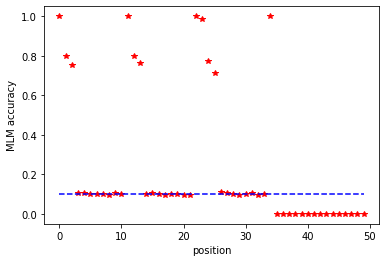

Epoch: 68 Pretraining Perplexity: 5.4099 Validation accuracy: 0.3545 Validation ppl: 5.3873 lr: 0.0003570658980365956


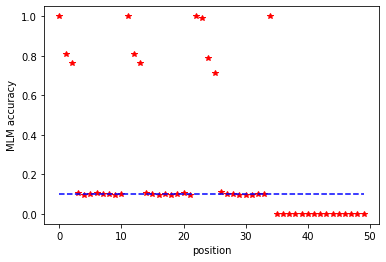

Epoch: 69 Pretraining Perplexity: 5.4069 Validation accuracy: 0.3546 Validation ppl: 5.2213 lr: 0.00035116670494753587


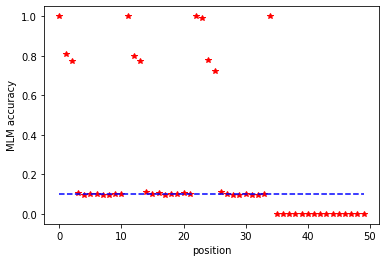

Epoch: 70 Pretraining Perplexity: 5.4014 Validation accuracy: 0.3607 Validation ppl: 5.2464 lr: 0.00034524706161532945


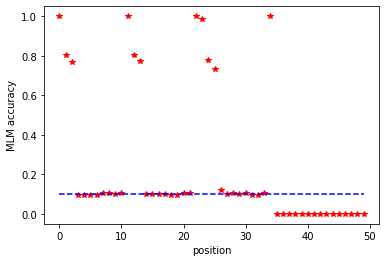

Epoch: 71 Pretraining Perplexity: 5.3864 Validation accuracy: 0.3781 Validation ppl: 4.8497 lr: 0.00033930933399544717


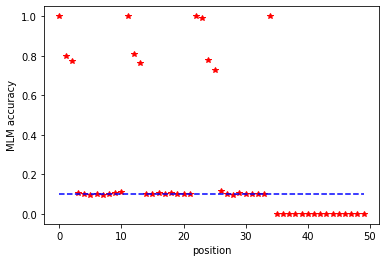

Epoch: 72 Pretraining Perplexity: 5.3923 Validation accuracy: 0.3564 Validation ppl: 5.3572 lr: 0.0003333558952712644


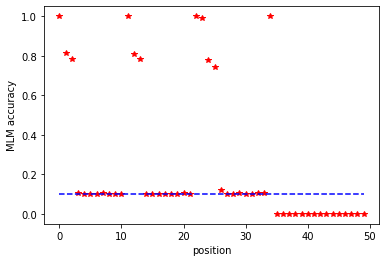

Epoch: 73 Pretraining Perplexity: 5.3770 Validation accuracy: 0.3612 Validation ppl: 5.1045 lr: 0.000327389124905551


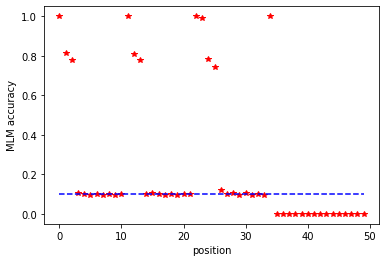

Epoch: 74 Pretraining Perplexity: 5.3643 Validation accuracy: 0.3830 Validation ppl: 5.0536 lr: 0.0003214114076894498


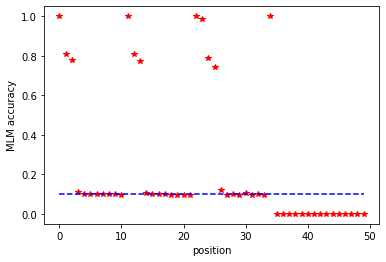

Epoch: 75 Pretraining Perplexity: 5.3887 Validation accuracy: 0.3629 Validation ppl: 5.3400 lr: 0.00031542513278932726


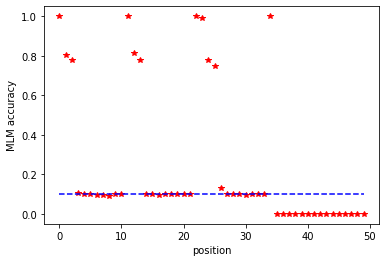

Epoch: 76 Pretraining Perplexity: 5.3628 Validation accuracy: 0.3747 Validation ppl: 5.0065 lr: 0.0003094326927918736


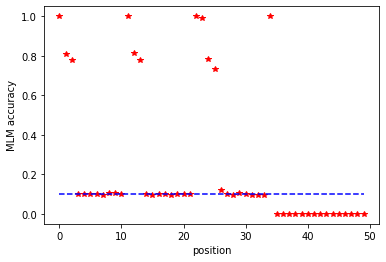

Epoch: 77 Pretraining Perplexity: 5.3650 Validation accuracy: 0.3416 Validation ppl: 5.4176 lr: 0.0003034364827478376


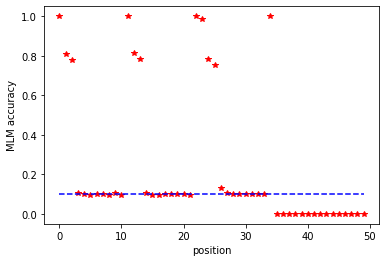

Epoch: 78 Pretraining Perplexity: 5.3614 Validation accuracy: 0.3577 Validation ppl: 5.0461 lr: 0.0002974388992147751


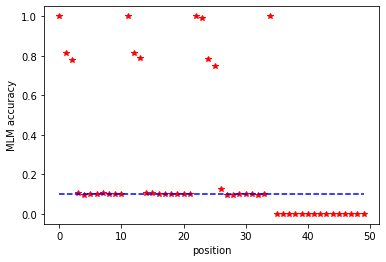

Epoch: 79 Pretraining Perplexity: 5.3687 Validation accuracy: 0.3507 Validation ppl: 5.3501 lr: 0.0002914423392991966


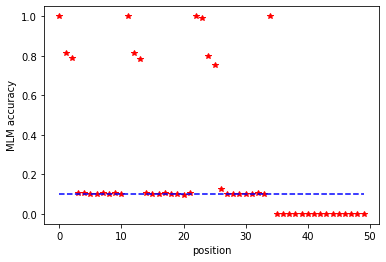

Epoch: 80 Pretraining Perplexity: 5.3539 Validation accuracy: 0.3495 Validation ppl: 5.2741 lr: 0.0002854491996984943


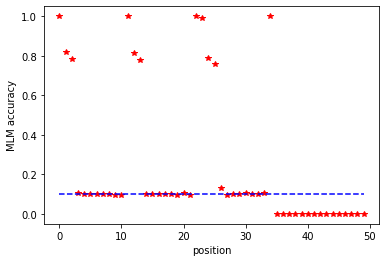

Epoch: 81 Pretraining Perplexity: 5.3494 Validation accuracy: 0.3317 Validation ppl: 5.4850 lr: 0.00027946187574303343


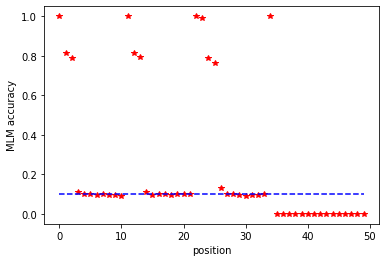

Epoch: 82 Pretraining Perplexity: 5.3531 Validation accuracy: 0.3475 Validation ppl: 5.4003 lr: 0.0002734827604387893


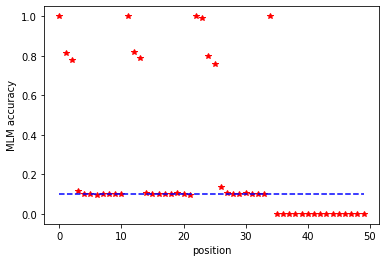

Epoch: 83 Pretraining Perplexity: 5.3374 Validation accuracy: 0.3432 Validation ppl: 5.3522 lr: 0.00026751424351091434


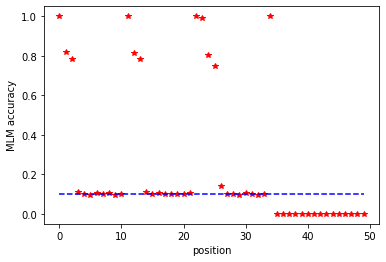

Epoch: 84 Pretraining Perplexity: 5.3600 Validation accuracy: 0.3433 Validation ppl: 5.3749 lr: 0.00026155871044861525


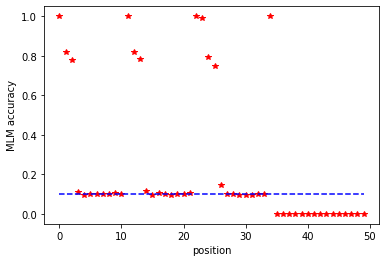

Epoch: 85 Pretraining Perplexity: 5.3576 Validation accuracy: 0.3675 Validation ppl: 5.0884 lr: 0.00025561854155172435


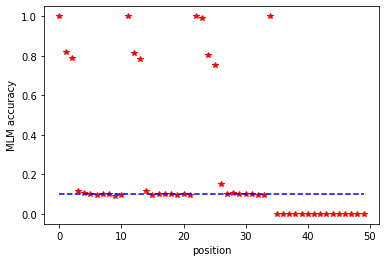

Epoch: 86 Pretraining Perplexity: 5.3307 Validation accuracy: 0.3503 Validation ppl: 5.2591 lr: 0.0002496961109793433


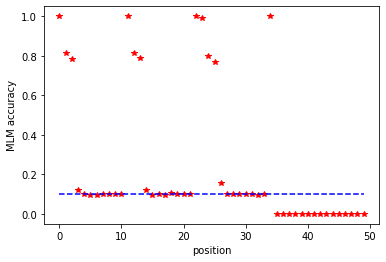

Epoch: 87 Pretraining Perplexity: 5.3516 Validation accuracy: 0.3415 Validation ppl: 5.3958 lr: 0.0002437937858009435


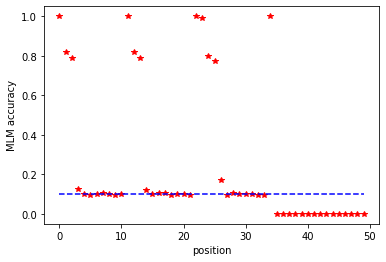

Epoch: 88 Pretraining Perplexity: 5.3136 Validation accuracy: 0.3651 Validation ppl: 5.0114 lr: 0.00023791392505029808


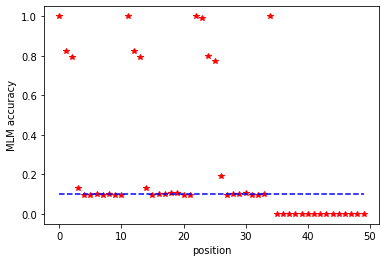

Epoch: 89 Pretraining Perplexity: 5.2957 Validation accuracy: 0.3451 Validation ppl: 5.4413 lr: 0.00023205887878262633


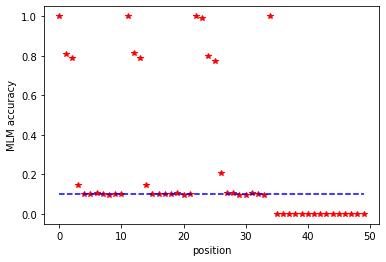

Epoch: 90 Pretraining Perplexity: 5.3216 Validation accuracy: 0.3423 Validation ppl: 5.2855 lr: 0.00022623098713532675


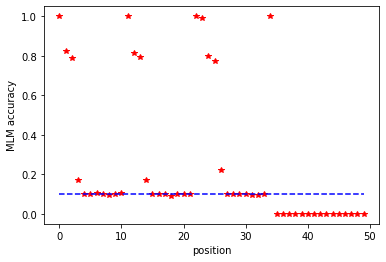

Epoch: 91 Pretraining Perplexity: 5.2673 Validation accuracy: 0.3629 Validation ppl: 5.0316 lr: 0.00022043257939267404


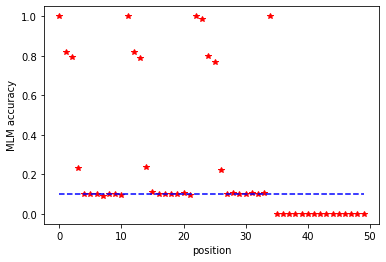

Epoch: 92 Pretraining Perplexity: 5.2197 Validation accuracy: 0.3772 Validation ppl: 4.9821 lr: 0.00021466597305485355


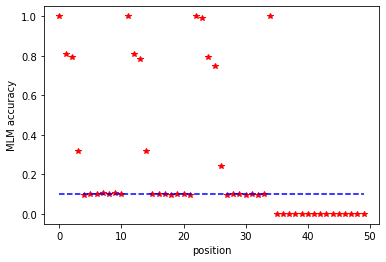

Epoch: 93 Pretraining Perplexity: 5.1675 Validation accuracy: 0.3929 Validation ppl: 4.7924 lr: 0.0002089334729117059


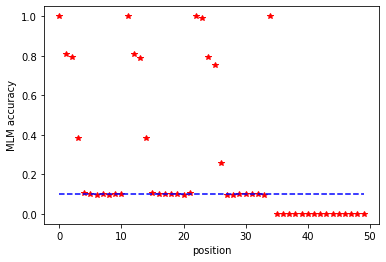

Epoch: 94 Pretraining Perplexity: 5.0972 Validation accuracy: 0.3776 Validation ppl: 4.9335 lr: 0.00020323737012155137


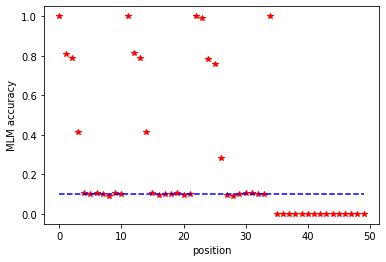

Epoch: 95 Pretraining Perplexity: 5.0490 Validation accuracy: 0.3973 Validation ppl: 4.7706 lr: 0.0001975799412954629


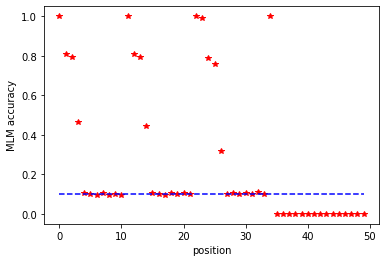

Epoch: 96 Pretraining Perplexity: 4.9882 Validation accuracy: 0.3901 Validation ppl: 4.6531 lr: 0.00019196341538858585


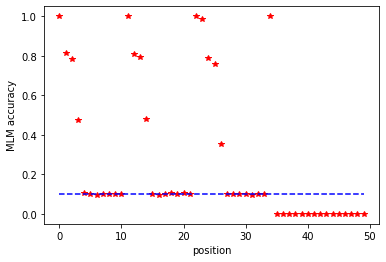

Epoch: 97 Pretraining Perplexity: 4.9669 Validation accuracy: 0.4300 Validation ppl: 4.4478 lr: 0.0001863900699025274


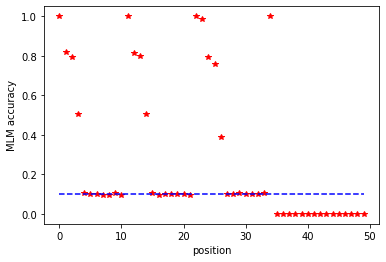

Epoch: 98 Pretraining Perplexity: 4.9282 Validation accuracy: 0.3832 Validation ppl: 4.7482 lr: 0.0001808621324105151


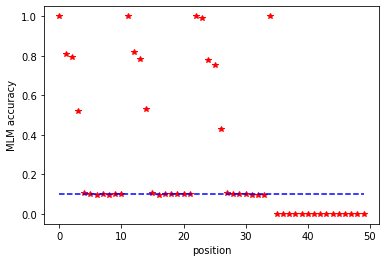

Epoch: 99 Pretraining Perplexity: 4.9016 Validation accuracy: 0.3956 Validation ppl: 4.7365 lr: 0.00017538181233695823


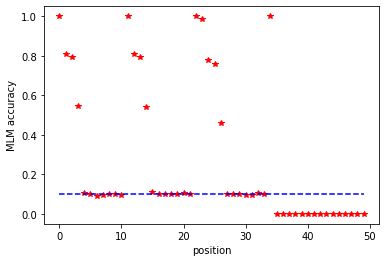

Epoch: 100 Pretraining Perplexity: 4.8687 Validation accuracy: 0.3885 Validation ppl: 4.6739 lr: 0.00016995130007437873


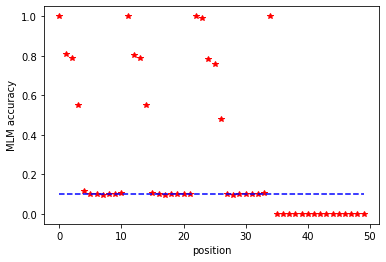

Epoch: 101 Pretraining Perplexity: 4.8669 Validation accuracy: 0.4163 Validation ppl: 4.5926 lr: 0.00016457276610794687


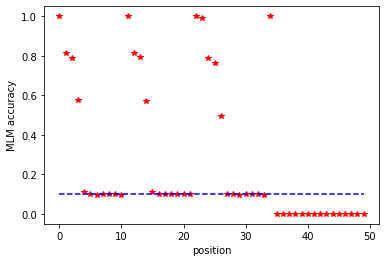

Epoch: 102 Pretraining Perplexity: 4.8452 Validation accuracy: 0.4005 Validation ppl: 4.5217 lr: 0.00015924836014797486


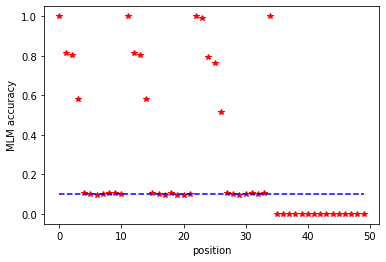

Epoch: 103 Pretraining Perplexity: 4.8145 Validation accuracy: 0.4029 Validation ppl: 4.6492 lr: 0.0001539802102707142


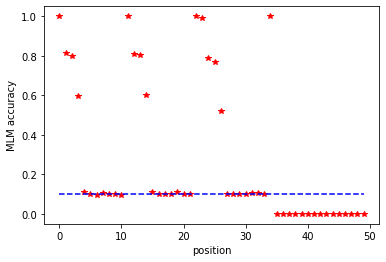

Epoch: 104 Pretraining Perplexity: 4.8177 Validation accuracy: 0.3946 Validation ppl: 4.6043 lr: 0.0001487704220677978


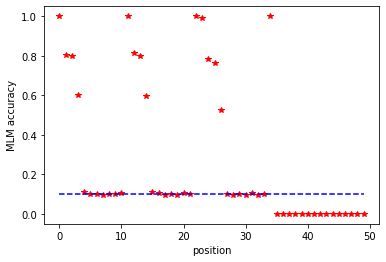

Epoch: 105 Pretraining Perplexity: 4.7988 Validation accuracy: 0.4003 Validation ppl: 4.6720 lr: 0.00014362107780467126


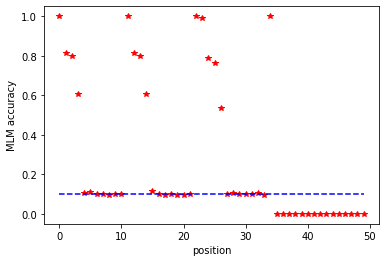

Epoch: 106 Pretraining Perplexity: 4.8033 Validation accuracy: 0.4147 Validation ppl: 4.5545 lr: 0.00013853423558834527


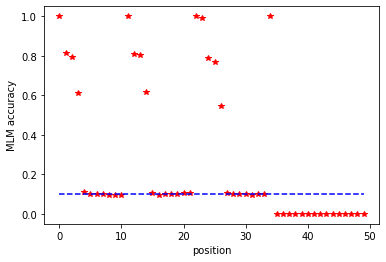

Epoch: 107 Pretraining Perplexity: 4.7780 Validation accuracy: 0.3980 Validation ppl: 4.6480 lr: 0.00013351192854480526


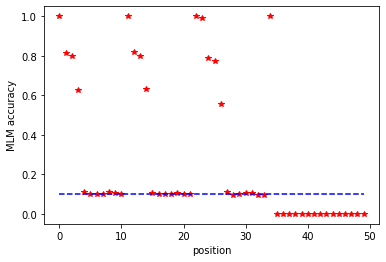

Epoch: 108 Pretraining Perplexity: 4.7742 Validation accuracy: 0.3940 Validation ppl: 4.6493 lr: 0.00012855616400640456


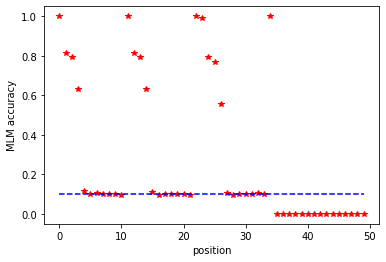

Epoch: 109 Pretraining Perplexity: 4.7599 Validation accuracy: 0.4158 Validation ppl: 4.6155 lr: 0.00012366892270956664


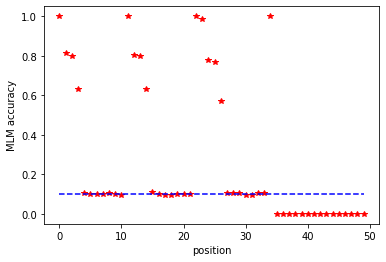

Epoch: 110 Pretraining Perplexity: 4.7606 Validation accuracy: 0.4316 Validation ppl: 4.3932 lr: 0.00011885215800311913


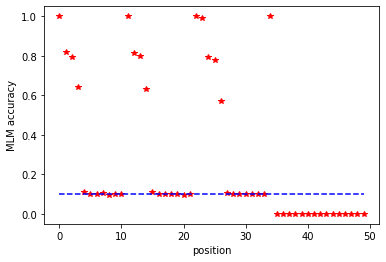

Epoch: 111 Pretraining Perplexity: 4.7601 Validation accuracy: 0.3944 Validation ppl: 4.6772 lr: 0.00011410779506757128


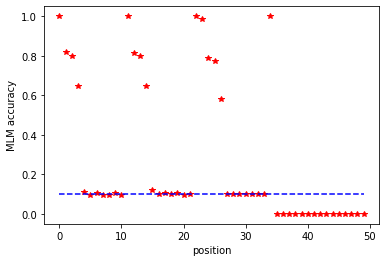

Epoch: 112 Pretraining Perplexity: 4.7445 Validation accuracy: 0.4053 Validation ppl: 4.5680 lr: 0.00010943773014565228


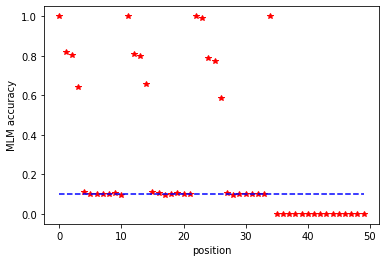

Epoch: 113 Pretraining Perplexity: 4.7496 Validation accuracy: 0.3998 Validation ppl: 4.6078 lr: 0.00010484382978441517


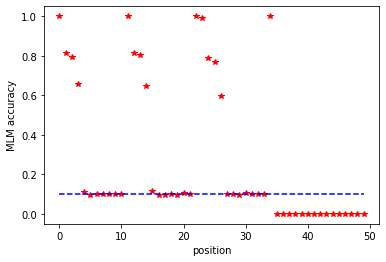

Epoch: 114 Pretraining Perplexity: 4.7537 Validation accuracy: 0.4199 Validation ppl: 4.5017 lr: 0.00010032793008920767


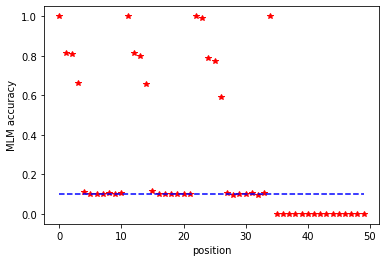

Epoch: 115 Pretraining Perplexity: 4.7395 Validation accuracy: 0.3919 Validation ppl: 4.7475 lr: 9.58918359898129e-05


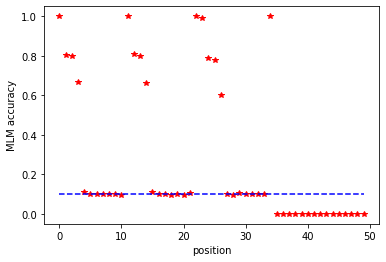

Epoch: 116 Pretraining Perplexity: 4.7257 Validation accuracy: 0.4108 Validation ppl: 4.5181 lr: 9.153732051904842e-05


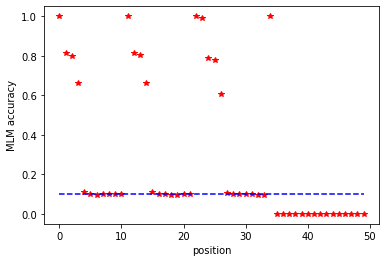

Epoch: 117 Pretraining Perplexity: 4.7338 Validation accuracy: 0.4036 Validation ppl: 4.5773 lr: 8.726612410411433e-05


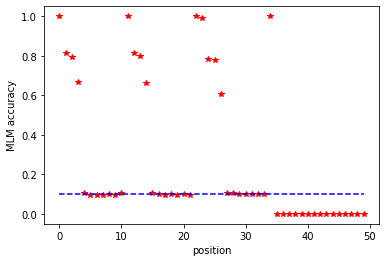

Epoch: 118 Pretraining Perplexity: 4.7243 Validation accuracy: 0.4152 Validation ppl: 4.5254 lr: 8.307995387097436e-05


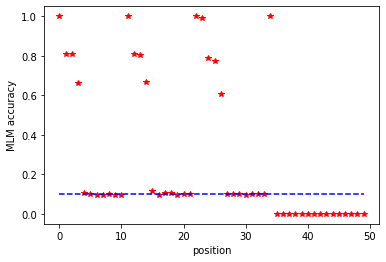

Epoch: 119 Pretraining Perplexity: 4.7207 Validation accuracy: 0.4134 Validation ppl: 4.5148 lr: 7.898048296204508e-05


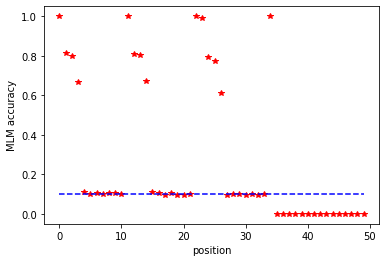

Epoch: 120 Pretraining Perplexity: 4.7110 Validation accuracy: 0.3914 Validation ppl: 4.5884 lr: 7.496934986746992e-05


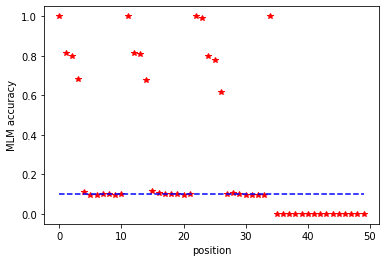

Epoch: 121 Pretraining Perplexity: 4.6992 Validation accuracy: 0.4160 Validation ppl: 4.4363 lr: 7.104815777024095e-05


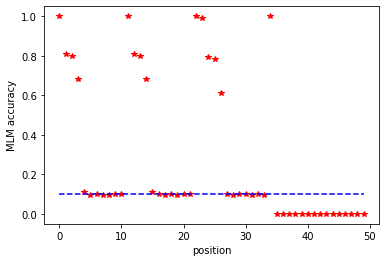

Epoch: 122 Pretraining Perplexity: 4.6946 Validation accuracy: 0.3969 Validation ppl: 4.7205 lr: 6.72184739054337e-05


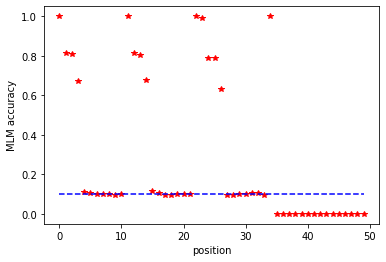

Epoch: 123 Pretraining Perplexity: 4.7105 Validation accuracy: 0.4140 Validation ppl: 4.5133 lr: 6.34818289338102e-05


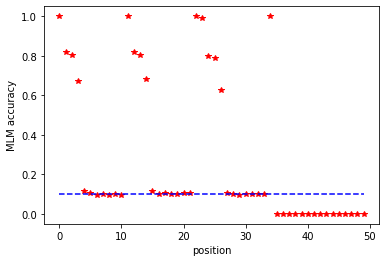

Epoch: 124 Pretraining Perplexity: 4.7092 Validation accuracy: 0.4313 Validation ppl: 4.2792 lr: 5.9999999999999995e-05


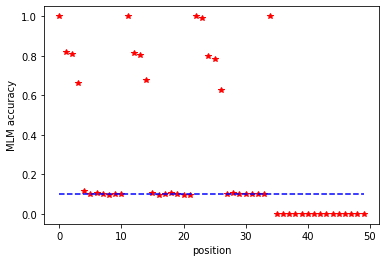

Epoch: 125 Pretraining Perplexity: 4.7019 Validation accuracy: 0.4033 Validation ppl: 4.6705 lr: 5.9999999999999995e-05


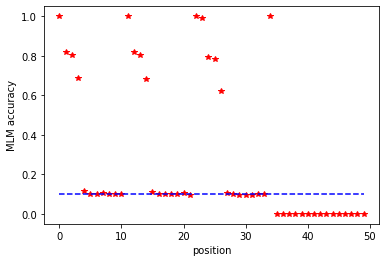

Epoch: 126 Pretraining Perplexity: 4.6948 Validation accuracy: 0.4047 Validation ppl: 4.6056 lr: 5.9999999999999995e-05


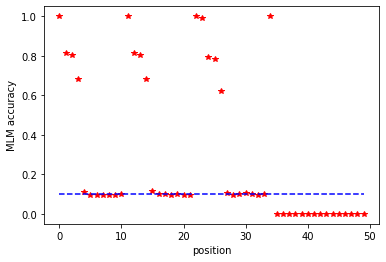

Epoch: 127 Pretraining Perplexity: 4.7043 Validation accuracy: 0.4219 Validation ppl: 4.4608 lr: 5.9999999999999995e-05


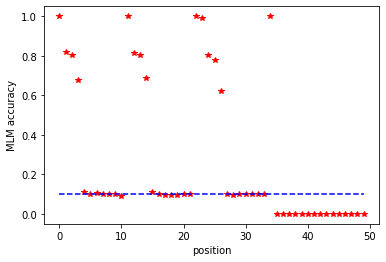

Epoch: 128 Pretraining Perplexity: 4.7025 Validation accuracy: 0.3972 Validation ppl: 4.5909 lr: 5.9999999999999995e-05


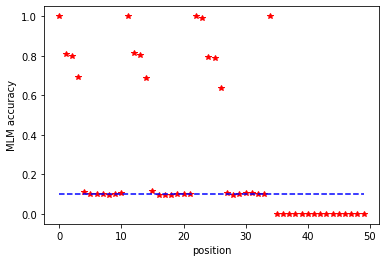

Epoch: 129 Pretraining Perplexity: 4.6872 Validation accuracy: 0.3967 Validation ppl: 4.7195 lr: 5.9999999999999995e-05


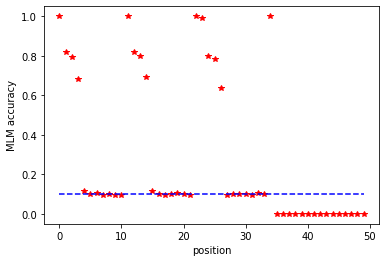

Epoch: 130 Pretraining Perplexity: 4.6916 Validation accuracy: 0.4327 Validation ppl: 4.3482 lr: 5.9999999999999995e-05


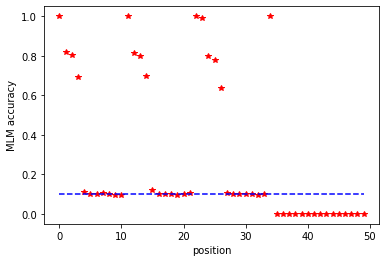

Epoch: 131 Pretraining Perplexity: 4.6827 Validation accuracy: 0.4077 Validation ppl: 4.6101 lr: 5.9999999999999995e-05


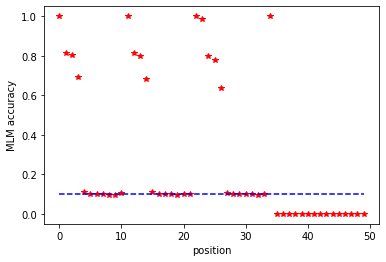

Epoch: 132 Pretraining Perplexity: 4.6952 Validation accuracy: 0.4016 Validation ppl: 4.6022 lr: 5.9999999999999995e-05


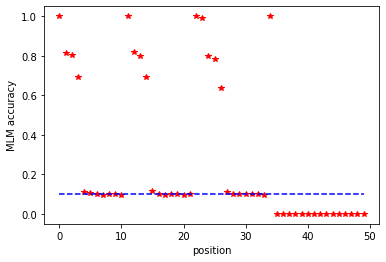

Epoch: 133 Pretraining Perplexity: 4.6951 Validation accuracy: 0.3990 Validation ppl: 4.7435 lr: 5.9999999999999995e-05


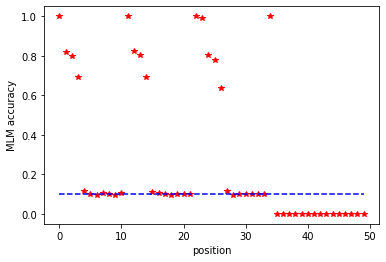

Epoch: 134 Pretraining Perplexity: 4.7040 Validation accuracy: 0.4125 Validation ppl: 4.5717 lr: 5.9999999999999995e-05


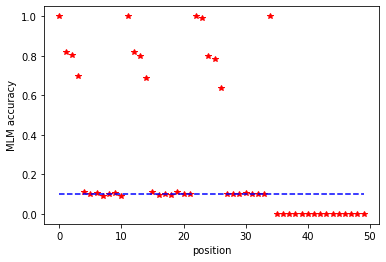

Epoch: 135 Pretraining Perplexity: 4.6861 Validation accuracy: 0.4182 Validation ppl: 4.4626 lr: 5.9999999999999995e-05


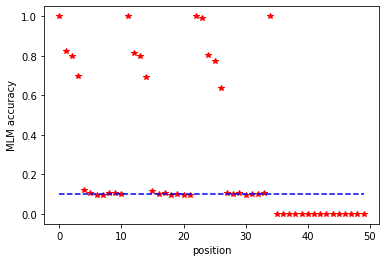

Epoch: 136 Pretraining Perplexity: 4.6904 Validation accuracy: 0.4252 Validation ppl: 4.2625 lr: 5.9999999999999995e-05


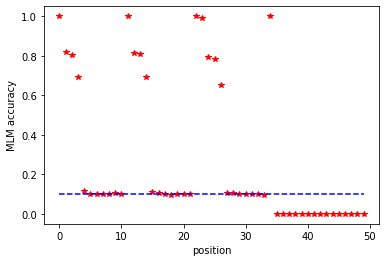

Epoch: 137 Pretraining Perplexity: 4.6900 Validation accuracy: 0.4187 Validation ppl: 4.3821 lr: 5.9999999999999995e-05


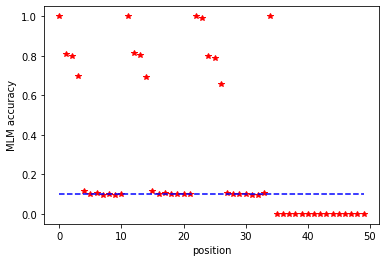

Epoch: 138 Pretraining Perplexity: 4.6775 Validation accuracy: 0.4342 Validation ppl: 4.3875 lr: 5.9999999999999995e-05


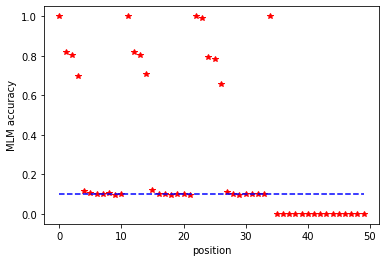

Epoch: 139 Pretraining Perplexity: 4.6821 Validation accuracy: 0.4348 Validation ppl: 4.2877 lr: 5.9999999999999995e-05


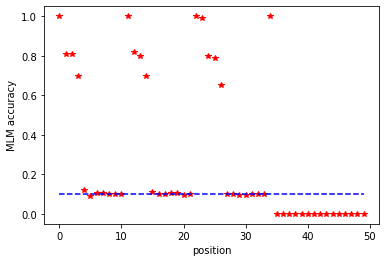

Epoch: 140 Pretraining Perplexity: 4.6607 Validation accuracy: 0.4008 Validation ppl: 4.5365 lr: 5.9999999999999995e-05


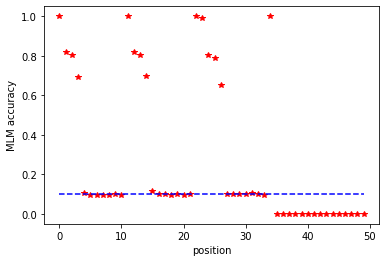

Epoch: 141 Pretraining Perplexity: 4.6715 Validation accuracy: 0.4178 Validation ppl: 4.3524 lr: 5.9999999999999995e-05


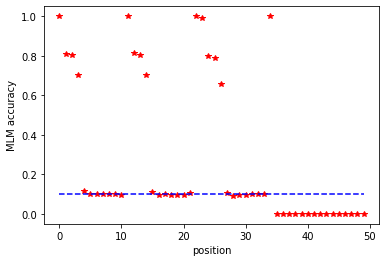

Epoch: 142 Pretraining Perplexity: 4.6757 Validation accuracy: 0.4111 Validation ppl: 4.4156 lr: 5.9999999999999995e-05


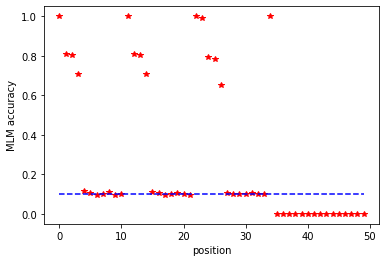

Epoch: 143 Pretraining Perplexity: 4.6674 Validation accuracy: 0.4104 Validation ppl: 4.6164 lr: 5.9999999999999995e-05


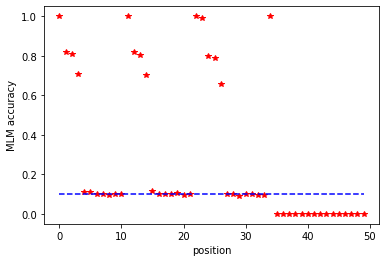

Epoch: 144 Pretraining Perplexity: 4.6886 Validation accuracy: 0.4167 Validation ppl: 4.4500 lr: 5.9999999999999995e-05


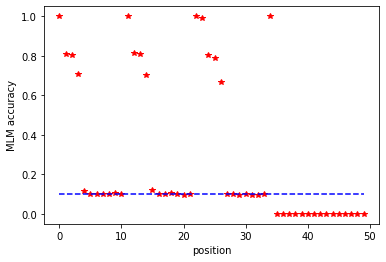

Epoch: 145 Pretraining Perplexity: 4.6722 Validation accuracy: 0.4190 Validation ppl: 4.4194 lr: 5.9999999999999995e-05


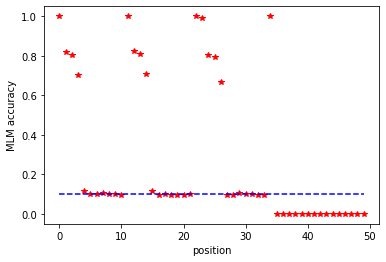

Epoch: 146 Pretraining Perplexity: 4.6719 Validation accuracy: 0.4028 Validation ppl: 4.5335 lr: 5.9999999999999995e-05


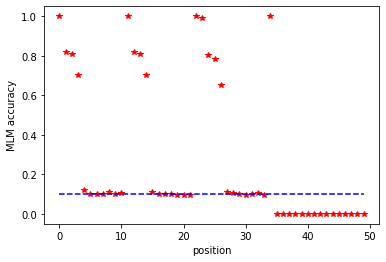

Epoch: 147 Pretraining Perplexity: 4.6654 Validation accuracy: 0.4124 Validation ppl: 4.5608 lr: 5.9999999999999995e-05


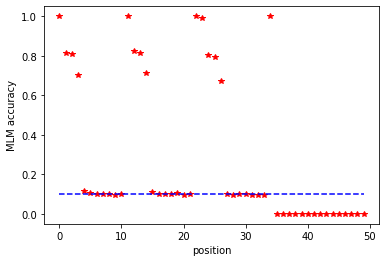

Epoch: 148 Pretraining Perplexity: 4.6528 Validation accuracy: 0.4218 Validation ppl: 4.4289 lr: 5.9999999999999995e-05


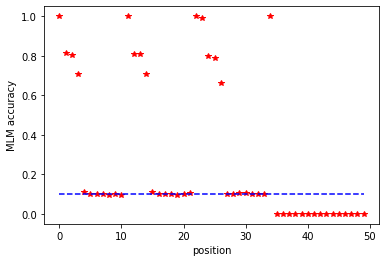

Epoch: 149 Pretraining Perplexity: 4.6615 Validation accuracy: 0.4063 Validation ppl: 4.6909 lr: 5.9999999999999995e-05


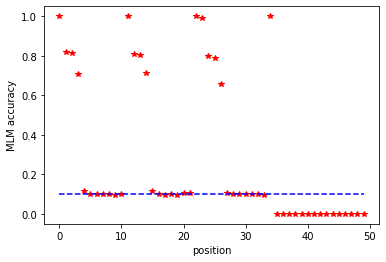

Epoch: 150 Pretraining Perplexity: 4.6671 Validation accuracy: 0.4041 Validation ppl: 4.5546 lr: 5.9999999999999995e-05


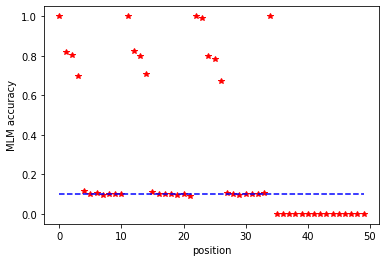

Epoch: 151 Pretraining Perplexity: 4.6672 Validation accuracy: 0.3936 Validation ppl: 4.7255 lr: 5.9999999999999995e-05


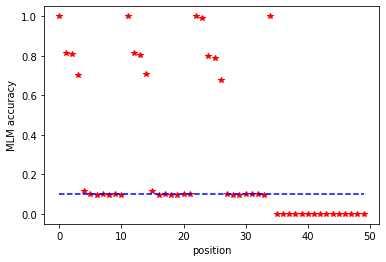

Epoch: 152 Pretraining Perplexity: 4.6542 Validation accuracy: 0.3998 Validation ppl: 4.6886 lr: 5.9999999999999995e-05


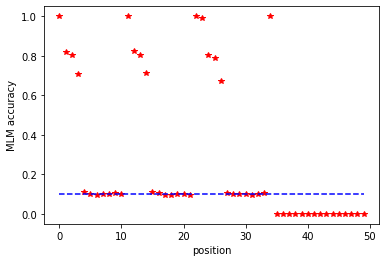

Epoch: 153 Pretraining Perplexity: 4.6503 Validation accuracy: 0.4009 Validation ppl: 4.5933 lr: 5.9999999999999995e-05


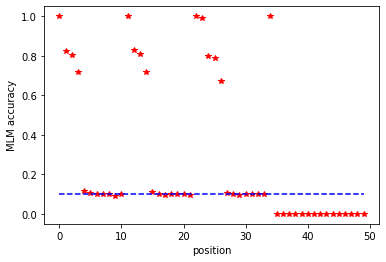

Epoch: 154 Pretraining Perplexity: 4.6433 Validation accuracy: 0.4092 Validation ppl: 4.5212 lr: 5.9999999999999995e-05


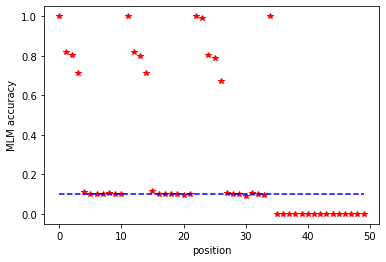

Epoch: 155 Pretraining Perplexity: 4.6611 Validation accuracy: 0.4019 Validation ppl: 4.5630 lr: 5.9999999999999995e-05


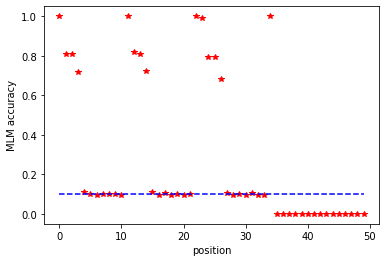

Epoch: 156 Pretraining Perplexity: 4.6316 Validation accuracy: 0.3975 Validation ppl: 4.6258 lr: 5.9999999999999995e-05


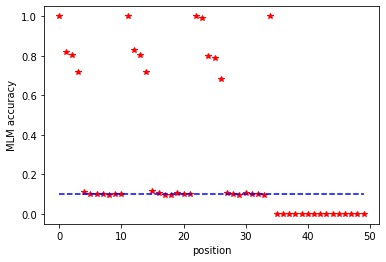

Epoch: 157 Pretraining Perplexity: 4.6527 Validation accuracy: 0.4244 Validation ppl: 4.4174 lr: 5.9999999999999995e-05


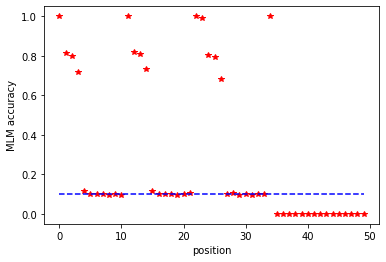

Epoch: 158 Pretraining Perplexity: 4.6533 Validation accuracy: 0.3954 Validation ppl: 4.6841 lr: 5.9999999999999995e-05


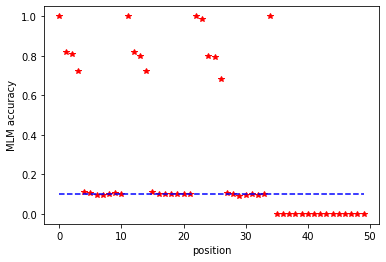

Epoch: 159 Pretraining Perplexity: 4.6466 Validation accuracy: 0.4169 Validation ppl: 4.4892 lr: 5.9999999999999995e-05


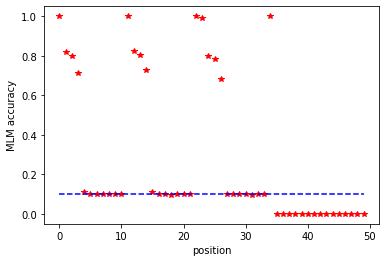

Epoch: 160 Pretraining Perplexity: 4.6387 Validation accuracy: 0.3772 Validation ppl: 4.7413 lr: 5.9999999999999995e-05


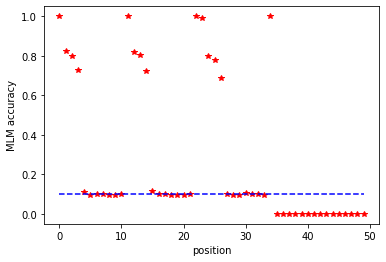

Epoch: 161 Pretraining Perplexity: 4.6376 Validation accuracy: 0.4357 Validation ppl: 4.2955 lr: 5.9999999999999995e-05


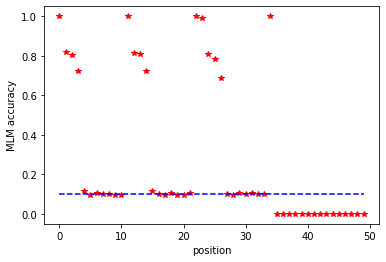

Epoch: 162 Pretraining Perplexity: 4.6506 Validation accuracy: 0.4191 Validation ppl: 4.3932 lr: 5.9999999999999995e-05


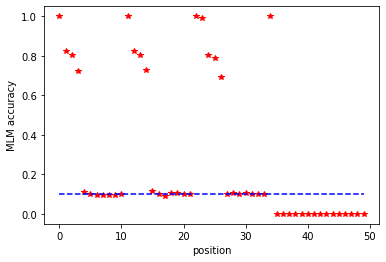

Epoch: 163 Pretraining Perplexity: 4.6468 Validation accuracy: 0.4172 Validation ppl: 4.4190 lr: 5.9999999999999995e-05


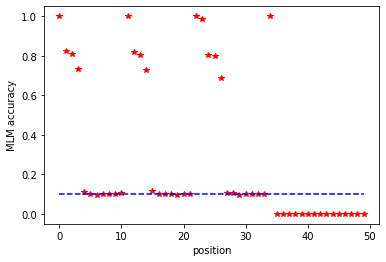

Epoch: 164 Pretraining Perplexity: 4.6470 Validation accuracy: 0.4109 Validation ppl: 4.5512 lr: 5.9999999999999995e-05


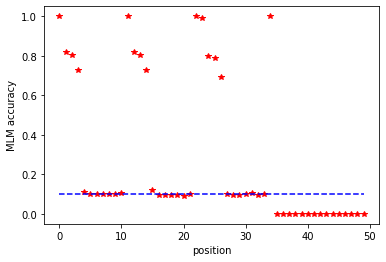

Epoch: 165 Pretraining Perplexity: 4.6287 Validation accuracy: 0.4237 Validation ppl: 4.3783 lr: 5.9999999999999995e-05


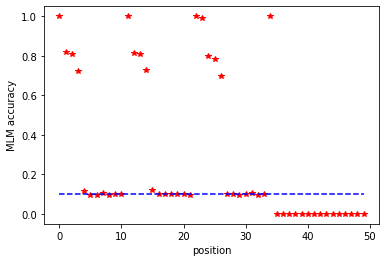

Epoch: 166 Pretraining Perplexity: 4.6391 Validation accuracy: 0.4288 Validation ppl: 4.3742 lr: 5.9999999999999995e-05


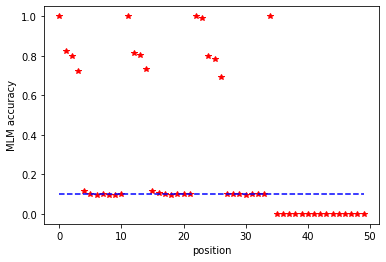

Epoch: 167 Pretraining Perplexity: 4.6422 Validation accuracy: 0.4021 Validation ppl: 4.5619 lr: 5.9999999999999995e-05


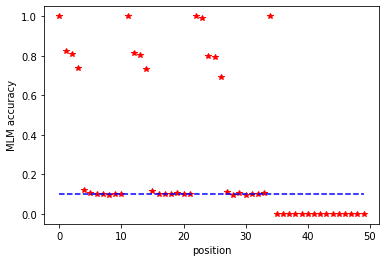

Epoch: 168 Pretraining Perplexity: 4.6440 Validation accuracy: 0.3855 Validation ppl: 4.7796 lr: 5.9999999999999995e-05


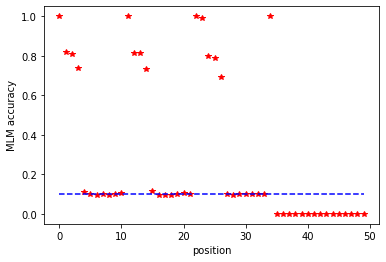

Epoch: 169 Pretraining Perplexity: 4.6394 Validation accuracy: 0.4313 Validation ppl: 4.3250 lr: 5.9999999999999995e-05


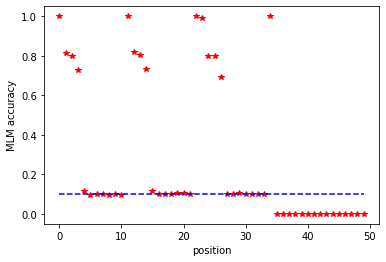

Epoch: 170 Pretraining Perplexity: 4.6330 Validation accuracy: 0.4137 Validation ppl: 4.5819 lr: 5.9999999999999995e-05


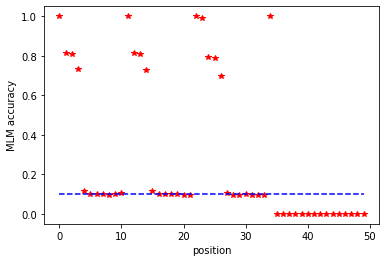

Epoch: 171 Pretraining Perplexity: 4.6227 Validation accuracy: 0.4086 Validation ppl: 4.5597 lr: 5.9999999999999995e-05


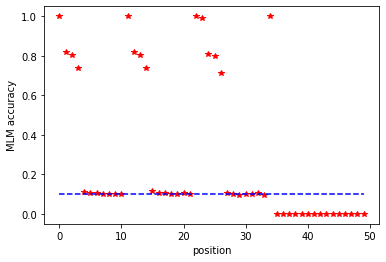

Epoch: 172 Pretraining Perplexity: 4.6218 Validation accuracy: 0.4204 Validation ppl: 4.4637 lr: 5.9999999999999995e-05


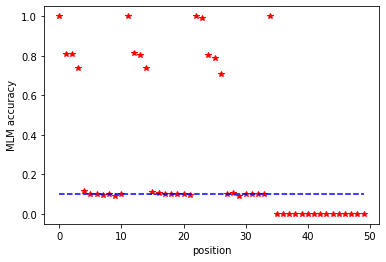

Epoch: 173 Pretraining Perplexity: 4.6254 Validation accuracy: 0.4086 Validation ppl: 4.6657 lr: 5.9999999999999995e-05


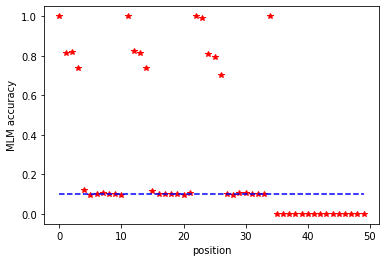

Epoch: 174 Pretraining Perplexity: 4.6277 Validation accuracy: 0.4211 Validation ppl: 4.3702 lr: 5.9999999999999995e-05


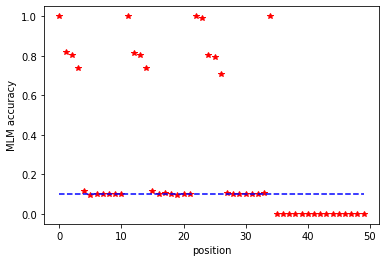

Epoch: 175 Pretraining Perplexity: 4.6297 Validation accuracy: 0.4143 Validation ppl: 4.5604 lr: 5.9999999999999995e-05


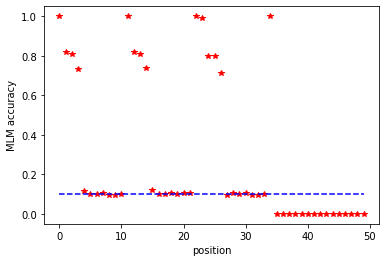

Epoch: 176 Pretraining Perplexity: 4.6274 Validation accuracy: 0.4069 Validation ppl: 4.5491 lr: 5.9999999999999995e-05


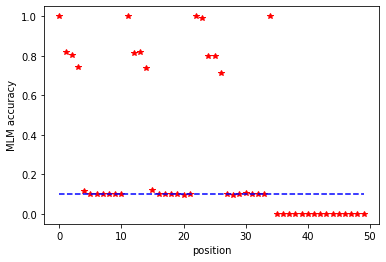

Epoch: 177 Pretraining Perplexity: 4.6185 Validation accuracy: 0.4092 Validation ppl: 4.4395 lr: 5.9999999999999995e-05


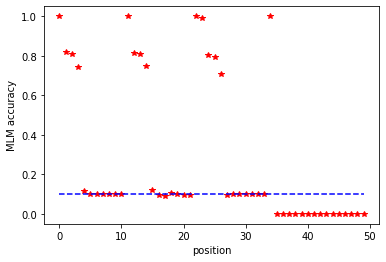

Epoch: 178 Pretraining Perplexity: 4.6221 Validation accuracy: 0.4043 Validation ppl: 4.5766 lr: 5.9999999999999995e-05


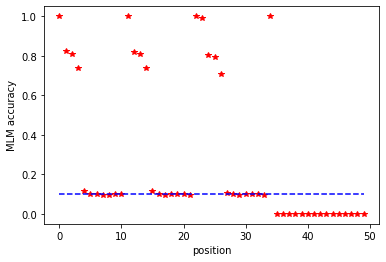

Epoch: 179 Pretraining Perplexity: 4.6114 Validation accuracy: 0.4111 Validation ppl: 4.4454 lr: 5.9999999999999995e-05


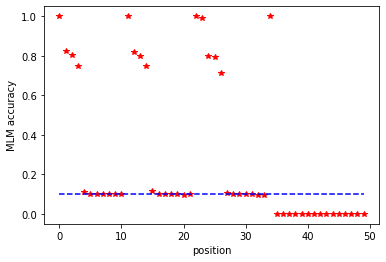

Epoch: 180 Pretraining Perplexity: 4.6222 Validation accuracy: 0.3843 Validation ppl: 4.7613 lr: 5.9999999999999995e-05


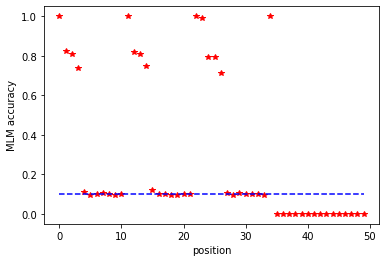

Epoch: 181 Pretraining Perplexity: 4.6102 Validation accuracy: 0.4076 Validation ppl: 4.5140 lr: 5.9999999999999995e-05


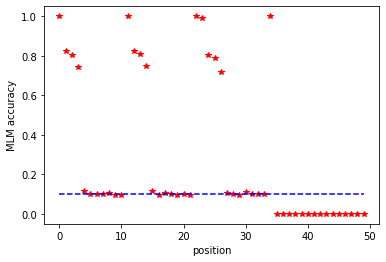

Epoch: 182 Pretraining Perplexity: 4.6119 Validation accuracy: 0.4203 Validation ppl: 4.4340 lr: 5.9999999999999995e-05


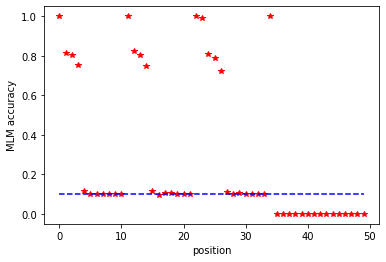

Epoch: 183 Pretraining Perplexity: 4.6014 Validation accuracy: 0.4267 Validation ppl: 4.3979 lr: 5.9999999999999995e-05


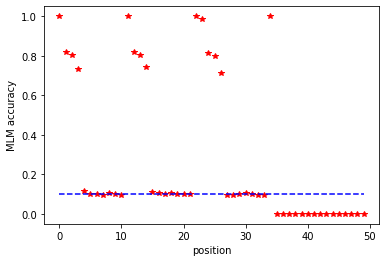

Epoch: 184 Pretraining Perplexity: 4.6139 Validation accuracy: 0.4299 Validation ppl: 4.3952 lr: 5.9999999999999995e-05


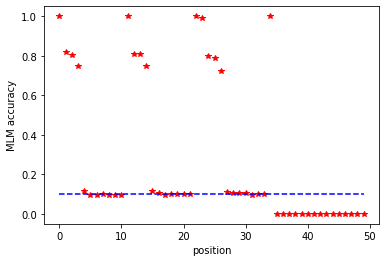

Epoch: 185 Pretraining Perplexity: 4.6043 Validation accuracy: 0.4211 Validation ppl: 4.4709 lr: 5.9999999999999995e-05


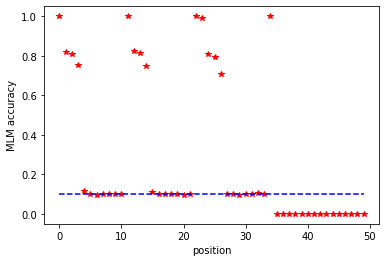

Epoch: 186 Pretraining Perplexity: 4.6046 Validation accuracy: 0.4191 Validation ppl: 4.3941 lr: 5.9999999999999995e-05


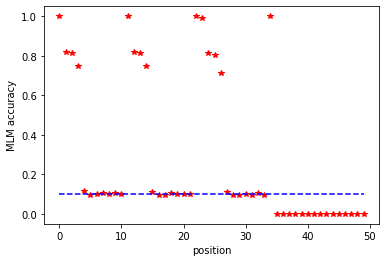

Epoch: 187 Pretraining Perplexity: 4.5932 Validation accuracy: 0.4058 Validation ppl: 4.5489 lr: 5.9999999999999995e-05


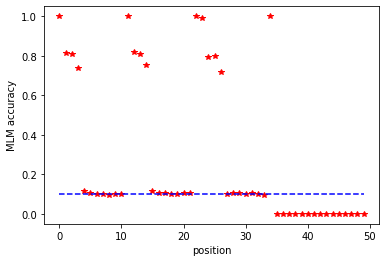

Epoch: 188 Pretraining Perplexity: 4.6021 Validation accuracy: 0.4116 Validation ppl: 4.4687 lr: 5.9999999999999995e-05


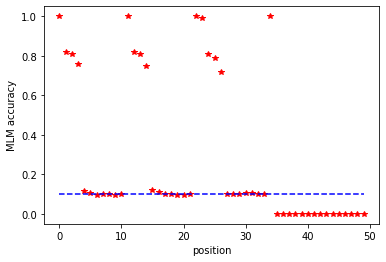

Epoch: 189 Pretraining Perplexity: 4.6070 Validation accuracy: 0.4210 Validation ppl: 4.4653 lr: 6.243268906874293e-05


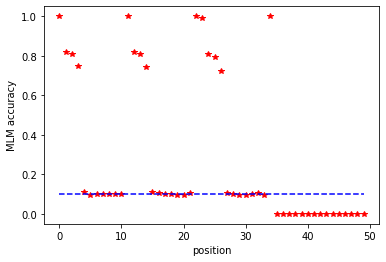

Epoch: 190 Pretraining Perplexity: 4.6148 Validation accuracy: 0.4077 Validation ppl: 4.5210 lr: 6.614250575370899e-05


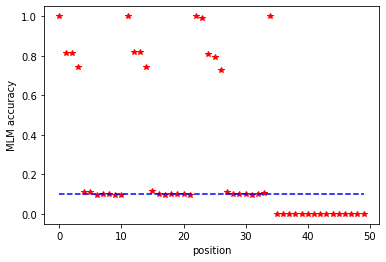

Epoch: 191 Pretraining Perplexity: 4.6102 Validation accuracy: 0.4267 Validation ppl: 4.3592 lr: 6.994579137838164e-05


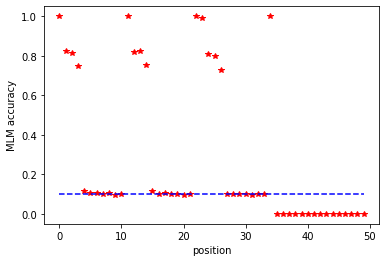

Epoch: 192 Pretraining Perplexity: 4.5887 Validation accuracy: 0.4263 Validation ppl: 4.5097 lr: 7.384102583293566e-05


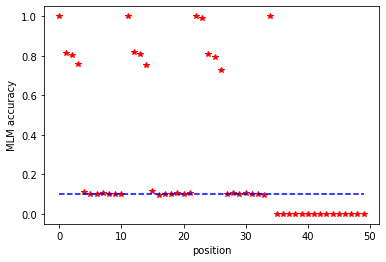

Epoch: 193 Pretraining Perplexity: 4.6104 Validation accuracy: 0.4364 Validation ppl: 4.2597 lr: 7.782660587166712e-05


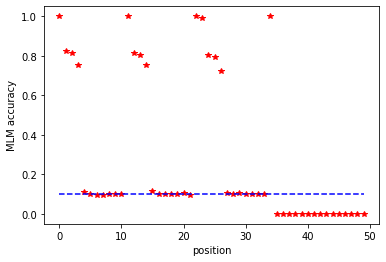

Epoch: 194 Pretraining Perplexity: 4.6038 Validation accuracy: 0.4083 Validation ppl: 4.5528 lr: 8.190098286624762e-05


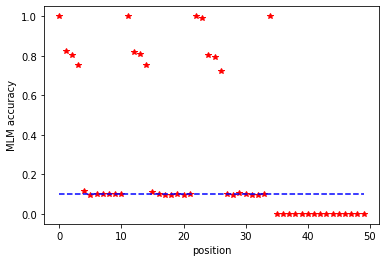

Epoch: 195 Pretraining Perplexity: 4.6085 Validation accuracy: 0.4308 Validation ppl: 4.4756 lr: 8.606252839363606e-05


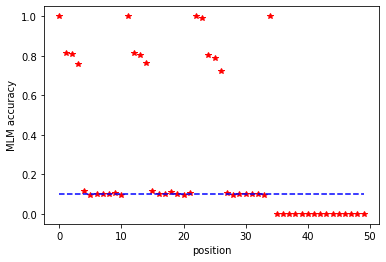

Epoch: 196 Pretraining Perplexity: 4.5953 Validation accuracy: 0.4160 Validation ppl: 4.6505 lr: 9.030957919178476e-05


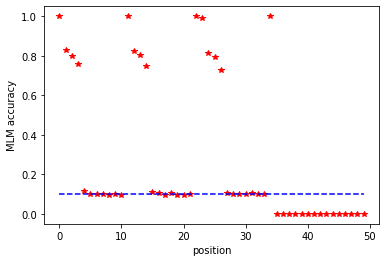

Epoch: 197 Pretraining Perplexity: 4.6007 Validation accuracy: 0.4268 Validation ppl: 4.3581 lr: 9.464043782440222e-05


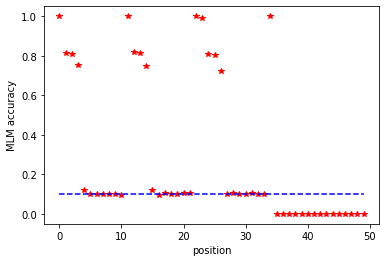

Epoch: 198 Pretraining Perplexity: 4.5918 Validation accuracy: 0.4143 Validation ppl: 4.5259 lr: 9.905337335937421e-05


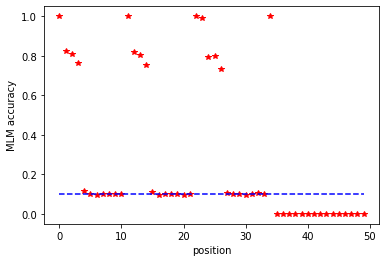

Epoch: 199 Pretraining Perplexity: 4.5820 Validation accuracy: 0.4318 Validation ppl: 4.3460 lr: 0.00010354662206057314


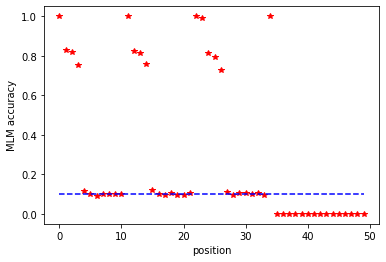

Epoch: 200 Pretraining Perplexity: 4.6006 Validation accuracy: 0.4045 Validation ppl: 4.5988 lr: 0.00010811838809277714


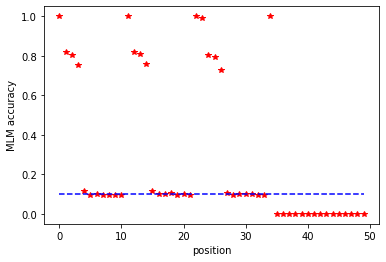

Epoch: 201 Pretraining Perplexity: 4.6059 Validation accuracy: 0.4085 Validation ppl: 4.5184 lr: 0.00011276684423941894


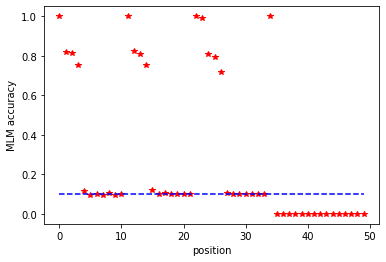

Epoch: 202 Pretraining Perplexity: 4.5977 Validation accuracy: 0.3922 Validation ppl: 4.7652 lr: 0.00011749013263287752


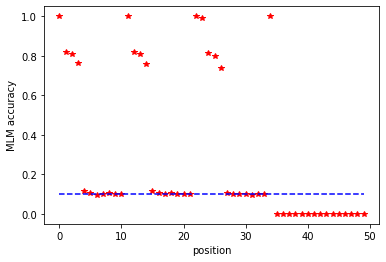

Epoch: 203 Pretraining Perplexity: 4.5871 Validation accuracy: 0.3926 Validation ppl: 4.5930 lr: 0.0001222863654970194


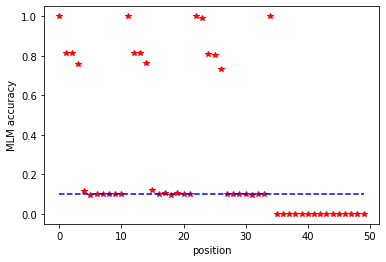

Epoch: 204 Pretraining Perplexity: 4.5872 Validation accuracy: 0.4256 Validation ppl: 4.3567 lr: 0.00012715362590169394


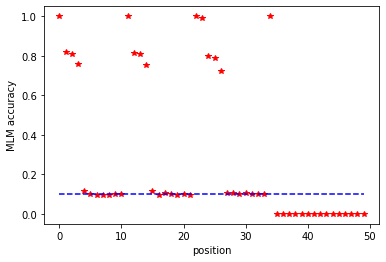

Epoch: 205 Pretraining Perplexity: 4.5927 Validation accuracy: 0.4205 Validation ppl: 4.4019 lr: 0.00013208996852888066


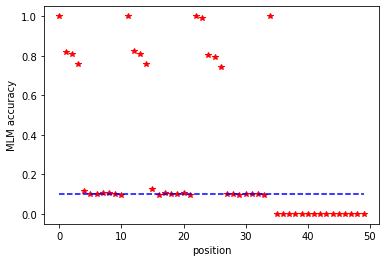

Epoch: 206 Pretraining Perplexity: 4.5989 Validation accuracy: 0.3956 Validation ppl: 4.6315 lr: 0.00013709342045018264


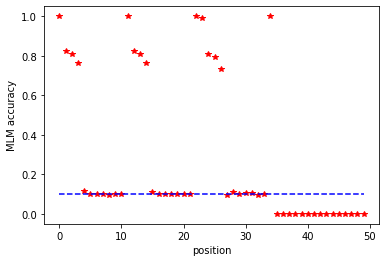

Epoch: 207 Pretraining Perplexity: 4.5858 Validation accuracy: 0.4023 Validation ppl: 4.5202 lr: 0.00014216198191535482


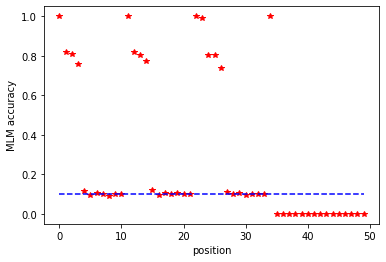

Epoch: 208 Pretraining Perplexity: 4.6045 Validation accuracy: 0.4220 Validation ppl: 4.3964 lr: 0.00014729362715155253


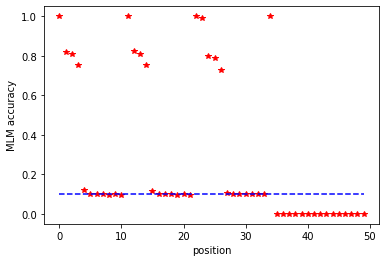

Epoch: 209 Pretraining Perplexity: 4.5932 Validation accuracy: 0.3980 Validation ppl: 4.8031 lr: 0.00015248630517298038


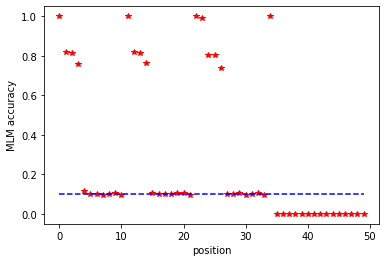

Epoch: 210 Pretraining Perplexity: 4.5964 Validation accuracy: 0.4271 Validation ppl: 4.3774 lr: 0.00015773794060061817


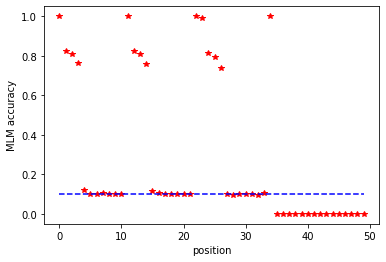

Epoch: 211 Pretraining Perplexity: 4.5879 Validation accuracy: 0.4221 Validation ppl: 4.3452 lr: 0.00016304643449169642


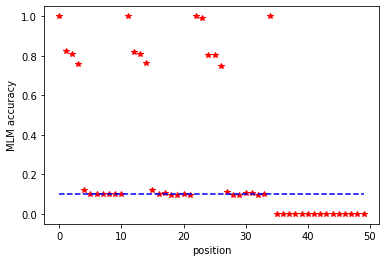

Epoch: 212 Pretraining Perplexity: 4.5815 Validation accuracy: 0.4078 Validation ppl: 4.6148 lr: 0.00016840966517858903


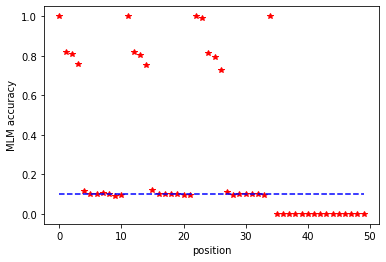

Epoch: 213 Pretraining Perplexity: 4.5944 Validation accuracy: 0.4106 Validation ppl: 4.4856 lr: 0.0001738254891167894


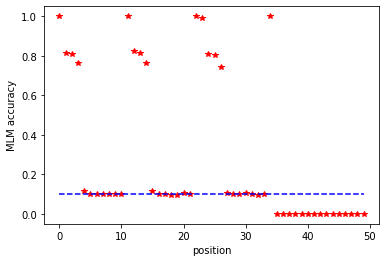

Epoch: 214 Pretraining Perplexity: 4.5720 Validation accuracy: 0.4084 Validation ppl: 4.6566 lr: 0.00017929174174162948


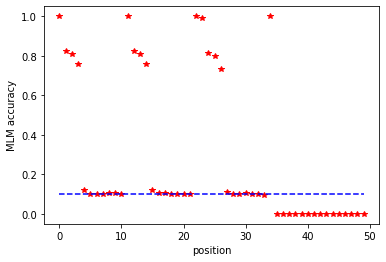

Epoch: 215 Pretraining Perplexity: 4.5919 Validation accuracy: 0.4121 Validation ppl: 4.5039 lr: 0.00018480623833340006


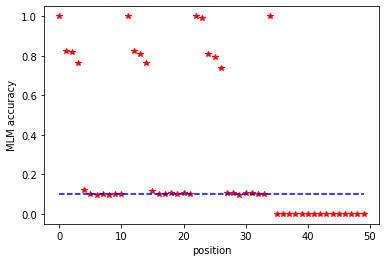

Epoch: 216 Pretraining Perplexity: 4.5857 Validation accuracy: 0.3969 Validation ppl: 4.6487 lr: 0.00019036677489052704


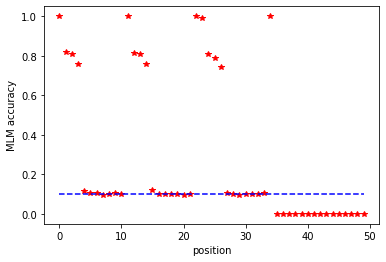

Epoch: 217 Pretraining Perplexity: 4.5856 Validation accuracy: 0.4149 Validation ppl: 4.4758 lr: 0.0001959711290104537


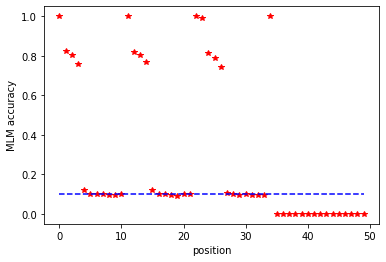

Epoch: 218 Pretraining Perplexity: 4.5829 Validation accuracy: 0.4073 Validation ppl: 4.4177 lr: 0.00020161706077787735


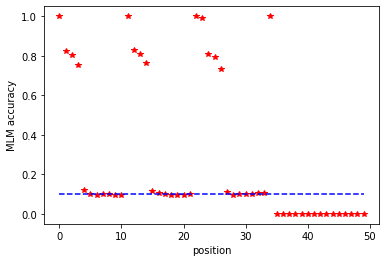

Epoch: 219 Pretraining Perplexity: 4.5776 Validation accuracy: 0.4521 Validation ppl: 4.2298 lr: 0.00020730231365998565


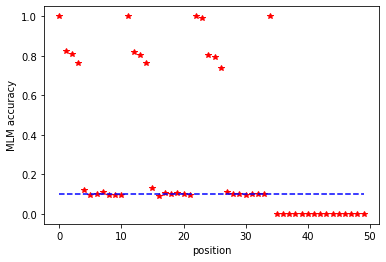

Epoch: 220 Pretraining Perplexity: 4.5844 Validation accuracy: 0.4061 Validation ppl: 4.5772 lr: 0.00021302461540833434


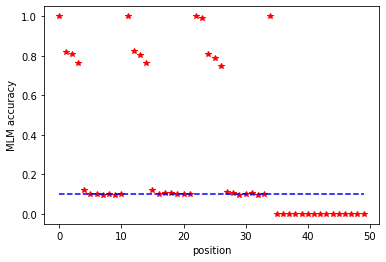

Epoch: 221 Pretraining Perplexity: 4.5800 Validation accuracy: 0.4229 Validation ppl: 4.3330 lr: 0.0002187816789670062


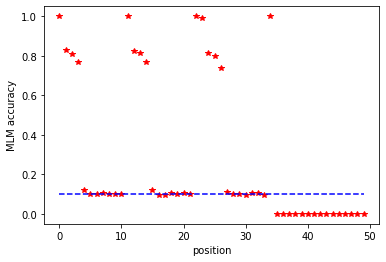

Epoch: 222 Pretraining Perplexity: 4.5656 Validation accuracy: 0.4151 Validation ppl: 4.5620 lr: 0.00022457120338668793


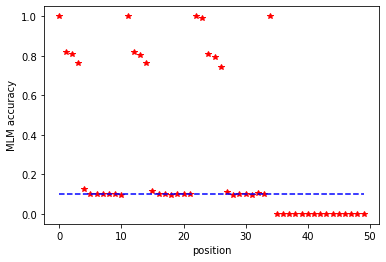

Epoch: 223 Pretraining Perplexity: 4.5795 Validation accuracy: 0.4135 Validation ppl: 4.4676 lr: 0.00023039087474430024


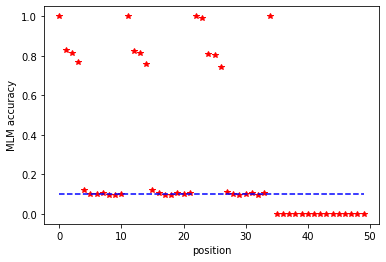

Epoch: 224 Pretraining Perplexity: 4.5783 Validation accuracy: 0.4167 Validation ppl: 4.4213 lr: 0.00023623836706781294


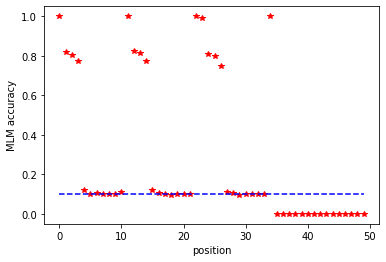

Epoch: 225 Pretraining Perplexity: 4.5560 Validation accuracy: 0.4198 Validation ppl: 4.3719 lr: 0.00024211134326587573


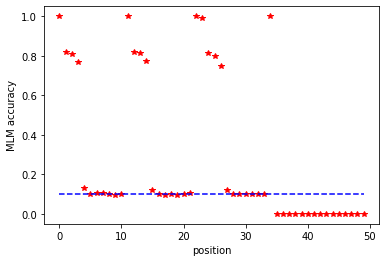

Epoch: 226 Pretraining Perplexity: 4.5732 Validation accuracy: 0.4211 Validation ppl: 4.3368 lr: 0.00024800745606189323


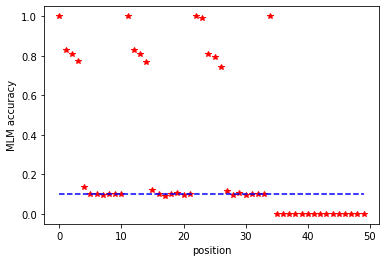

Epoch: 227 Pretraining Perplexity: 4.5829 Validation accuracy: 0.4332 Validation ppl: 4.4550 lr: 0.0002539243489321706


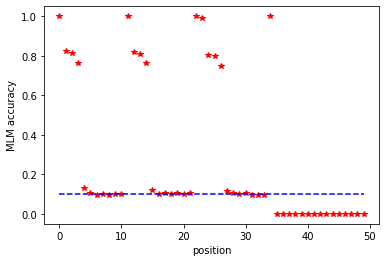

Epoch: 228 Pretraining Perplexity: 4.5693 Validation accuracy: 0.4025 Validation ppl: 4.5797 lr: 0.000259859657047755


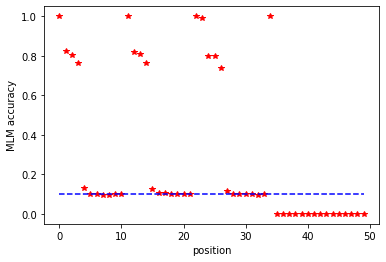

Epoch: 229 Pretraining Perplexity: 4.5706 Validation accuracy: 0.3949 Validation ppl: 4.6096 lr: 0.00026581100821959684


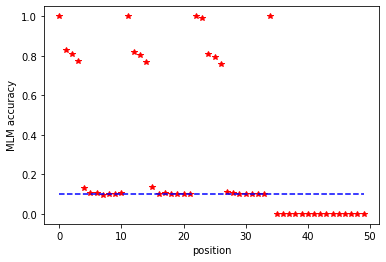

Epoch: 230 Pretraining Perplexity: 4.5662 Validation accuracy: 0.4013 Validation ppl: 4.4662 lr: 0.0002717760238466519


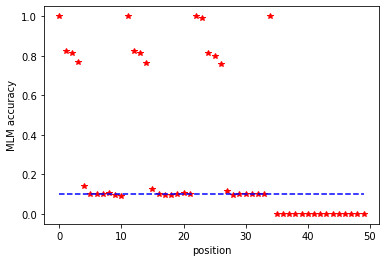

Epoch: 231 Pretraining Perplexity: 4.5689 Validation accuracy: 0.4206 Validation ppl: 4.4418 lr: 0.000277752319866547


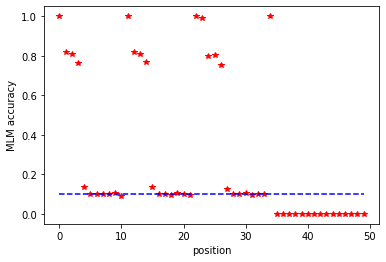

Epoch: 232 Pretraining Perplexity: 4.5641 Validation accuracy: 0.4170 Validation ppl: 4.3910 lr: 0.00028373750770842787


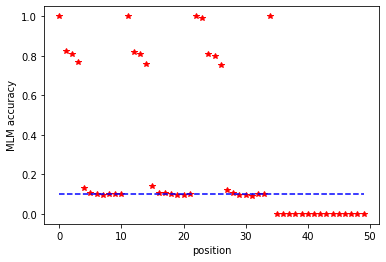

Epoch: 233 Pretraining Perplexity: 4.5781 Validation accuracy: 0.4187 Validation ppl: 4.4645 lr: 0.00028972919524760895


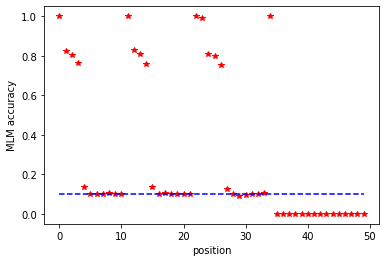

Epoch: 234 Pretraining Perplexity: 4.5646 Validation accuracy: 0.4423 Validation ppl: 4.2374 lr: 0.0002957249877616441


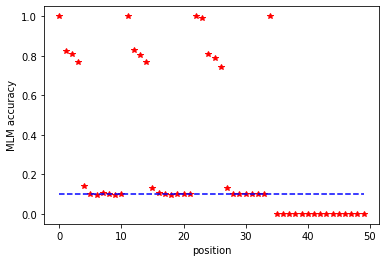

Epoch: 235 Pretraining Perplexity: 4.5639 Validation accuracy: 0.3992 Validation ppl: 4.6151 lr: 0.0003017224888874348


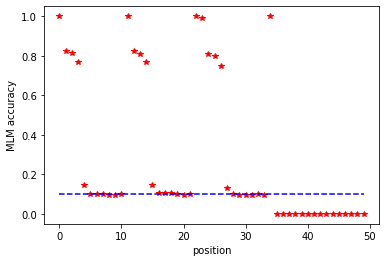

Epoch: 236 Pretraining Perplexity: 4.5466 Validation accuracy: 0.4043 Validation ppl: 4.6036 lr: 0.00030771930157899477


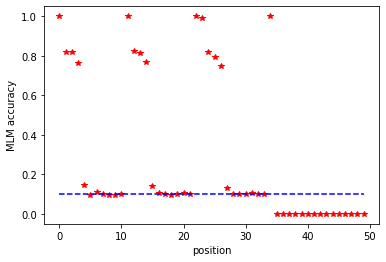

Epoch: 237 Pretraining Perplexity: 4.5443 Validation accuracy: 0.4331 Validation ppl: 4.2858 lr: 0.0003137130290654872


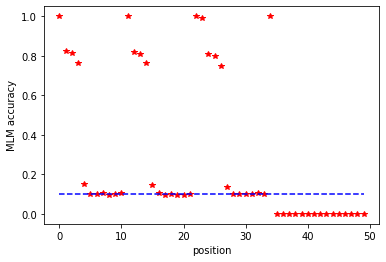

Epoch: 238 Pretraining Perplexity: 4.5419 Validation accuracy: 0.4465 Validation ppl: 4.3676 lr: 0.0003197012758091508


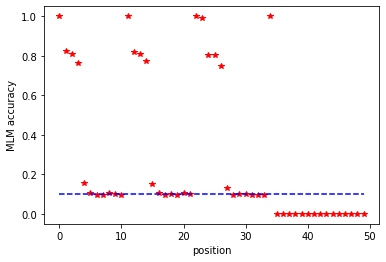

Epoch: 239 Pretraining Perplexity: 4.5451 Validation accuracy: 0.4165 Validation ppl: 4.4302 lr: 0.00032568164846273726


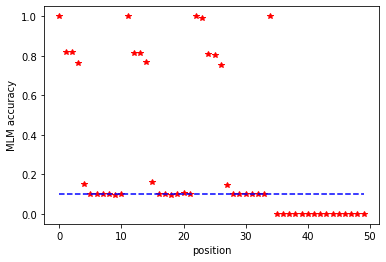

Epoch: 240 Pretraining Perplexity: 4.5503 Validation accuracy: 0.4310 Validation ppl: 4.4699 lr: 0.00033165175682606685


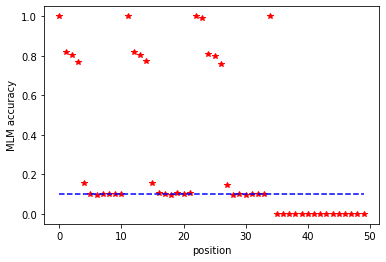

Epoch: 241 Pretraining Perplexity: 4.5380 Validation accuracy: 0.4239 Validation ppl: 4.4160 lr: 0.00033760921480133156


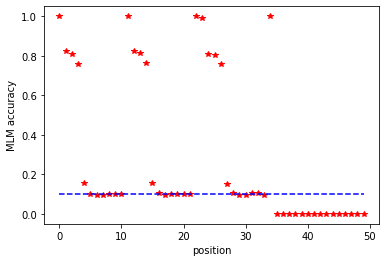

Epoch: 242 Pretraining Perplexity: 4.5253 Validation accuracy: 0.4379 Validation ppl: 4.2670 lr: 0.00034355164134675586


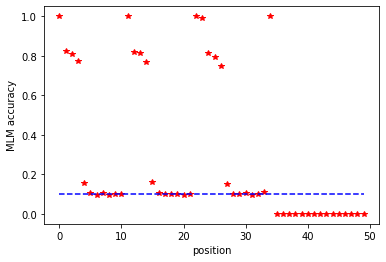

Epoch: 243 Pretraining Perplexity: 4.5454 Validation accuracy: 0.4287 Validation ppl: 4.3798 lr: 0.00034947666142823796


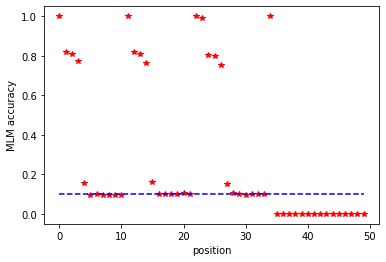

Epoch: 244 Pretraining Perplexity: 4.5309 Validation accuracy: 0.4440 Validation ppl: 4.0930 lr: 0.0003553819069685891


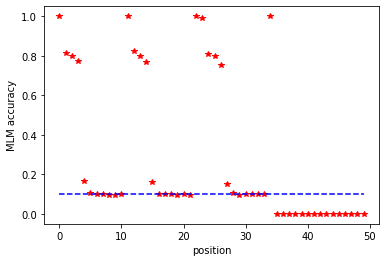

Epoch: 245 Pretraining Perplexity: 4.5299 Validation accuracy: 0.4373 Validation ppl: 4.3257 lr: 0.0003612650177939929


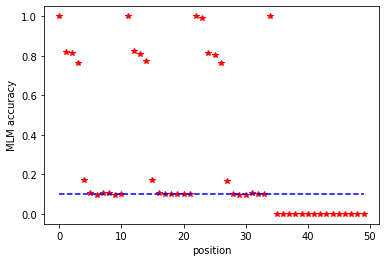

Epoch: 246 Pretraining Perplexity: 4.5180 Validation accuracy: 0.4542 Validation ppl: 4.2167 lr: 0.00036712364257730556


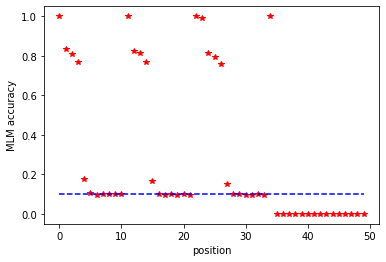

Epoch: 247 Pretraining Perplexity: 4.5208 Validation accuracy: 0.4258 Validation ppl: 4.2636 lr: 0.00037295543977782083


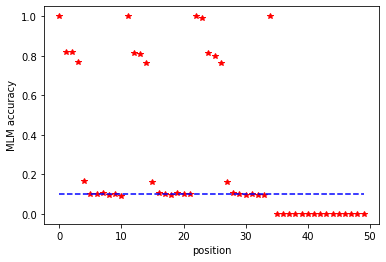

Epoch: 248 Pretraining Perplexity: 4.5254 Validation accuracy: 0.4191 Validation ppl: 4.3729 lr: 0.00037875807857712287


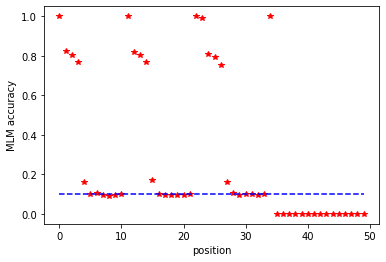

Epoch: 249 Pretraining Perplexity: 4.4998 Validation accuracy: 0.4193 Validation ppl: 4.3338 lr: 0.0003845292398106543


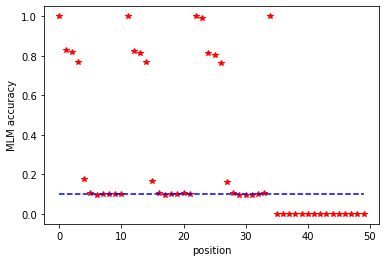

Epoch: 250 Pretraining Perplexity: 4.5009 Validation accuracy: 0.4185 Validation ppl: 4.3366 lr: 0.00039026661689462605


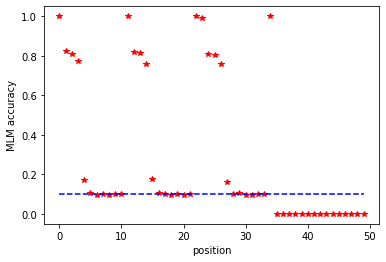

Epoch: 251 Pretraining Perplexity: 4.5112 Validation accuracy: 0.4107 Validation ppl: 4.4467 lr: 0.00039596791674789927


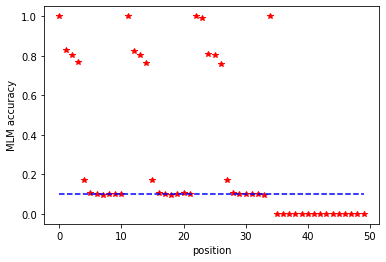

Epoch: 252 Pretraining Perplexity: 4.5036 Validation accuracy: 0.4223 Validation ppl: 4.3315 lr: 0.0004016308607084708


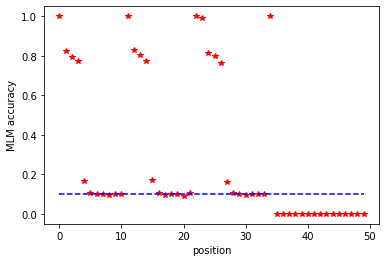

Epoch: 253 Pretraining Perplexity: 4.4908 Validation accuracy: 0.4285 Validation ppl: 4.2637 lr: 0.0004072531854441948


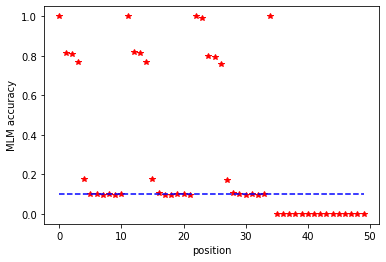

Epoch: 254 Pretraining Perplexity: 4.4899 Validation accuracy: 0.4244 Validation ppl: 4.3637 lr: 0.0004128326438573786


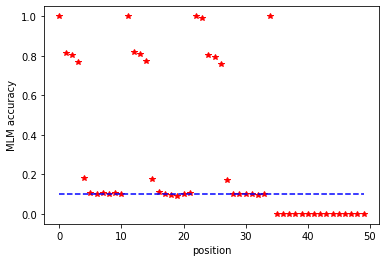

Epoch: 255 Pretraining Perplexity: 4.5020 Validation accuracy: 0.4318 Validation ppl: 4.4887 lr: 0.00041836700598288953


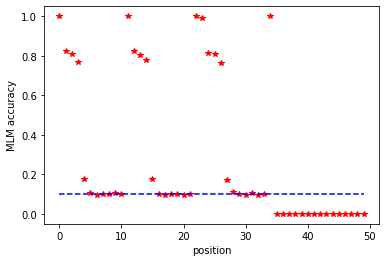

Epoch: 256 Pretraining Perplexity: 4.4916 Validation accuracy: 0.4052 Validation ppl: 4.4664 lr: 0.0004238540598794132


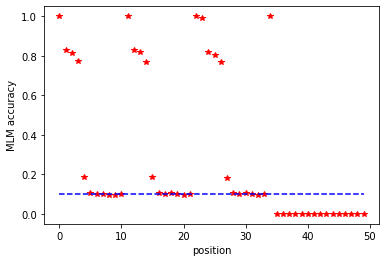

Epoch: 257 Pretraining Perplexity: 4.4817 Validation accuracy: 0.4092 Validation ppl: 4.5381 lr: 0.0004292916125135109


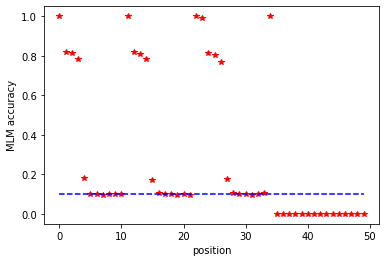

Epoch: 258 Pretraining Perplexity: 4.4823 Validation accuracy: 0.4269 Validation ppl: 4.4389 lr: 0.00043467749063611676


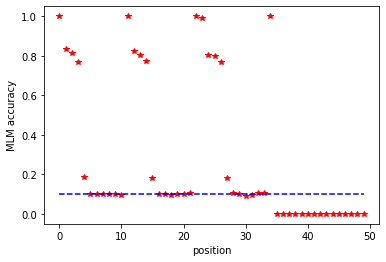

Epoch: 259 Pretraining Perplexity: 4.4760 Validation accuracy: 0.4438 Validation ppl: 4.2148 lr: 0.0004400095416511307


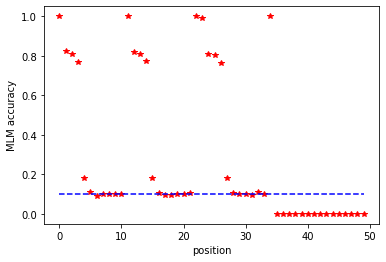

Epoch: 260 Pretraining Perplexity: 4.4791 Validation accuracy: 0.4550 Validation ppl: 4.1094 lr: 0.00044528563447575364


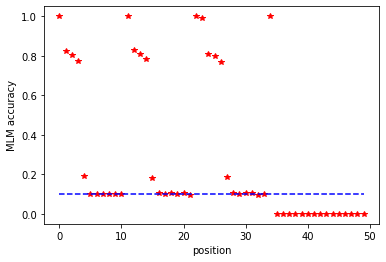

Epoch: 261 Pretraining Perplexity: 4.4727 Validation accuracy: 0.4370 Validation ppl: 4.1601 lr: 0.0004505036603922275


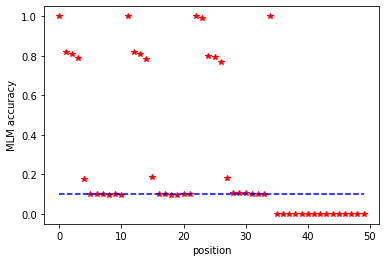

Epoch: 262 Pretraining Perplexity: 4.4826 Validation accuracy: 0.4260 Validation ppl: 4.3015 lr: 0.0004556615338906344


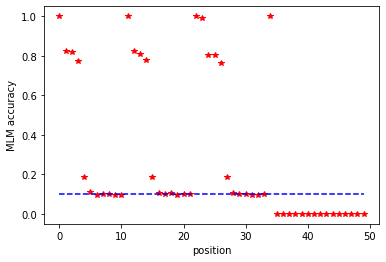

Epoch: 263 Pretraining Perplexity: 4.4848 Validation accuracy: 0.4224 Validation ppl: 4.4233 lr: 0.00046075719350242123


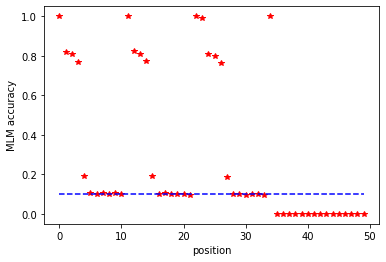

Epoch: 264 Pretraining Perplexity: 4.4693 Validation accuracy: 0.4193 Validation ppl: 4.3495 lr: 0.00046578860262431565


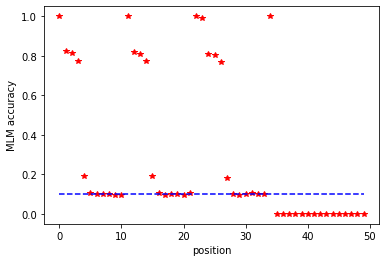

Epoch: 265 Pretraining Perplexity: 4.4716 Validation accuracy: 0.4393 Validation ppl: 4.2178 lr: 0.0004707537503323028


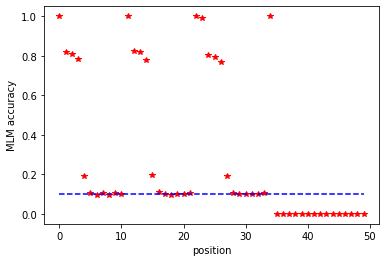

Epoch: 266 Pretraining Perplexity: 4.4656 Validation accuracy: 0.4288 Validation ppl: 4.3531 lr: 0.0004756506521853406


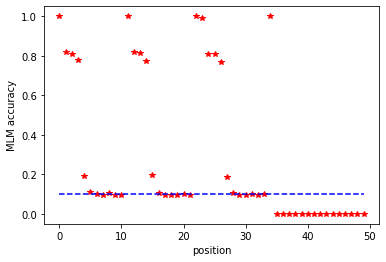

Epoch: 267 Pretraining Perplexity: 4.4641 Validation accuracy: 0.4235 Validation ppl: 4.3041 lr: 0.00048047735101848873


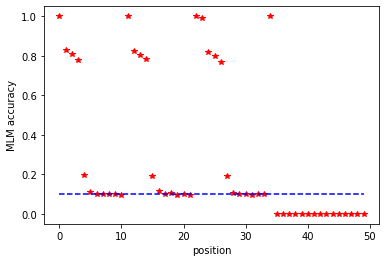

Epoch: 268 Pretraining Perplexity: 4.4497 Validation accuracy: 0.4180 Validation ppl: 4.4268 lr: 0.0004852319177251371


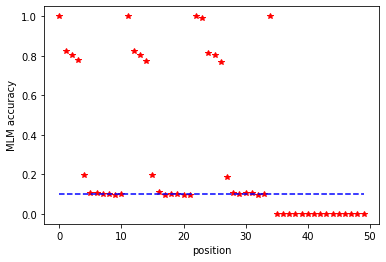

Epoch: 269 Pretraining Perplexity: 4.4540 Validation accuracy: 0.3995 Validation ppl: 4.5391 lr: 0.00048991245202802


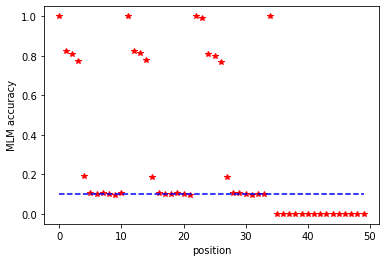

Epoch: 270 Pretraining Perplexity: 4.4667 Validation accuracy: 0.4305 Validation ppl: 4.2783 lr: 0.0004945170832387074


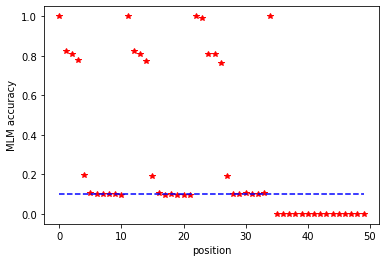

Epoch: 271 Pretraining Perplexity: 4.4472 Validation accuracy: 0.4250 Validation ppl: 4.2965 lr: 0.000499043971005271


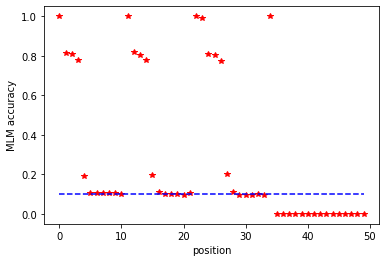

Epoch: 272 Pretraining Perplexity: 4.4456 Validation accuracy: 0.4178 Validation ppl: 4.4545 lr: 0.000503491306047825


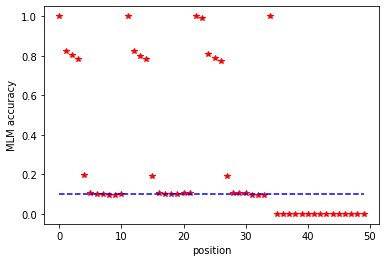

Epoch: 273 Pretraining Perplexity: 4.4439 Validation accuracy: 0.4192 Validation ppl: 4.3429 lr: 0.0005078573108816489


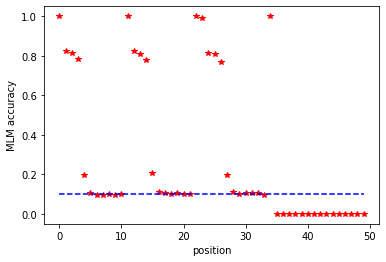

Epoch: 274 Pretraining Perplexity: 4.4322 Validation accuracy: 0.4440 Validation ppl: 4.1714 lr: 0.0005121402405276011


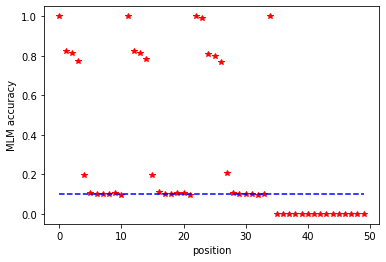

Epoch: 275 Pretraining Perplexity: 4.4346 Validation accuracy: 0.4300 Validation ppl: 4.3158 lr: 0.0005163383832095435


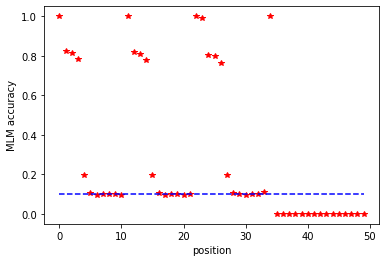

Epoch: 276 Pretraining Perplexity: 4.4628 Validation accuracy: 0.4342 Validation ppl: 4.3019 lr: 0.0005204500610384926


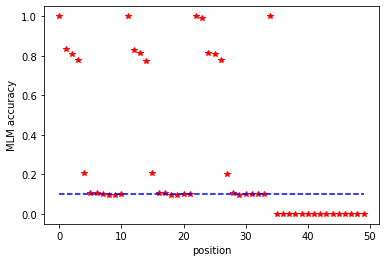

Epoch: 277 Pretraining Perplexity: 4.4215 Validation accuracy: 0.4049 Validation ppl: 4.4927 lr: 0.0005244736306832295


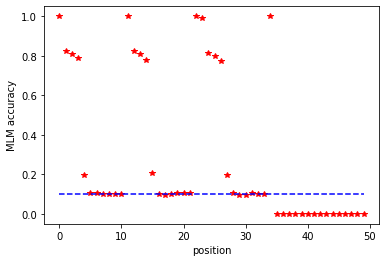

Epoch: 278 Pretraining Perplexity: 4.4441 Validation accuracy: 0.4262 Validation ppl: 4.2559 lr: 0.0005284074840270956


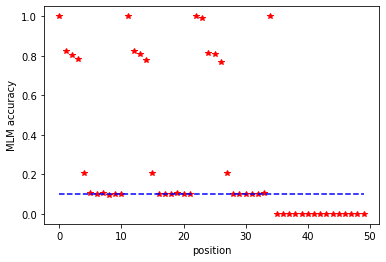

Epoch: 279 Pretraining Perplexity: 4.4328 Validation accuracy: 0.4207 Validation ppl: 4.3696 lr: 0.0005322500488107168


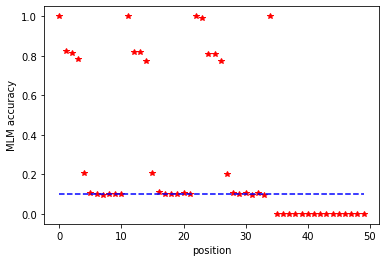

Epoch: 280 Pretraining Perplexity: 4.4347 Validation accuracy: 0.4354 Validation ppl: 4.2987 lr: 0.0005359997892603935


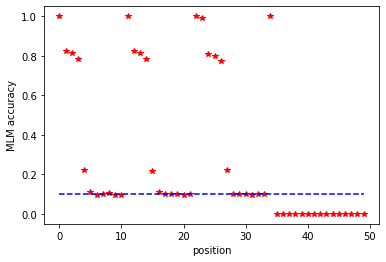

Epoch: 281 Pretraining Perplexity: 4.4175 Validation accuracy: 0.4391 Validation ppl: 4.1167 lr: 0.0005396552067019101


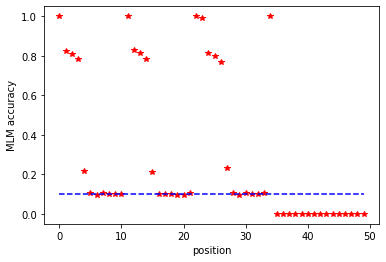

Epoch: 282 Pretraining Perplexity: 4.4057 Validation accuracy: 0.4108 Validation ppl: 4.3658 lr: 0.0005432148401595164


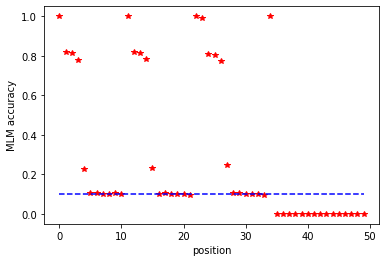

Epoch: 283 Pretraining Perplexity: 4.3914 Validation accuracy: 0.4500 Validation ppl: 4.1353 lr: 0.0005466772669398416


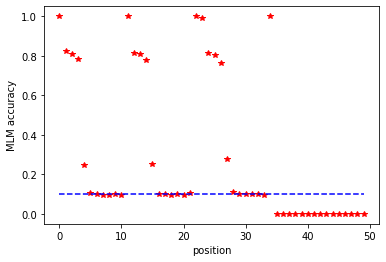

Epoch: 284 Pretraining Perplexity: 4.3830 Validation accuracy: 0.4369 Validation ppl: 4.1602 lr: 0.0005500411032005084


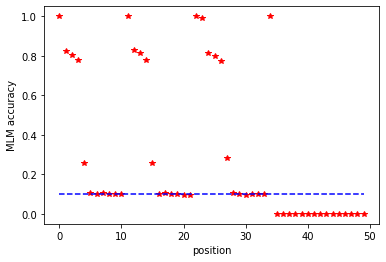

Epoch: 285 Pretraining Perplexity: 4.3768 Validation accuracy: 0.4437 Validation ppl: 4.1479 lr: 0.0005533050045032184


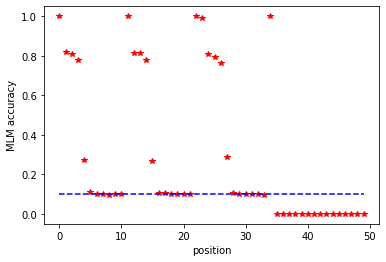

Epoch: 286 Pretraining Perplexity: 4.3750 Validation accuracy: 0.4441 Validation ppl: 4.1742 lr: 0.0005564676663510898


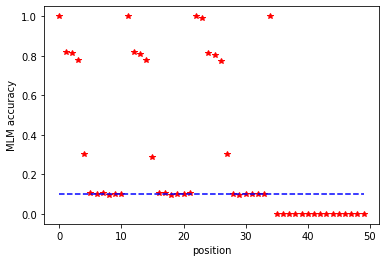

Epoch: 287 Pretraining Perplexity: 4.3464 Validation accuracy: 0.4451 Validation ppl: 4.1052 lr: 0.0005595278247100306


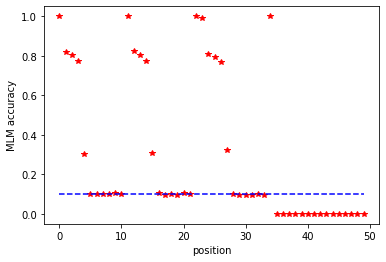

Epoch: 288 Pretraining Perplexity: 4.3428 Validation accuracy: 0.4602 Validation ppl: 3.9506 lr: 0.0005624842565139411


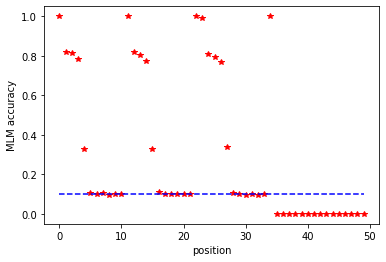

Epoch: 289 Pretraining Perplexity: 4.3009 Validation accuracy: 0.4569 Validation ppl: 3.9581 lr: 0.0005653357801535407


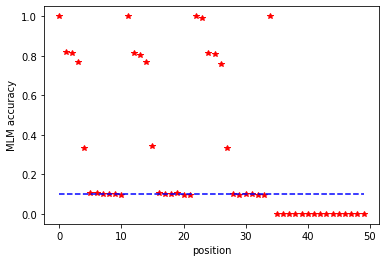

Epoch: 290 Pretraining Perplexity: 4.3097 Validation accuracy: 0.4455 Validation ppl: 4.0276 lr: 0.0005680812559486272


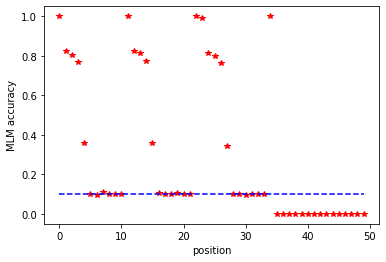

Epoch: 291 Pretraining Perplexity: 4.3014 Validation accuracy: 0.4602 Validation ppl: 4.0129 lr: 0.0005707195866035778


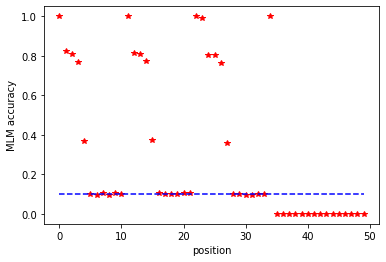

Epoch: 292 Pretraining Perplexity: 4.2815 Validation accuracy: 0.4504 Validation ppl: 4.0727 lr: 0.0005732497176459085


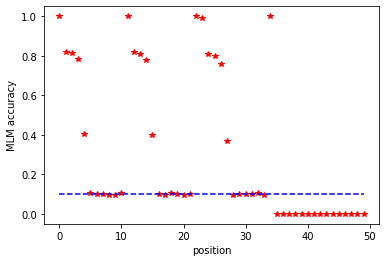

Epoch: 293 Pretraining Perplexity: 4.2597 Validation accuracy: 0.4422 Validation ppl: 4.1315 lr: 0.0005756706378477208


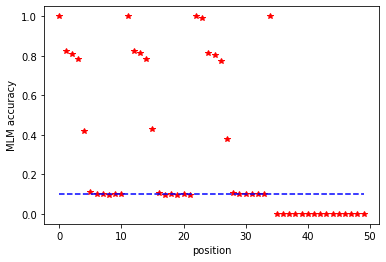

Epoch: 294 Pretraining Perplexity: 4.2241 Validation accuracy: 0.4611 Validation ppl: 4.0191 lr: 0.000577981379629863


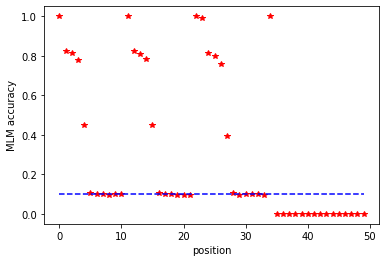

Epoch: 295 Pretraining Perplexity: 4.1968 Validation accuracy: 0.4666 Validation ppl: 4.0678 lr: 0.0005801810194486461


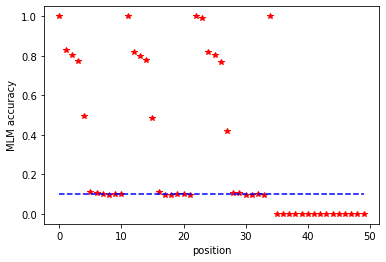

Epoch: 296 Pretraining Perplexity: 4.1872 Validation accuracy: 0.4301 Validation ppl: 4.1674 lr: 0.0005822686781649604


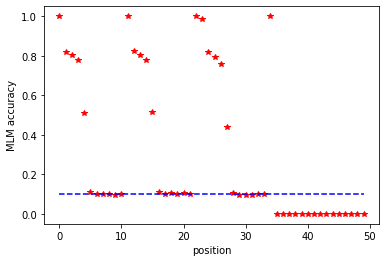

Epoch: 297 Pretraining Perplexity: 4.1741 Validation accuracy: 0.4540 Validation ppl: 3.8476 lr: 0.000584243521395645


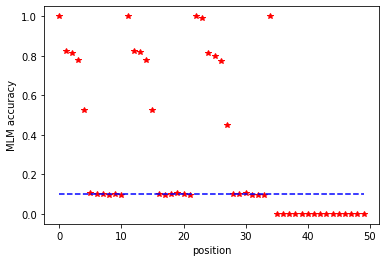

Epoch: 298 Pretraining Perplexity: 4.1442 Validation accuracy: 0.4503 Validation ppl: 4.0586 lr: 0.0005861047598469693


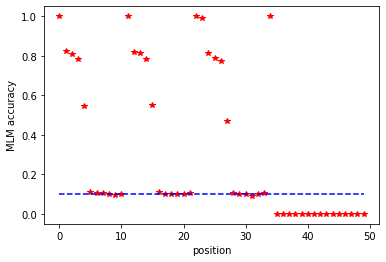

Epoch: 299 Pretraining Perplexity: 4.1428 Validation accuracy: 0.4617 Validation ppl: 4.0488 lr: 0.0005878516496300923


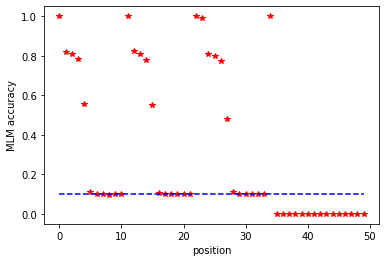

Epoch: 300 Pretraining Perplexity: 4.1288 Validation accuracy: 0.4695 Validation ppl: 3.8365 lr: 0.0005894834925583767


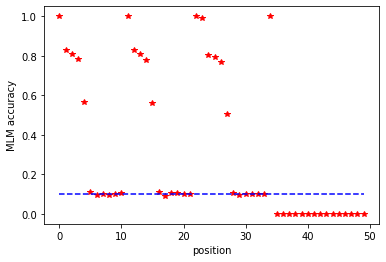

Epoch: 301 Pretraining Perplexity: 4.1138 Validation accuracy: 0.4434 Validation ppl: 4.1133 lr: 0.0005909996364264359


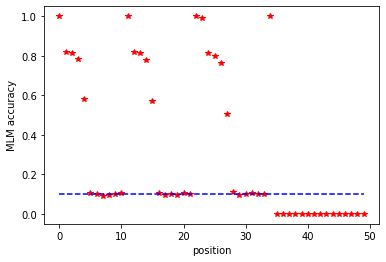

Epoch: 302 Pretraining Perplexity: 4.1141 Validation accuracy: 0.4738 Validation ppl: 3.9026 lr: 0.0005923994752708031


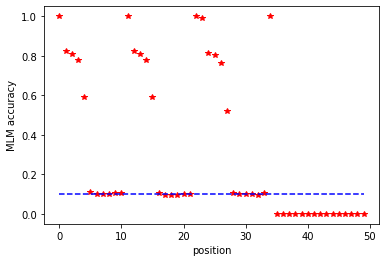

Epoch: 303 Pretraining Perplexity: 4.0954 Validation accuracy: 0.4396 Validation ppl: 4.1435 lr: 0.0005936824496121196


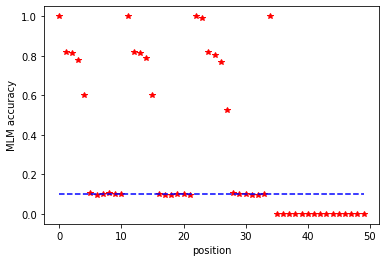

Epoch: 304 Pretraining Perplexity: 4.0842 Validation accuracy: 0.4750 Validation ppl: 3.7973 lr: 0.0005948480466787442


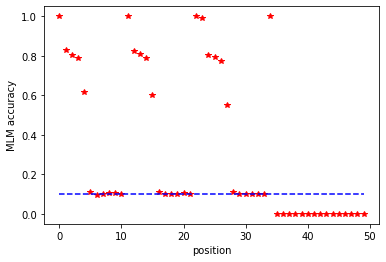

Epoch: 305 Pretraining Perplexity: 4.0794 Validation accuracy: 0.4941 Validation ppl: 3.6786 lr: 0.0005958958006116948


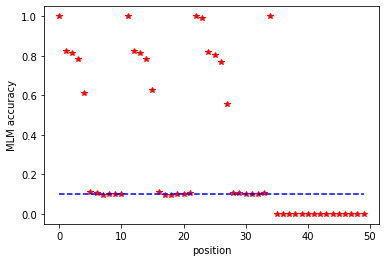

Epoch: 306 Pretraining Perplexity: 4.0651 Validation accuracy: 0.4856 Validation ppl: 3.7254 lr: 0.0005968252926508398


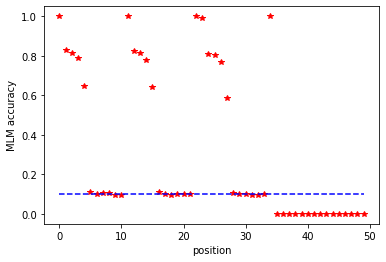

Epoch: 307 Pretraining Perplexity: 4.0500 Validation accuracy: 0.4734 Validation ppl: 3.8354 lr: 0.0005976361513022662


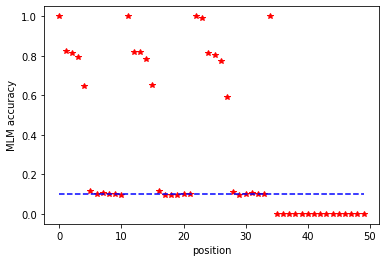

Epoch: 308 Pretraining Perplexity: 4.0419 Validation accuracy: 0.4845 Validation ppl: 3.8331 lr: 0.0005983280524867559


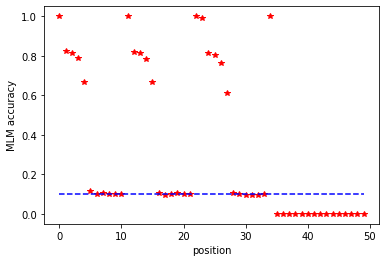

Epoch: 309 Pretraining Perplexity: 4.0462 Validation accuracy: 0.4587 Validation ppl: 4.0608 lr: 0.0005989007196693116


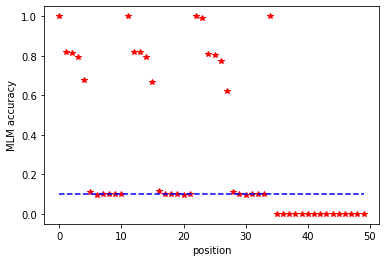

Epoch: 310 Pretraining Perplexity: 4.0110 Validation accuracy: 0.4700 Validation ppl: 3.9019 lr: 0.000599353923969681


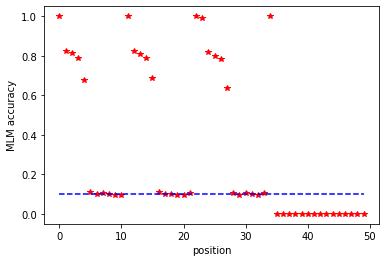

Epoch: 311 Pretraining Perplexity: 4.0117 Validation accuracy: 0.4714 Validation ppl: 3.8985 lr: 0.0005996874842538338


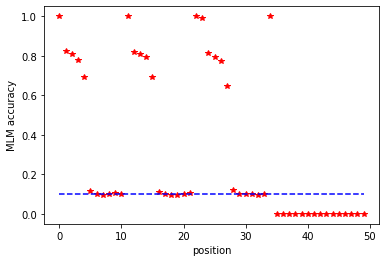

Epoch: 312 Pretraining Perplexity: 4.0184 Validation accuracy: 0.4757 Validation ppl: 3.7833 lr: 0.000599901267206357


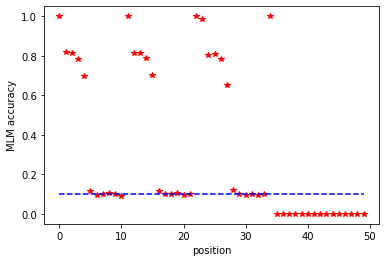

Epoch: 313 Pretraining Perplexity: 4.0017 Validation accuracy: 0.4652 Validation ppl: 3.9021 lr: 0.0005999951873837372


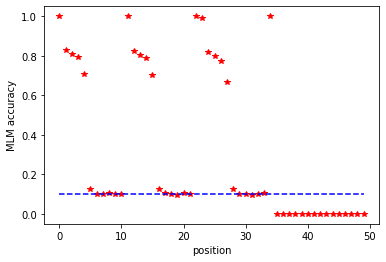

Epoch: 314 Pretraining Perplexity: 3.9925 Validation accuracy: 0.4856 Validation ppl: 3.7521 lr: 0.0005999692072485101


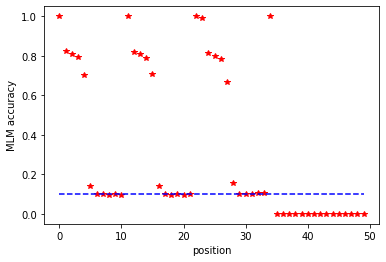

Epoch: 315 Pretraining Perplexity: 3.9971 Validation accuracy: 0.4610 Validation ppl: 3.9308 lr: 0.0005998233371842633


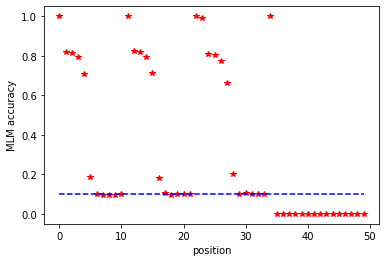

Epoch: 316 Pretraining Perplexity: 3.9517 Validation accuracy: 0.4867 Validation ppl: 3.8638 lr: 0.0005995576354914865


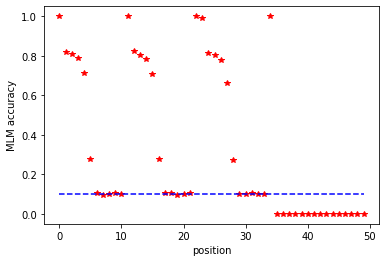

Epoch: 317 Pretraining Perplexity: 3.8754 Validation accuracy: 0.5080 Validation ppl: 3.5256 lr: 0.0005991722083642698


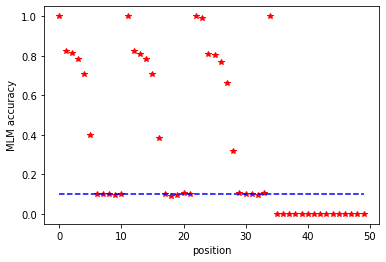

Epoch: 318 Pretraining Perplexity: 3.7782 Validation accuracy: 0.5220 Validation ppl: 3.4326 lr: 0.0005986672098478615


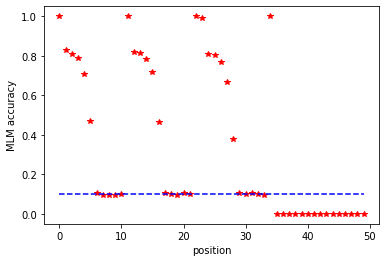

Epoch: 319 Pretraining Perplexity: 3.6983 Validation accuracy: 0.5458 Validation ppl: 3.2057 lr: 0.0005980428417770993


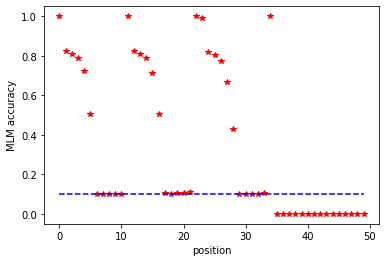

Epoch: 320 Pretraining Perplexity: 3.6548 Validation accuracy: 0.5292 Validation ppl: 3.4323 lr: 0.0005972993536957425


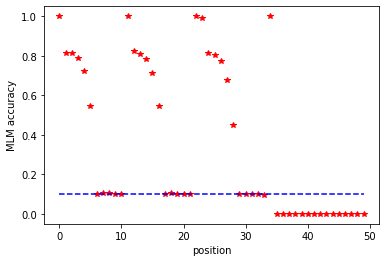

Epoch: 321 Pretraining Perplexity: 3.6247 Validation accuracy: 0.5494 Validation ppl: 3.2357 lr: 0.0005964370427567362


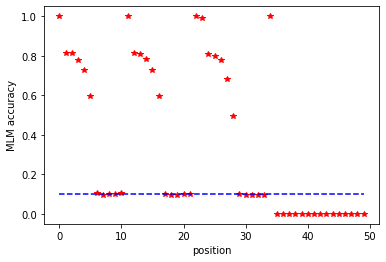

Epoch: 322 Pretraining Perplexity: 3.5859 Validation accuracy: 0.5369 Validation ppl: 3.2151 lr: 0.000595456253603446


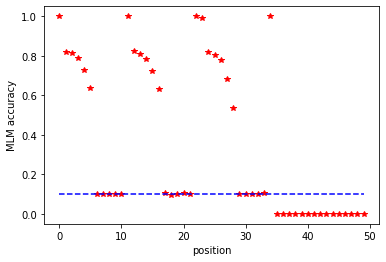

Epoch: 323 Pretraining Perplexity: 3.5492 Validation accuracy: 0.5154 Validation ppl: 3.3715 lr: 0.0005943573782319143


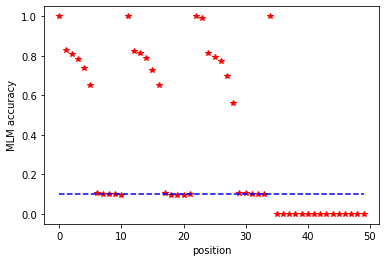

Epoch: 324 Pretraining Perplexity: 3.5441 Validation accuracy: 0.5200 Validation ppl: 3.3845 lr: 0.0005931408558341883


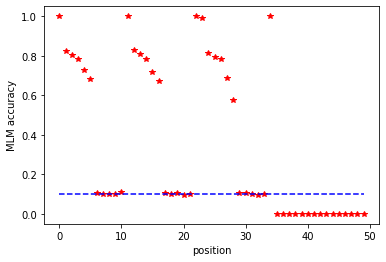

Epoch: 325 Pretraining Perplexity: 3.5308 Validation accuracy: 0.5374 Validation ppl: 3.1972 lr: 0.0005918071726227871


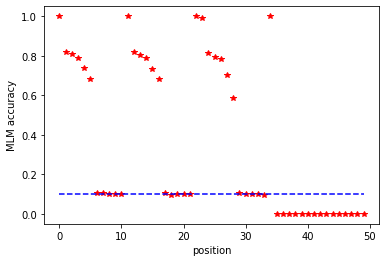

Epoch: 326 Pretraining Perplexity: 3.5103 Validation accuracy: 0.5607 Validation ppl: 3.1367 lr: 0.0005903568616363751


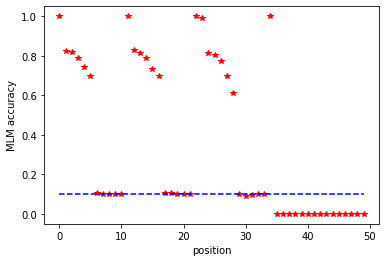

Epoch: 327 Pretraining Perplexity: 3.4904 Validation accuracy: 0.5394 Validation ppl: 3.2476 lr: 0.0005887905025267198


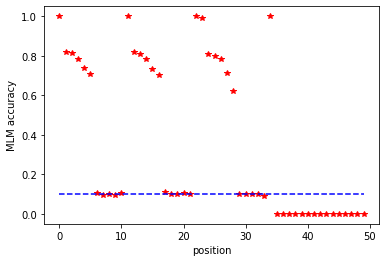

Epoch: 328 Pretraining Perplexity: 3.4875 Validation accuracy: 0.5531 Validation ppl: 3.1857 lr: 0.0005871087213270205


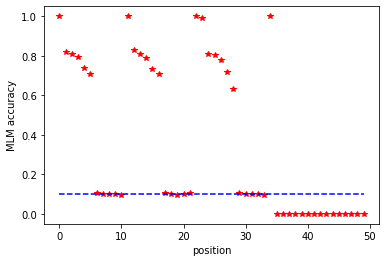

Epoch: 329 Pretraining Perplexity: 3.4790 Validation accuracy: 0.5285 Validation ppl: 3.3798 lr: 0.0005853121902016987


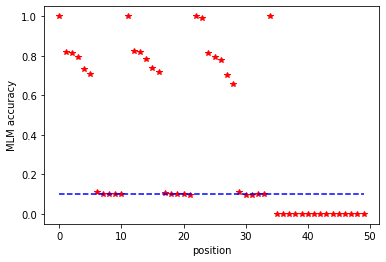

Epoch: 330 Pretraining Perplexity: 3.4855 Validation accuracy: 0.5348 Validation ppl: 3.2930 lr: 0.0005834016271777513


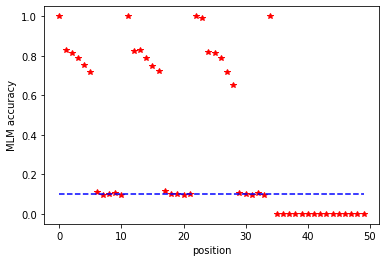

Epoch: 331 Pretraining Perplexity: 3.4577 Validation accuracy: 0.5321 Validation ppl: 3.3085 lr: 0.0005813777958577744


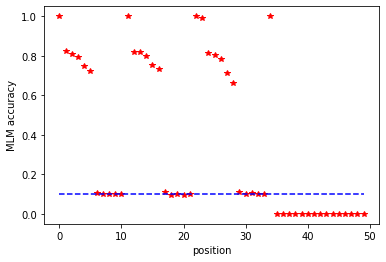

Epoch: 332 Pretraining Perplexity: 3.4504 Validation accuracy: 0.5714 Validation ppl: 3.0513 lr: 0.0005792415051147703


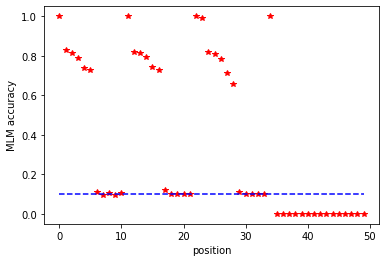

Epoch: 333 Pretraining Perplexity: 3.4506 Validation accuracy: 0.5141 Validation ppl: 3.4093 lr: 0.0005769936087688624


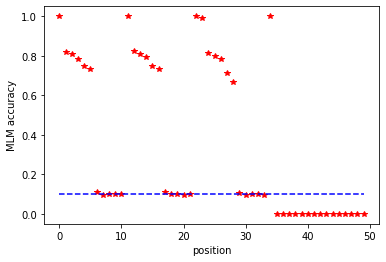

Epoch: 334 Pretraining Perplexity: 3.4548 Validation accuracy: 0.5304 Validation ppl: 3.3596 lr: 0.0005746350052460451


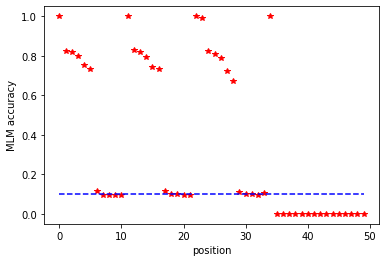

Epoch: 335 Pretraining Perplexity: 3.4338 Validation accuracy: 0.5347 Validation ppl: 3.3043 lr: 0.0005721666372191068


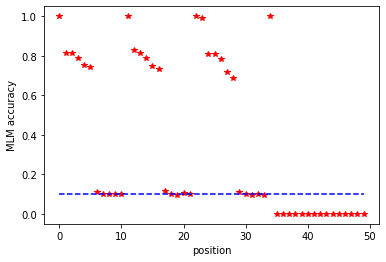

Epoch: 336 Pretraining Perplexity: 3.4407 Validation accuracy: 0.5371 Validation ppl: 3.3293 lr: 0.0005695894912308668


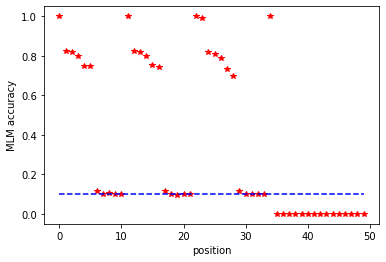

Epoch: 337 Pretraining Perplexity: 3.4077 Validation accuracy: 0.5318 Validation ppl: 3.2666 lr: 0.000566904597299881


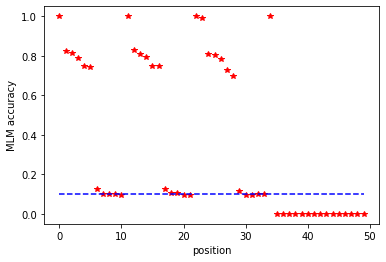

Epoch: 338 Pretraining Perplexity: 3.4300 Validation accuracy: 0.5560 Validation ppl: 3.1189 lr: 0.0005641130285087697


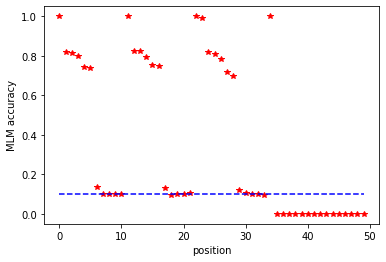

Epoch: 339 Pretraining Perplexity: 3.4207 Validation accuracy: 0.5412 Validation ppl: 3.3013 lr: 0.000561215900575333


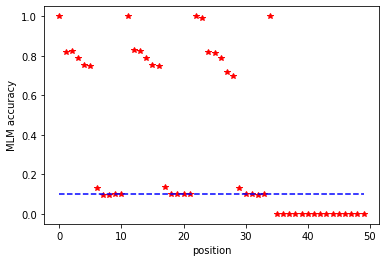

Epoch: 340 Pretraining Perplexity: 3.4076 Validation accuracy: 0.5390 Validation ppl: 3.1494 lr: 0.0005582143714066295


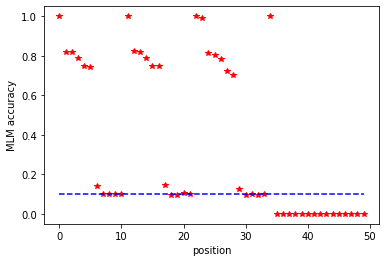

Epoch: 341 Pretraining Perplexity: 3.4063 Validation accuracy: 0.5377 Validation ppl: 3.3576 lr: 0.000555109640636189


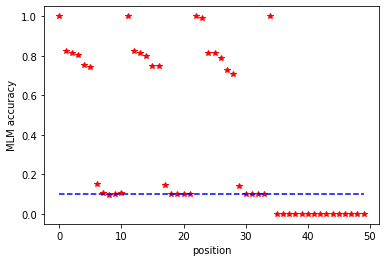

Epoch: 342 Pretraining Perplexity: 3.3857 Validation accuracy: 0.5562 Validation ppl: 3.1729 lr: 0.0005519029491445512


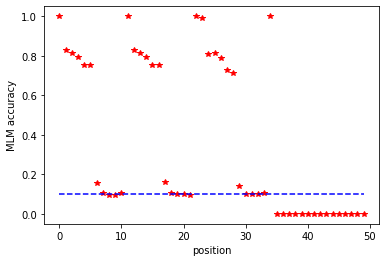

Epoch: 343 Pretraining Perplexity: 3.3876 Validation accuracy: 0.5578 Validation ppl: 3.2146 lr: 0.0005485955785633165


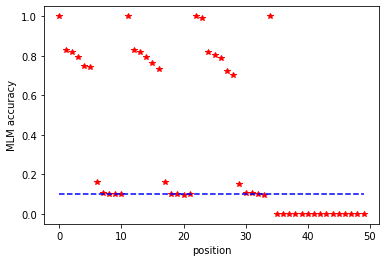

Epoch: 344 Pretraining Perplexity: 3.3820 Validation accuracy: 0.5656 Validation ppl: 3.0497 lr: 0.0005451888507629132


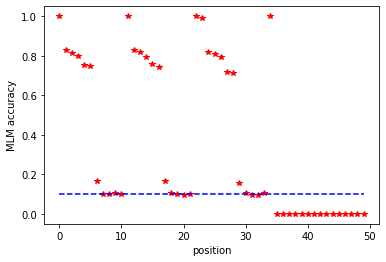

Epoch: 345 Pretraining Perplexity: 3.3786 Validation accuracy: 0.5327 Validation ppl: 3.2175 lr: 0.0005416841273242772


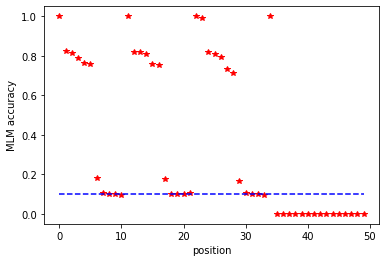

Epoch: 346 Pretraining Perplexity: 3.3586 Validation accuracy: 0.5579 Validation ppl: 3.1616 lr: 0.0005380828089946663


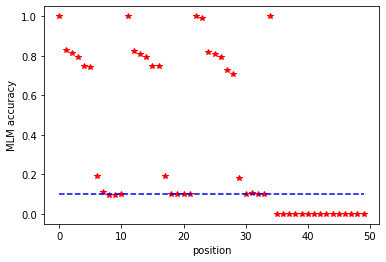

Epoch: 347 Pretraining Perplexity: 3.3572 Validation accuracy: 0.5504 Validation ppl: 3.1630 lr: 0.0005343863351278151


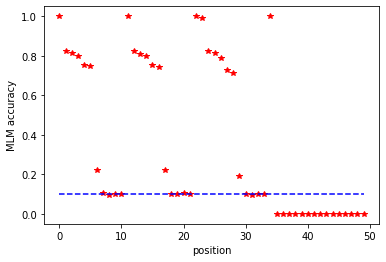

Epoch: 348 Pretraining Perplexity: 3.3416 Validation accuracy: 0.5506 Validation ppl: 3.1447 lr: 0.0005305961831086652


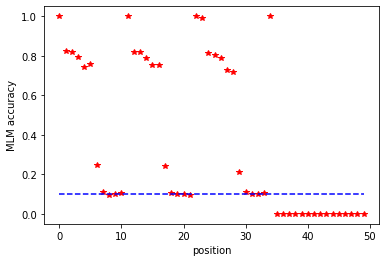

Epoch: 349 Pretraining Perplexity: 3.3238 Validation accuracy: 0.5409 Validation ppl: 3.2720 lr: 0.0005267138677628899


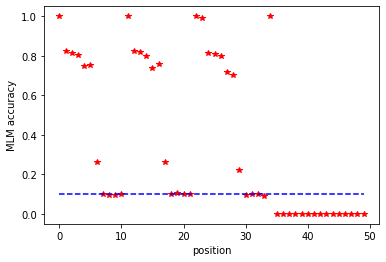

Epoch: 350 Pretraining Perplexity: 3.3180 Validation accuracy: 0.5685 Validation ppl: 3.1208 lr: 0.0005227409407514605


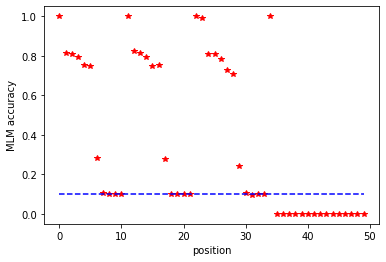

Epoch: 351 Pretraining Perplexity: 3.2992 Validation accuracy: 0.5589 Validation ppl: 3.0713 lr: 0.0005186789899504844


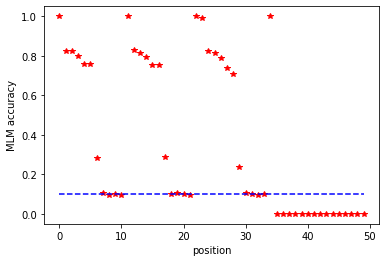

Epoch: 352 Pretraining Perplexity: 3.2888 Validation accuracy: 0.5599 Validation ppl: 3.0776 lr: 0.0005145296388165754


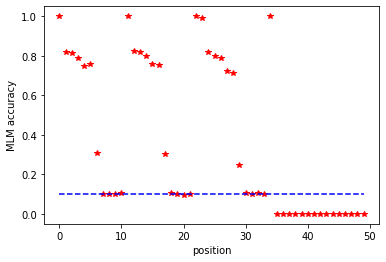

Epoch: 353 Pretraining Perplexity: 3.2743 Validation accuracy: 0.5687 Validation ppl: 3.0368 lr: 0.0005102945457379969


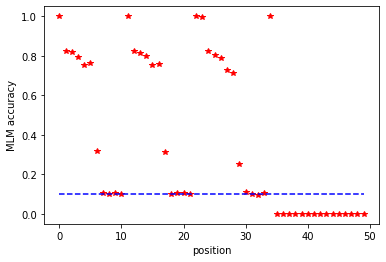

Epoch: 354 Pretraining Perplexity: 3.2721 Validation accuracy: 0.5429 Validation ppl: 3.2287 lr: 0.0005059754033718499


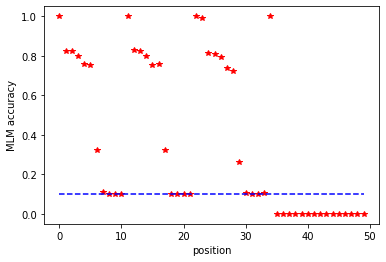

Epoch: 355 Pretraining Perplexity: 3.2534 Validation accuracy: 0.5725 Validation ppl: 3.0879 lr: 0.00050157393796756


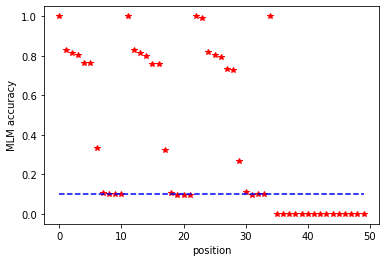

Epoch: 356 Pretraining Perplexity: 3.2432 Validation accuracy: 0.5507 Validation ppl: 3.0988 lr: 0.0004970919086769405


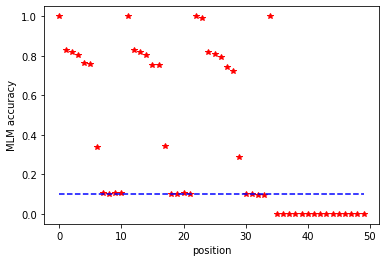

Epoch: 357 Pretraining Perplexity: 3.2247 Validation accuracy: 0.5792 Validation ppl: 2.9254 lr: 0.0004925311068511056


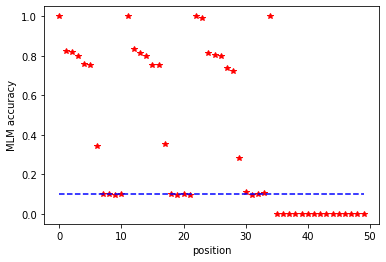

Epoch: 358 Pretraining Perplexity: 3.2300 Validation accuracy: 0.5600 Validation ppl: 3.0795 lr: 0.00048789335532451193


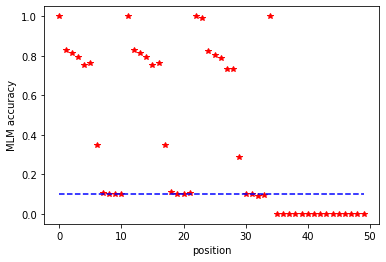

Epoch: 359 Pretraining Perplexity: 3.2192 Validation accuracy: 0.5671 Validation ppl: 3.0745 lr: 0.00048318050768642203


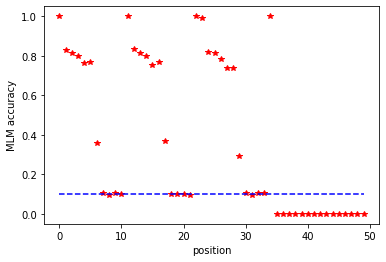

Epoch: 360 Pretraining Perplexity: 3.1981 Validation accuracy: 0.5978 Validation ppl: 2.8706 lr: 0.0004783944475400686


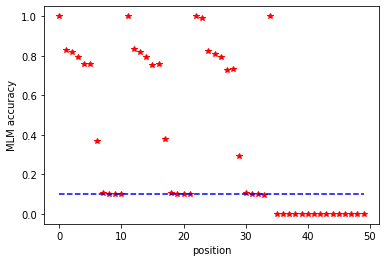

Epoch: 361 Pretraining Perplexity: 3.1947 Validation accuracy: 0.5794 Validation ppl: 2.9260 lr: 0.00047353708774983144


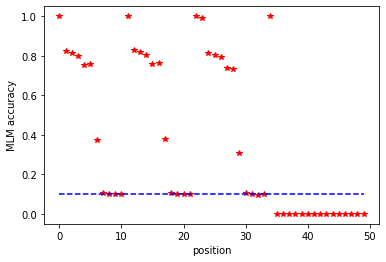

Epoch: 362 Pretraining Perplexity: 3.1986 Validation accuracy: 0.5676 Validation ppl: 3.0315 lr: 0.0004686103696767106


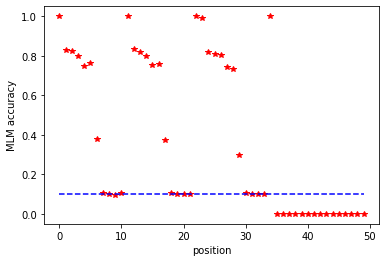

Epoch: 363 Pretraining Perplexity: 3.1988 Validation accuracy: 0.5891 Validation ppl: 2.8237 lr: 0.0004636162624024186


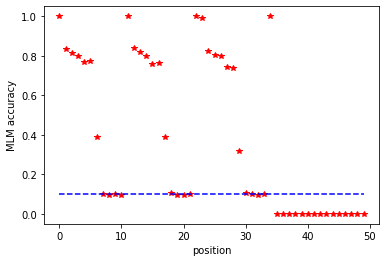

Epoch: 364 Pretraining Perplexity: 3.1815 Validation accuracy: 0.5467 Validation ppl: 3.1965 lr: 0.0004585567619423863


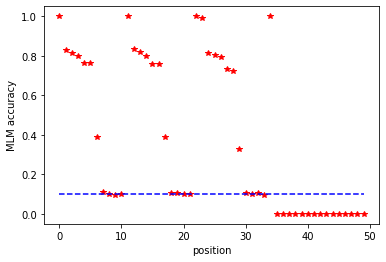

Epoch: 365 Pretraining Perplexity: 3.1808 Validation accuracy: 0.5700 Validation ppl: 2.9425 lr: 0.0004534338904480098


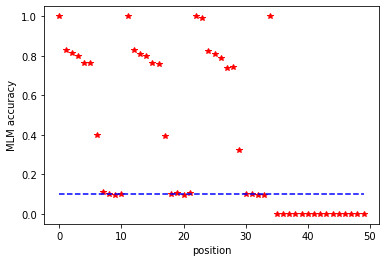

Epoch: 366 Pretraining Perplexity: 3.1858 Validation accuracy: 0.5722 Validation ppl: 2.9628 lr: 0.0004482496953984461


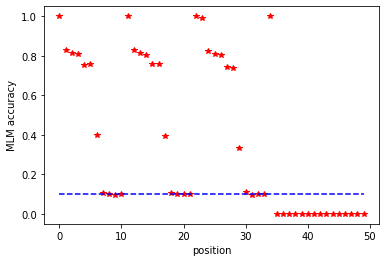

Epoch: 367 Pretraining Perplexity: 3.1731 Validation accuracy: 0.5707 Validation ppl: 2.9506 lr: 0.000443006248782292


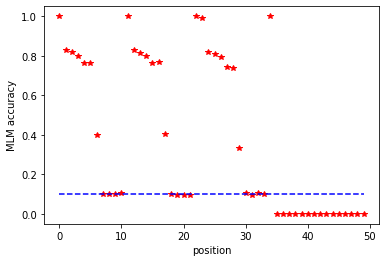

Epoch: 368 Pretraining Perplexity: 3.1668 Validation accuracy: 0.5596 Validation ppl: 3.0297 lr: 0.0004377056462694601


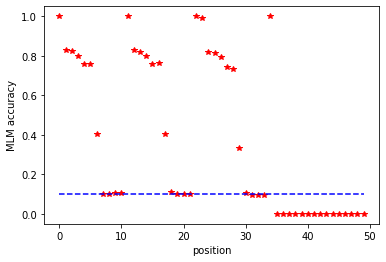

Epoch: 369 Pretraining Perplexity: 3.1613 Validation accuracy: 0.5751 Validation ppl: 2.9719 lr: 0.0004323500063735977


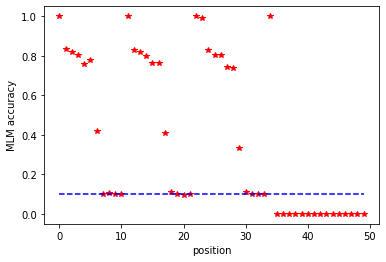

Epoch: 370 Pretraining Perplexity: 3.1633 Validation accuracy: 0.5791 Validation ppl: 2.9643 lr: 0.00042694146960536763


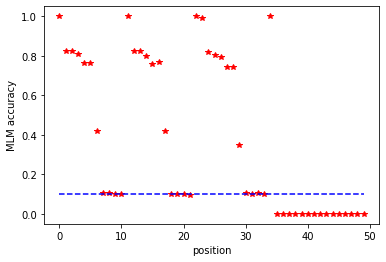

Epoch: 371 Pretraining Perplexity: 3.1545 Validation accuracy: 0.5843 Validation ppl: 2.8787 lr: 0.0004214821976169459


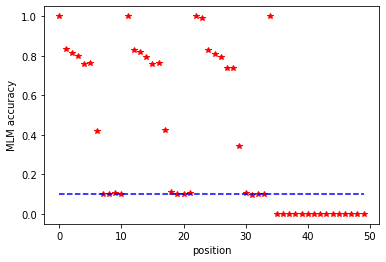

Epoch: 372 Pretraining Perplexity: 3.1479 Validation accuracy: 0.5773 Validation ppl: 2.9245 lr: 0.0004159743723380609


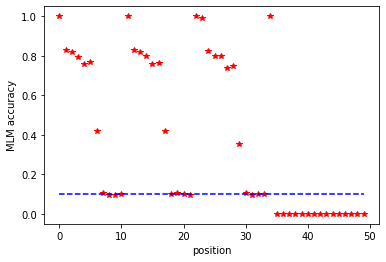

Epoch: 373 Pretraining Perplexity: 3.1527 Validation accuracy: 0.5763 Validation ppl: 3.0030 lr: 0.00041042019510393614


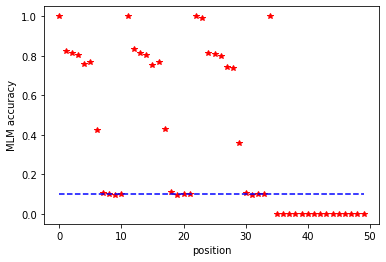

Epoch: 374 Pretraining Perplexity: 3.1449 Validation accuracy: 0.5745 Validation ppl: 2.8831 lr: 0.00040482188577547167


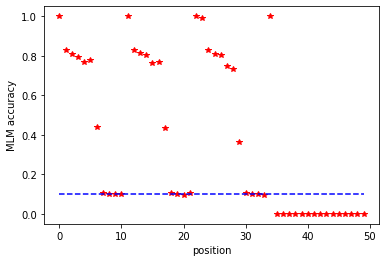

Epoch: 375 Pretraining Perplexity: 3.1433 Validation accuracy: 0.5691 Validation ppl: 3.0560 lr: 0.0003991816818520232


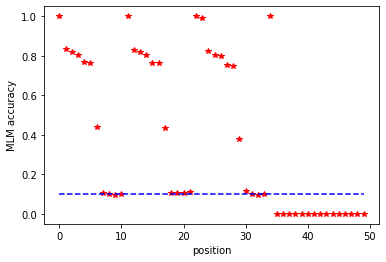

Epoch: 376 Pretraining Perplexity: 3.1320 Validation accuracy: 0.5786 Validation ppl: 2.8999 lr: 0.00039350183757713237


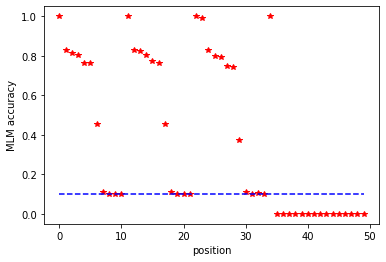

Epoch: 377 Pretraining Perplexity: 3.1300 Validation accuracy: 0.5661 Validation ppl: 2.9933 lr: 0.0003877846230375624


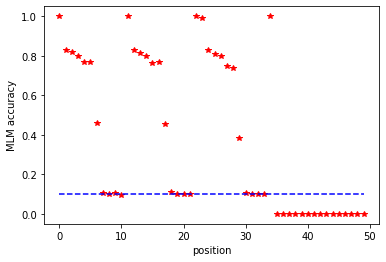

Epoch: 378 Pretraining Perplexity: 3.1251 Validation accuracy: 0.5780 Validation ppl: 2.9300 lr: 0.0003820323232560058


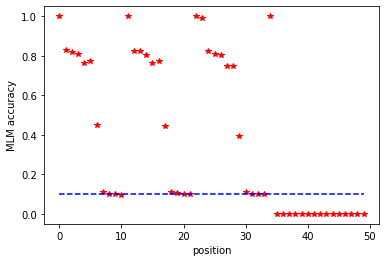

Epoch: 379 Pretraining Perplexity: 3.1278 Validation accuracy: 0.5890 Validation ppl: 2.9094 lr: 0.00037624723727781645


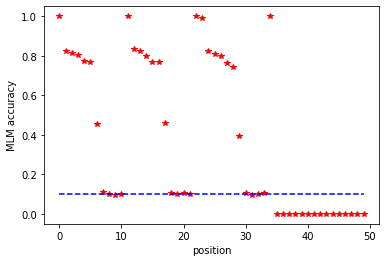

Epoch: 380 Pretraining Perplexity: 3.1104 Validation accuracy: 0.5717 Validation ppl: 2.9822 lr: 0.00037043167725214445


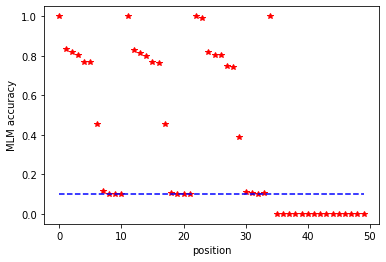

Epoch: 381 Pretraining Perplexity: 3.1186 Validation accuracy: 0.5828 Validation ppl: 2.8778 lr: 0.00036458796750782596


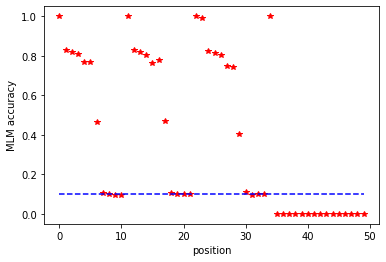

Epoch: 382 Pretraining Perplexity: 3.1083 Validation accuracy: 0.5793 Validation ppl: 2.9399 lr: 0.0003587184436244133


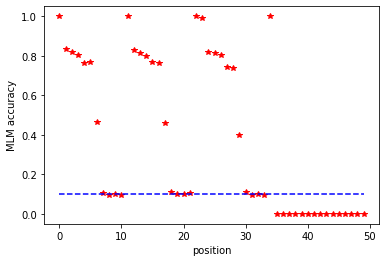

Epoch: 383 Pretraining Perplexity: 3.1038 Validation accuracy: 0.5615 Validation ppl: 3.0592 lr: 0.0003528254514987


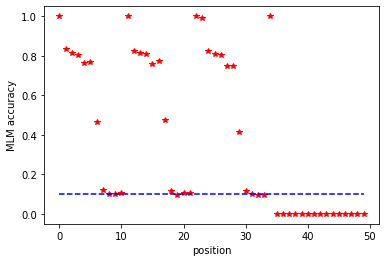

Epoch: 384 Pretraining Perplexity: 3.1044 Validation accuracy: 0.5891 Validation ppl: 2.8363 lr: 0.00034691134640713083


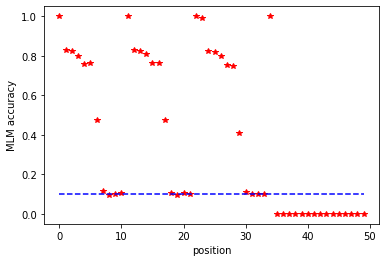

Epoch: 385 Pretraining Perplexity: 3.1059 Validation accuracy: 0.5990 Validation ppl: 2.8155 lr: 0.0003409784920644545


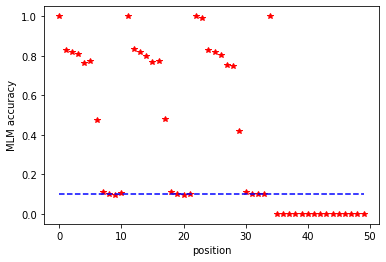

Epoch: 386 Pretraining Perplexity: 3.0851 Validation accuracy: 0.5775 Validation ppl: 2.9360 lr: 0.00033502912256533487


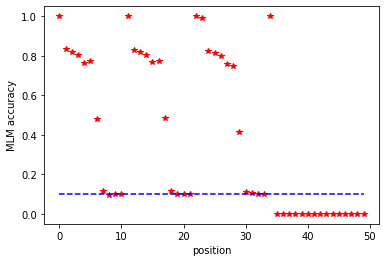

Epoch: 387 Pretraining Perplexity: 3.0957 Validation accuracy: 0.5592 Validation ppl: 2.9813 lr: 0.0003290657521879499


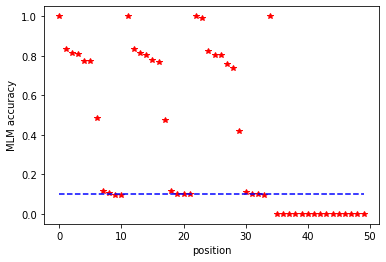

Epoch: 388 Pretraining Perplexity: 3.0950 Validation accuracy: 0.5897 Validation ppl: 2.8601 lr: 0.0003230907644468329


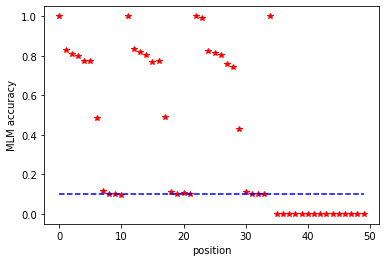

Epoch: 389 Pretraining Perplexity: 3.0768 Validation accuracy: 0.5809 Validation ppl: 2.9546 lr: 0.00031710654749988906


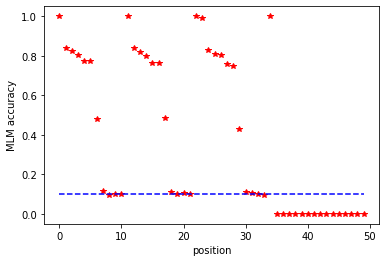

Epoch: 390 Pretraining Perplexity: 3.0847 Validation accuracy: 0.5725 Validation ppl: 3.0109 lr: 0.00031111549319387


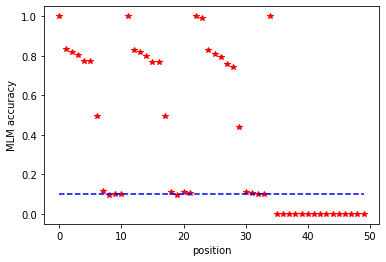

Epoch: 391 Pretraining Perplexity: 3.0716 Validation accuracy: 0.6044 Validation ppl: 2.6869 lr: 0.00030511999610836747


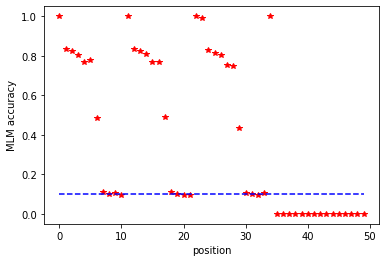

Epoch: 392 Pretraining Perplexity: 3.0759 Validation accuracy: 0.5647 Validation ppl: 2.9375 lr: 0.000299122452598719


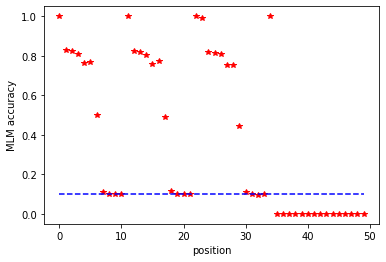

Epoch: 393 Pretraining Perplexity: 3.0753 Validation accuracy: 0.5821 Validation ppl: 2.9287 lr: 0.00029312525983820226


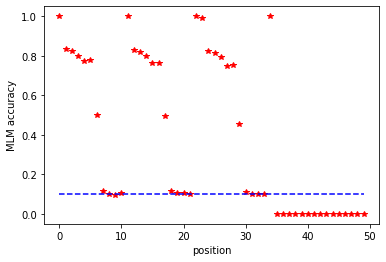

Epoch: 394 Pretraining Perplexity: 3.0751 Validation accuracy: 0.6010 Validation ppl: 2.8122 lr: 0.0002871308148599042


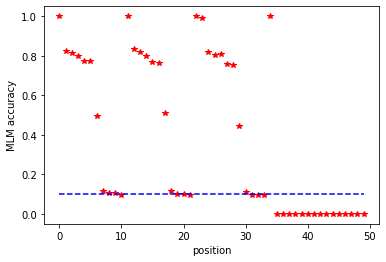

Epoch: 395 Pretraining Perplexity: 3.0834 Validation accuracy: 0.5932 Validation ppl: 2.9003 lr: 0.0002811415135986422


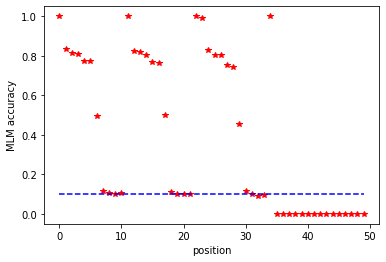

Epoch: 396 Pretraining Perplexity: 3.0753 Validation accuracy: 0.5887 Validation ppl: 2.8977 lr: 0.0002751597499333302


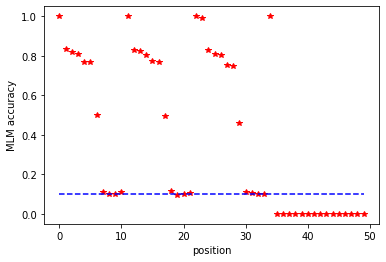

Epoch: 397 Pretraining Perplexity: 3.0620 Validation accuracy: 0.5726 Validation ppl: 2.9058 lr: 0.00026918791473016043


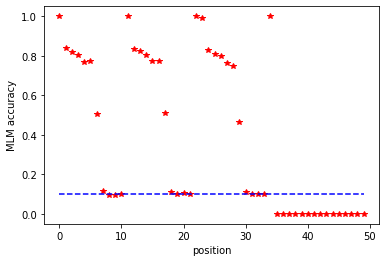

Epoch: 398 Pretraining Perplexity: 3.0602 Validation accuracy: 0.5827 Validation ppl: 2.9211 lr: 0.00026322839488699263


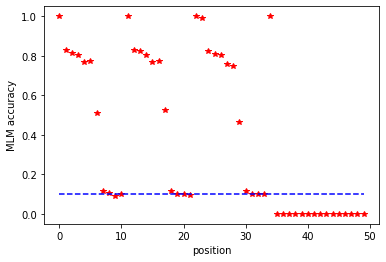

Epoch: 399 Pretraining Perplexity: 3.0574 Validation accuracy: 0.5714 Validation ppl: 3.0353 lr: 0.0002572835723793304


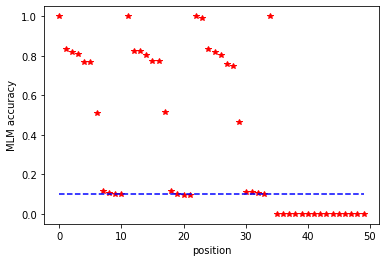

Epoch: 400 Pretraining Perplexity: 3.0581 Validation accuracy: 0.5803 Validation ppl: 2.9382 lr: 0.0002513558233082612


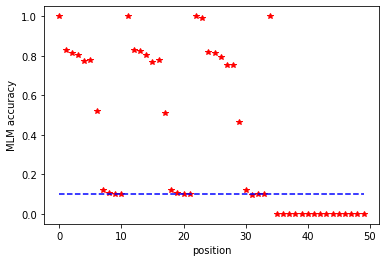

Epoch: 401 Pretraining Perplexity: 3.0617 Validation accuracy: 0.5982 Validation ppl: 2.8393 lr: 0.0002454475169507479


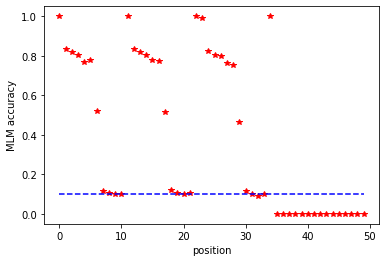

Epoch: 402 Pretraining Perplexity: 3.0531 Validation accuracy: 0.5748 Validation ppl: 2.9398 lr: 0.00023956101481264743


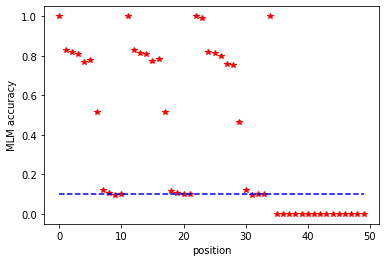

Epoch: 403 Pretraining Perplexity: 3.0571 Validation accuracy: 0.5809 Validation ppl: 2.8279 lr: 0.00023369866968483153


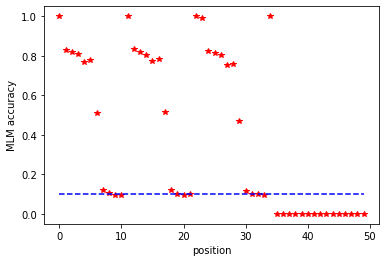

Epoch: 404 Pretraining Perplexity: 3.0560 Validation accuracy: 0.5859 Validation ppl: 2.9142 lr: 0.00022786282470279646


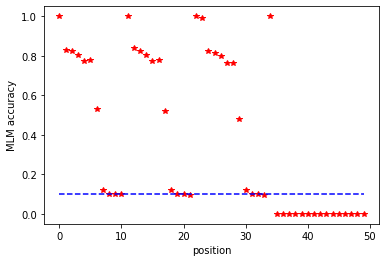

Epoch: 405 Pretraining Perplexity: 3.0375 Validation accuracy: 0.6013 Validation ppl: 2.7885 lr: 0.00022205581241012778


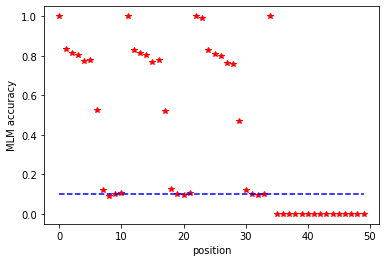

Epoch: 406 Pretraining Perplexity: 3.0510 Validation accuracy: 0.5788 Validation ppl: 2.9197 lr: 0.00021627995382620193


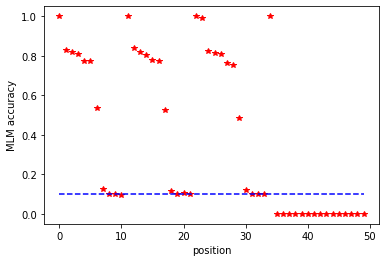

Epoch: 407 Pretraining Perplexity: 3.0282 Validation accuracy: 0.6098 Validation ppl: 2.7228 lr: 0.00021053755751849085


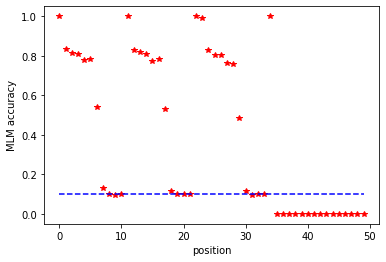

Epoch: 408 Pretraining Perplexity: 3.0366 Validation accuracy: 0.5759 Validation ppl: 2.9371 lr: 0.00020483091867984414


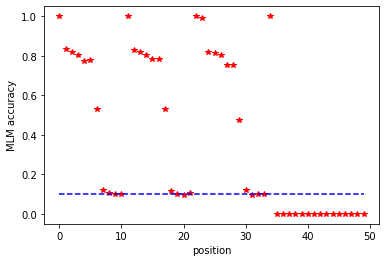

Epoch: 409 Pretraining Perplexity: 3.0262 Validation accuracy: 0.5759 Validation ppl: 2.9207 lr: 0.00019916231821111877


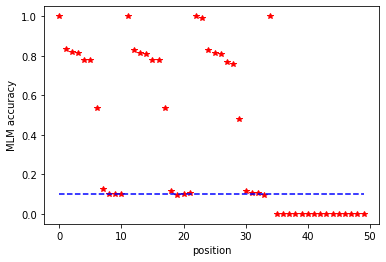

Epoch: 410 Pretraining Perplexity: 3.0207 Validation accuracy: 0.5861 Validation ppl: 2.7986 lr: 0.00019353402180952


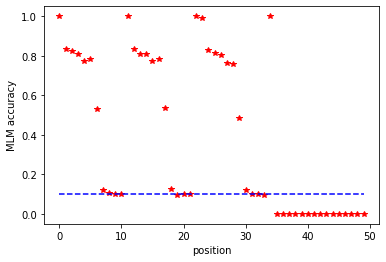

Epoch: 411 Pretraining Perplexity: 3.0277 Validation accuracy: 0.5890 Validation ppl: 2.8288 lr: 0.00018794827906301834


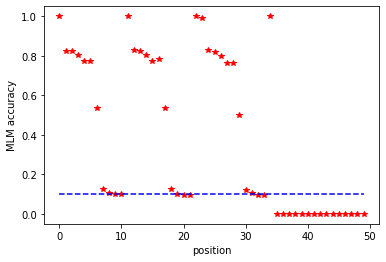

Epoch: 412 Pretraining Perplexity: 3.0241 Validation accuracy: 0.5671 Validation ppl: 2.9456 lr: 0.00018240732255120774


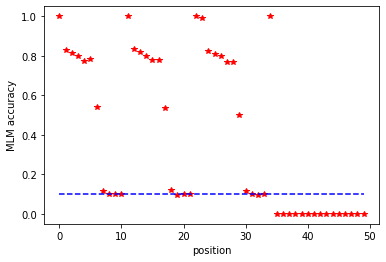

Epoch: 413 Pretraining Perplexity: 3.0306 Validation accuracy: 0.5697 Validation ppl: 2.9096 lr: 0.00017691336695295896


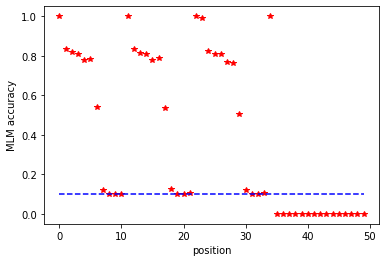

Epoch: 414 Pretraining Perplexity: 3.0295 Validation accuracy: 0.6080 Validation ppl: 2.7767 lr: 0.0001714686081612284


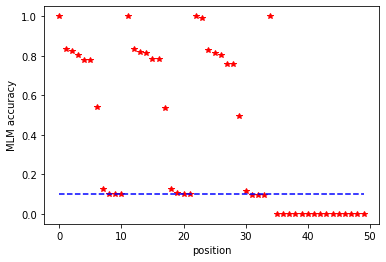

Epoch: 415 Pretraining Perplexity: 3.0242 Validation accuracy: 0.6007 Validation ppl: 2.7741 lr: 0.0001660752224053773


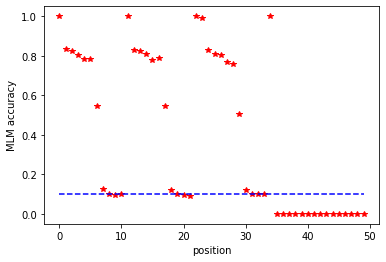

Epoch: 416 Pretraining Perplexity: 3.0167 Validation accuracy: 0.5826 Validation ppl: 2.8591 lr: 0.00016073536538134832


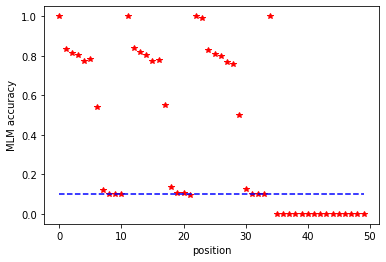

Epoch: 417 Pretraining Perplexity: 3.0270 Validation accuracy: 0.5958 Validation ppl: 2.8320 lr: 0.00015545117139005175


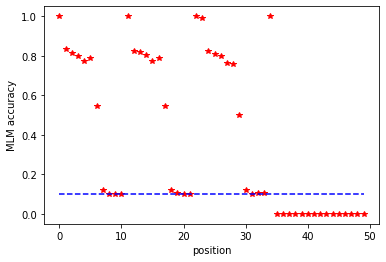

Epoch: 418 Pretraining Perplexity: 3.0368 Validation accuracy: 0.5909 Validation ppl: 2.8858 lr: 0.00015022475248429825


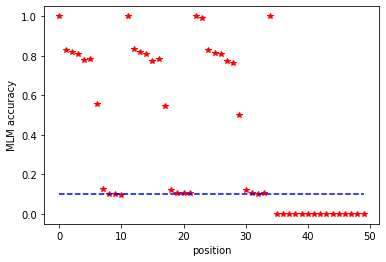

Epoch: 419 Pretraining Perplexity: 3.0072 Validation accuracy: 0.5646 Validation ppl: 3.0249 lr: 0.0001450581976246308


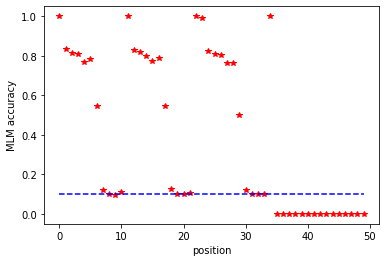

Epoch: 420 Pretraining Perplexity: 3.0174 Validation accuracy: 0.5760 Validation ppl: 3.0053 lr: 0.00013995357184437955


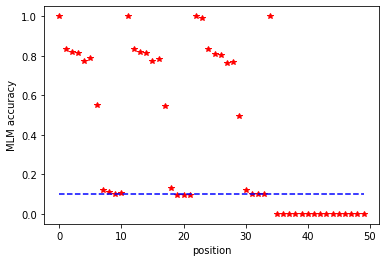

Epoch: 421 Pretraining Perplexity: 3.0127 Validation accuracy: 0.5826 Validation ppl: 2.8788 lr: 0.00013491291542428534


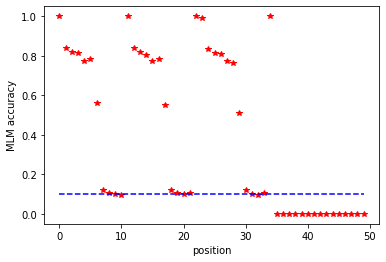

Epoch: 422 Pretraining Perplexity: 3.0133 Validation accuracy: 0.5905 Validation ppl: 2.9104 lr: 0.0001299382430770138


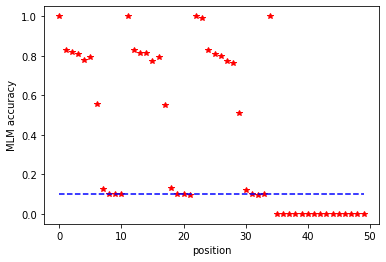

Epoch: 423 Pretraining Perplexity: 3.0064 Validation accuracy: 0.6146 Validation ppl: 2.7427 lr: 0.00012503154314189155


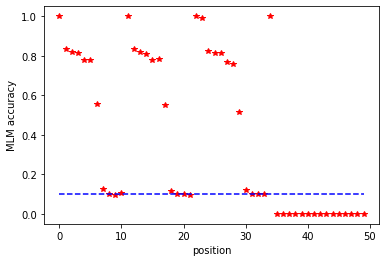

Epoch: 424 Pretraining Perplexity: 3.0077 Validation accuracy: 0.5870 Validation ppl: 2.8834 lr: 0.00012019477679017875


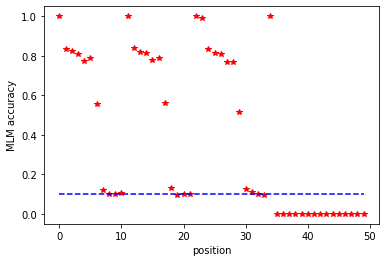

Epoch: 425 Pretraining Perplexity: 3.0035 Validation accuracy: 0.5968 Validation ppl: 2.7879 lr: 0.00011542987724120717


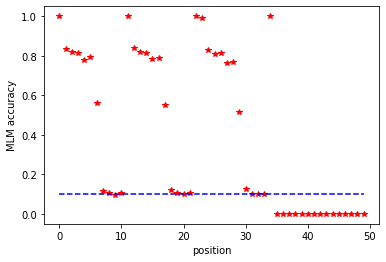

Epoch: 426 Pretraining Perplexity: 3.0041 Validation accuracy: 0.5905 Validation ppl: 2.8056 lr: 0.00011073874898968377


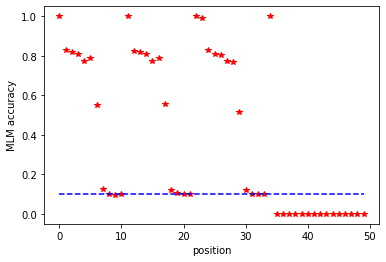

Epoch: 427 Pretraining Perplexity: 3.0006 Validation accuracy: 0.6079 Validation ppl: 2.6988 lr: 0.00010612326704448017


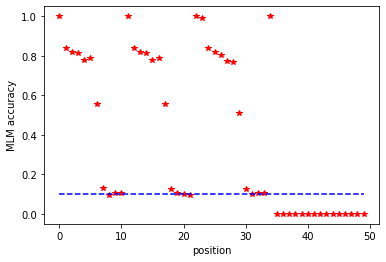

Epoch: 428 Pretraining Perplexity: 2.9969 Validation accuracy: 0.6059 Validation ppl: 2.7683 lr: 0.0001015852761792048


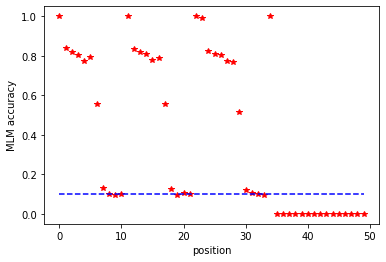

Epoch: 429 Pretraining Perplexity: 3.0003 Validation accuracy: 0.5907 Validation ppl: 2.8138 lr: 9.712659019486191e-05


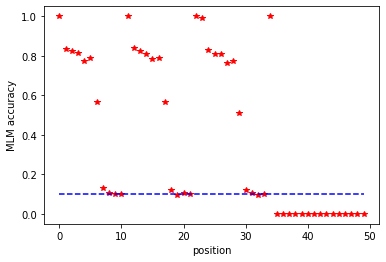

Epoch: 430 Pretraining Perplexity: 3.0004 Validation accuracy: 0.5847 Validation ppl: 2.8933 lr: 9.274899119488809e-05


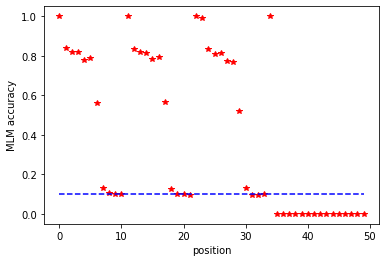

Epoch: 431 Pretraining Perplexity: 2.9882 Validation accuracy: 0.5711 Validation ppl: 3.0220 lr: 8.84542288728579e-05


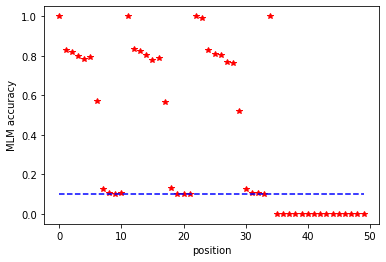

Epoch: 432 Pretraining Perplexity: 2.9953 Validation accuracy: 0.6064 Validation ppl: 2.7899 lr: 8.424401981314593e-05


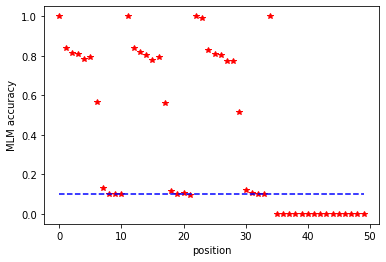

Epoch: 433 Pretraining Perplexity: 2.9999 Validation accuracy: 0.5916 Validation ppl: 2.8373 lr: 8.012004680481978e-05


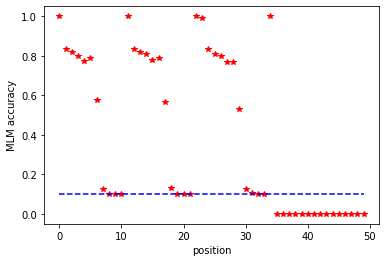

Epoch: 434 Pretraining Perplexity: 2.9927 Validation accuracy: 0.5620 Validation ppl: 3.0119 lr: 7.608395816904356e-05


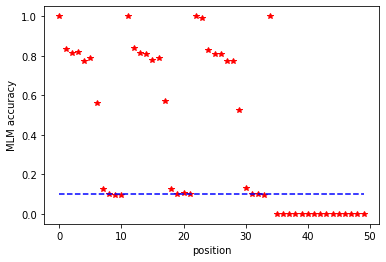

Epoch: 435 Pretraining Perplexity: 2.9889 Validation accuracy: 0.5817 Validation ppl: 2.9784 lr: 7.213736710025359e-05


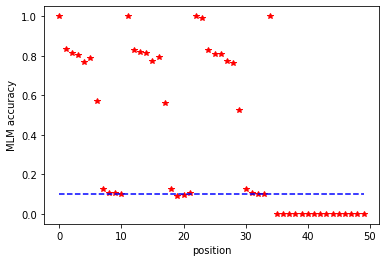

Epoch: 436 Pretraining Perplexity: 2.9971 Validation accuracy: 0.5909 Validation ppl: 2.8489 lr: 6.828185102137954e-05


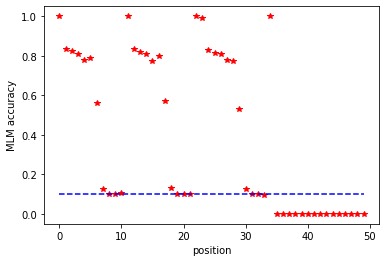

Epoch: 437 Pretraining Perplexity: 2.9915 Validation accuracy: 0.5794 Validation ppl: 2.9698 lr: 6.451895095335776e-05


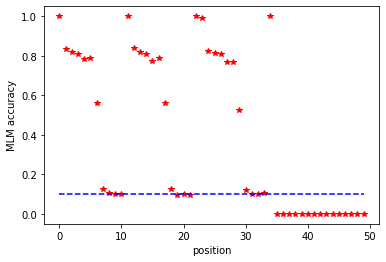

Epoch: 438 Pretraining Perplexity: 2.9899 Validation accuracy: 0.5959 Validation ppl: 2.8557 lr: 6.0850170899198346e-05


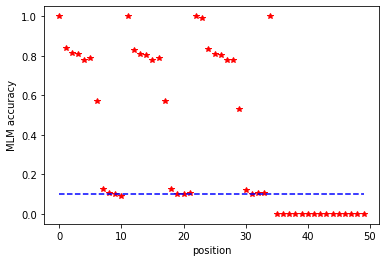

Epoch: 439 Pretraining Perplexity: 2.9940 Validation accuracy: 0.5806 Validation ppl: 2.8521 lr: 5.9999999999999995e-05


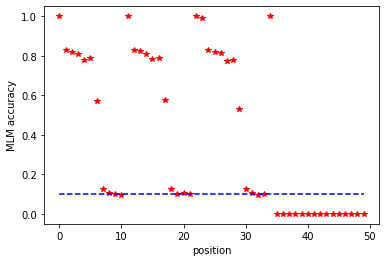

Epoch: 440 Pretraining Perplexity: 2.9853 Validation accuracy: 0.5700 Validation ppl: 2.9336 lr: 5.9999999999999995e-05


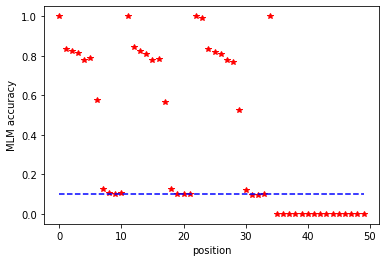

Epoch: 441 Pretraining Perplexity: 2.9886 Validation accuracy: 0.5942 Validation ppl: 2.8074 lr: 5.9999999999999995e-05


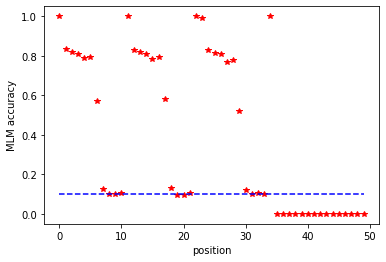

Epoch: 442 Pretraining Perplexity: 2.9833 Validation accuracy: 0.6011 Validation ppl: 2.8158 lr: 5.9999999999999995e-05


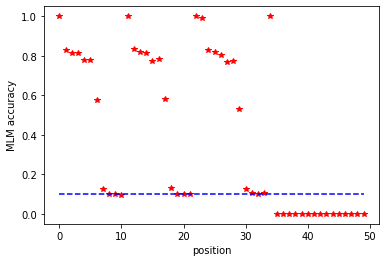

Epoch: 443 Pretraining Perplexity: 2.9942 Validation accuracy: 0.5694 Validation ppl: 2.9440 lr: 5.9999999999999995e-05


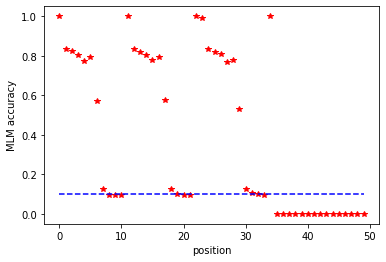

Epoch: 444 Pretraining Perplexity: 2.9864 Validation accuracy: 0.5856 Validation ppl: 2.8148 lr: 5.9999999999999995e-05


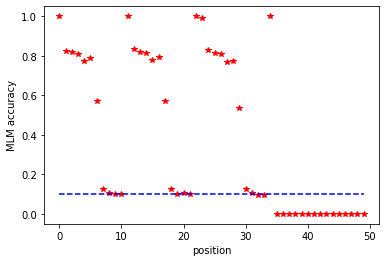

Epoch: 445 Pretraining Perplexity: 3.0016 Validation accuracy: 0.6156 Validation ppl: 2.6441 lr: 5.9999999999999995e-05


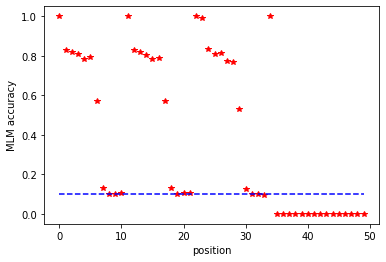

Epoch: 446 Pretraining Perplexity: 2.9845 Validation accuracy: 0.5992 Validation ppl: 2.8208 lr: 5.9999999999999995e-05


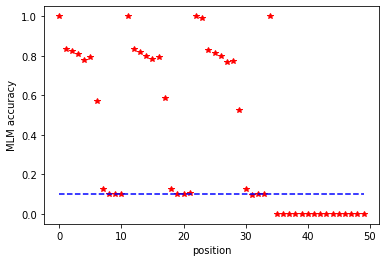

Epoch: 447 Pretraining Perplexity: 2.9832 Validation accuracy: 0.5772 Validation ppl: 2.9081 lr: 5.9999999999999995e-05


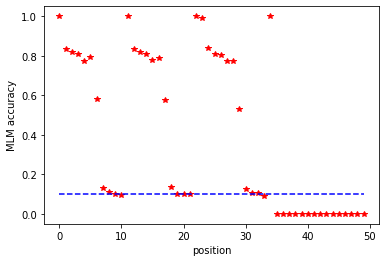

Epoch: 448 Pretraining Perplexity: 2.9867 Validation accuracy: 0.6033 Validation ppl: 2.7132 lr: 5.9999999999999995e-05


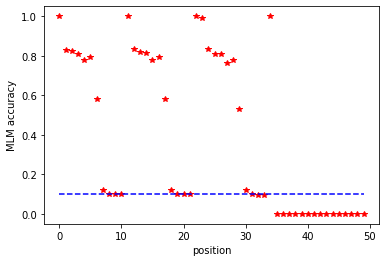

Epoch: 449 Pretraining Perplexity: 2.9820 Validation accuracy: 0.6140 Validation ppl: 2.6591 lr: 5.9999999999999995e-05


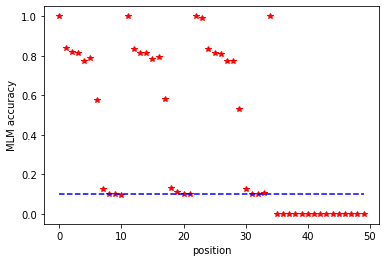

Epoch: 450 Pretraining Perplexity: 2.9799 Validation accuracy: 0.5787 Validation ppl: 2.9058 lr: 5.9999999999999995e-05


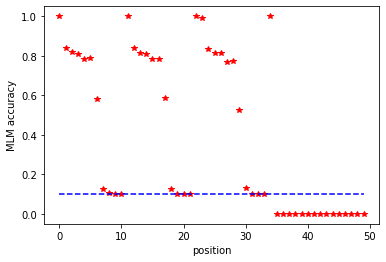

Epoch: 451 Pretraining Perplexity: 2.9889 Validation accuracy: 0.5935 Validation ppl: 2.8138 lr: 5.9999999999999995e-05


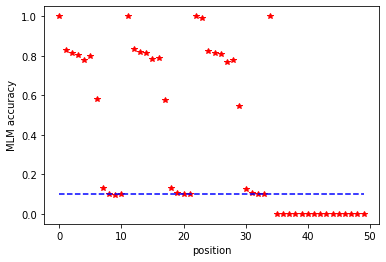

Epoch: 452 Pretraining Perplexity: 2.9818 Validation accuracy: 0.5915 Validation ppl: 2.8698 lr: 5.9999999999999995e-05


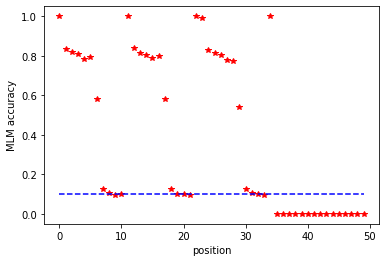

Epoch: 453 Pretraining Perplexity: 2.9796 Validation accuracy: 0.5830 Validation ppl: 2.9319 lr: 5.9999999999999995e-05


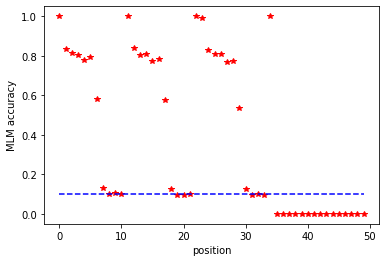

Epoch: 454 Pretraining Perplexity: 2.9916 Validation accuracy: 0.5966 Validation ppl: 2.8397 lr: 5.9999999999999995e-05


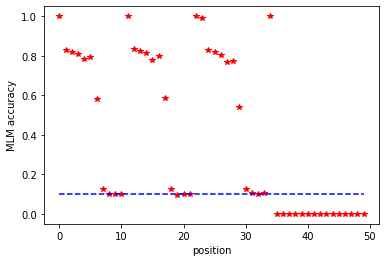

Epoch: 455 Pretraining Perplexity: 2.9784 Validation accuracy: 0.5801 Validation ppl: 2.9162 lr: 5.9999999999999995e-05


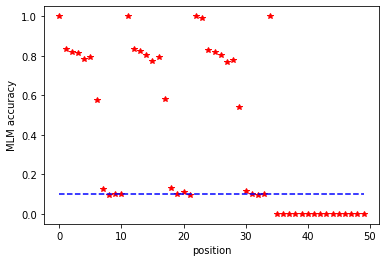

Epoch: 456 Pretraining Perplexity: 2.9714 Validation accuracy: 0.5802 Validation ppl: 2.9374 lr: 5.9999999999999995e-05


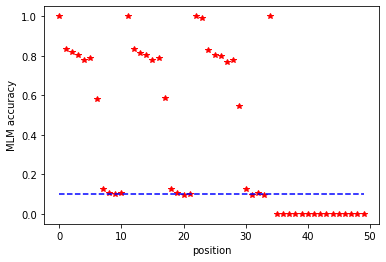

Epoch: 457 Pretraining Perplexity: 2.9823 Validation accuracy: 0.5764 Validation ppl: 3.0357 lr: 5.9999999999999995e-05


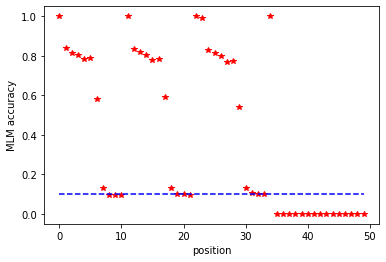

Epoch: 458 Pretraining Perplexity: 2.9836 Validation accuracy: 0.5911 Validation ppl: 2.8124 lr: 5.9999999999999995e-05


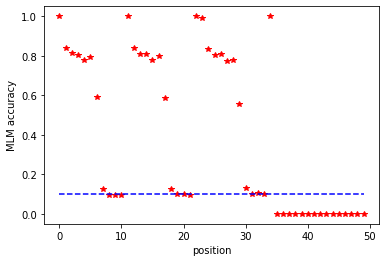

Epoch: 459 Pretraining Perplexity: 2.9736 Validation accuracy: 0.6010 Validation ppl: 2.7599 lr: 5.9999999999999995e-05


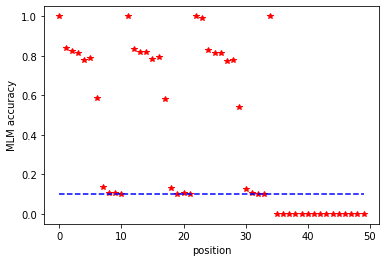

Epoch: 460 Pretraining Perplexity: 2.9741 Validation accuracy: 0.5786 Validation ppl: 2.8894 lr: 5.9999999999999995e-05


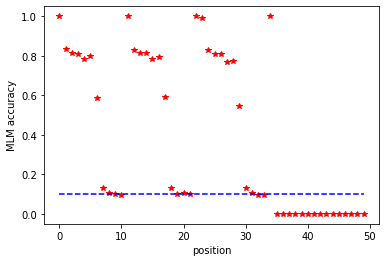

Epoch: 461 Pretraining Perplexity: 2.9800 Validation accuracy: 0.5862 Validation ppl: 2.8500 lr: 5.9999999999999995e-05


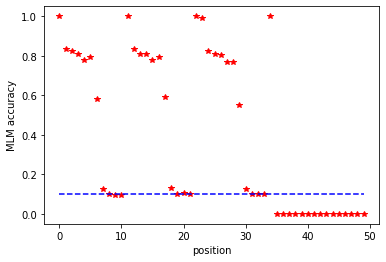

Epoch: 462 Pretraining Perplexity: 2.9854 Validation accuracy: 0.5707 Validation ppl: 2.9870 lr: 5.9999999999999995e-05


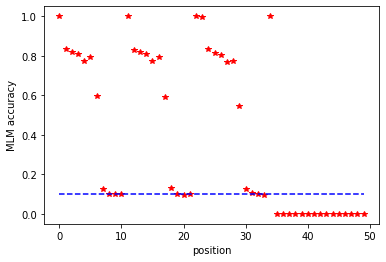

Epoch: 463 Pretraining Perplexity: 2.9772 Validation accuracy: 0.5690 Validation ppl: 2.9800 lr: 5.9999999999999995e-05


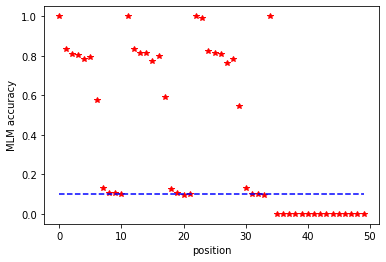

Epoch: 464 Pretraining Perplexity: 2.9826 Validation accuracy: 0.5992 Validation ppl: 2.7745 lr: 5.9999999999999995e-05


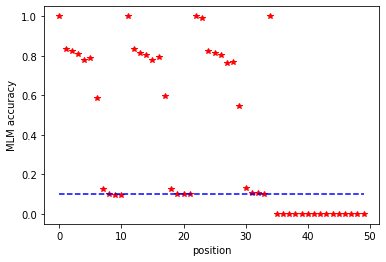

Epoch: 465 Pretraining Perplexity: 2.9739 Validation accuracy: 0.6213 Validation ppl: 2.6962 lr: 5.9999999999999995e-05


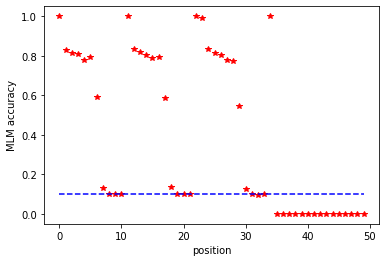

Epoch: 466 Pretraining Perplexity: 2.9743 Validation accuracy: 0.6039 Validation ppl: 2.7423 lr: 5.9999999999999995e-05


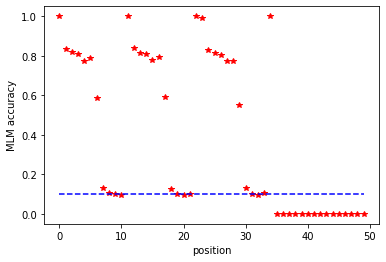

Epoch: 467 Pretraining Perplexity: 2.9737 Validation accuracy: 0.5780 Validation ppl: 2.9308 lr: 5.9999999999999995e-05


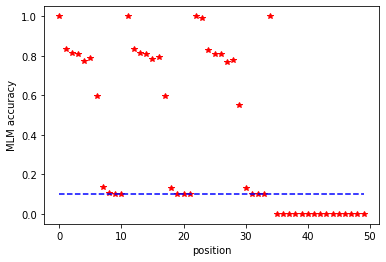

Epoch: 468 Pretraining Perplexity: 2.9741 Validation accuracy: 0.6005 Validation ppl: 2.7859 lr: 5.9999999999999995e-05


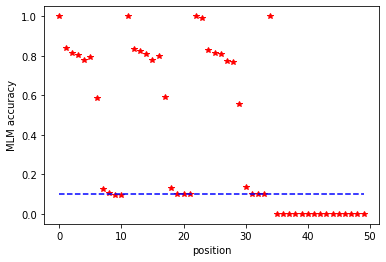

Epoch: 469 Pretraining Perplexity: 2.9731 Validation accuracy: 0.5949 Validation ppl: 2.8088 lr: 5.9999999999999995e-05


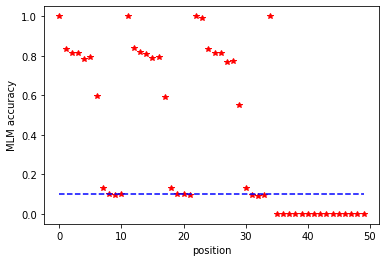

Epoch: 470 Pretraining Perplexity: 2.9706 Validation accuracy: 0.6042 Validation ppl: 2.7615 lr: 5.9999999999999995e-05


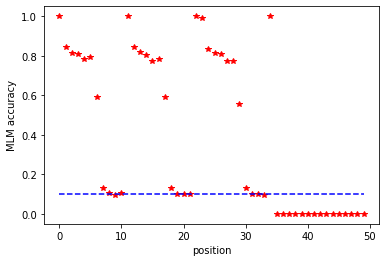

Epoch: 471 Pretraining Perplexity: 2.9780 Validation accuracy: 0.6008 Validation ppl: 2.6912 lr: 5.9999999999999995e-05


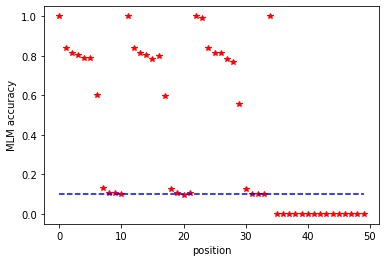

Epoch: 472 Pretraining Perplexity: 2.9652 Validation accuracy: 0.6118 Validation ppl: 2.7604 lr: 5.9999999999999995e-05


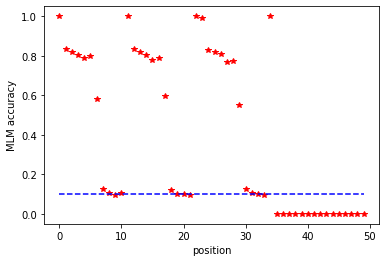

Epoch: 473 Pretraining Perplexity: 2.9658 Validation accuracy: 0.6053 Validation ppl: 2.7668 lr: 5.9999999999999995e-05


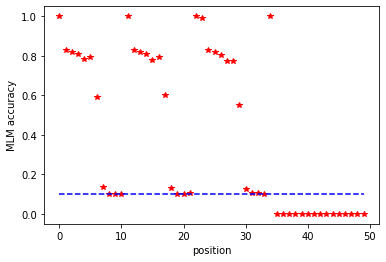

Epoch: 474 Pretraining Perplexity: 2.9687 Validation accuracy: 0.5863 Validation ppl: 2.8375 lr: 5.9999999999999995e-05


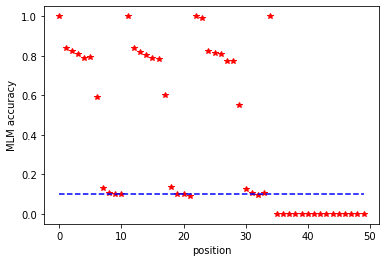

Epoch: 475 Pretraining Perplexity: 2.9681 Validation accuracy: 0.5806 Validation ppl: 2.9256 lr: 5.9999999999999995e-05


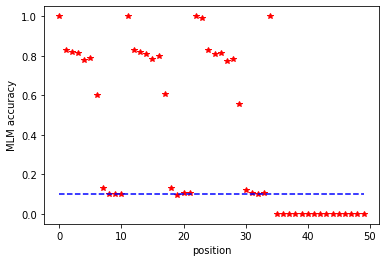

Epoch: 476 Pretraining Perplexity: 2.9649 Validation accuracy: 0.5880 Validation ppl: 2.8522 lr: 5.9999999999999995e-05


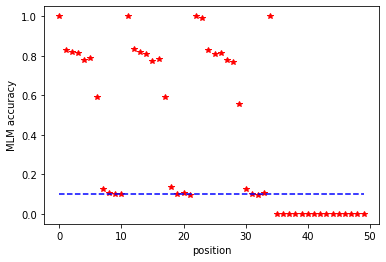

Epoch: 477 Pretraining Perplexity: 2.9663 Validation accuracy: 0.6077 Validation ppl: 2.7496 lr: 5.9999999999999995e-05


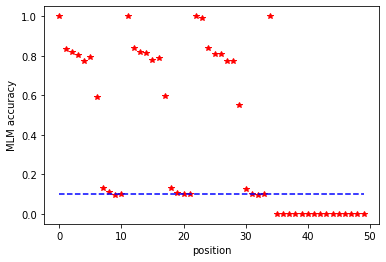

Epoch: 478 Pretraining Perplexity: 2.9614 Validation accuracy: 0.6177 Validation ppl: 2.7034 lr: 5.9999999999999995e-05


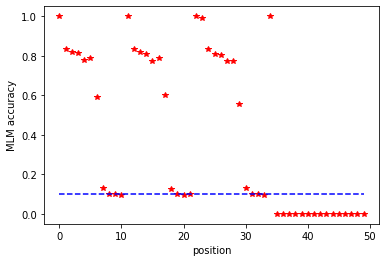

Epoch: 479 Pretraining Perplexity: 2.9775 Validation accuracy: 0.5675 Validation ppl: 3.0323 lr: 5.9999999999999995e-05


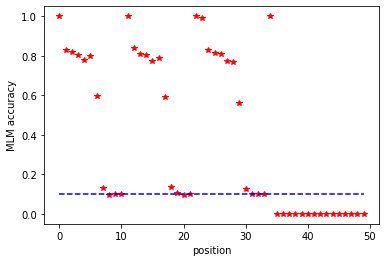

Epoch: 480 Pretraining Perplexity: 2.9685 Validation accuracy: 0.5856 Validation ppl: 2.8562 lr: 5.9999999999999995e-05


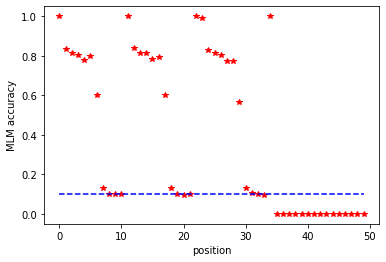

Epoch: 481 Pretraining Perplexity: 2.9753 Validation accuracy: 0.6017 Validation ppl: 2.7086 lr: 5.9999999999999995e-05


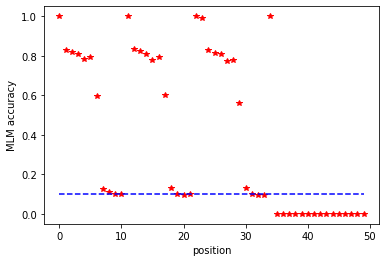

Epoch: 482 Pretraining Perplexity: 2.9685 Validation accuracy: 0.5806 Validation ppl: 2.8798 lr: 5.9999999999999995e-05


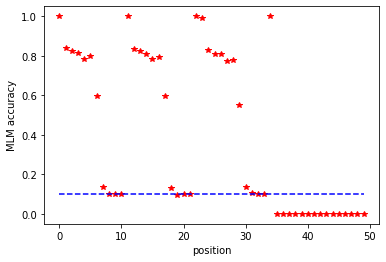

Epoch: 483 Pretraining Perplexity: 2.9603 Validation accuracy: 0.5854 Validation ppl: 2.8004 lr: 5.9999999999999995e-05


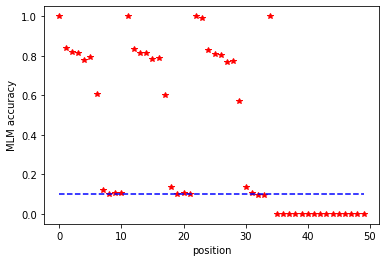

Epoch: 484 Pretraining Perplexity: 2.9750 Validation accuracy: 0.5880 Validation ppl: 2.9006 lr: 5.9999999999999995e-05


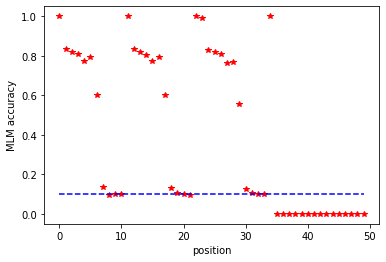

Epoch: 485 Pretraining Perplexity: 2.9666 Validation accuracy: 0.6102 Validation ppl: 2.6629 lr: 5.9999999999999995e-05


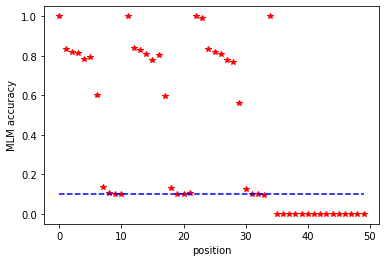

Epoch: 486 Pretraining Perplexity: 2.9558 Validation accuracy: 0.5974 Validation ppl: 2.7873 lr: 5.9999999999999995e-05


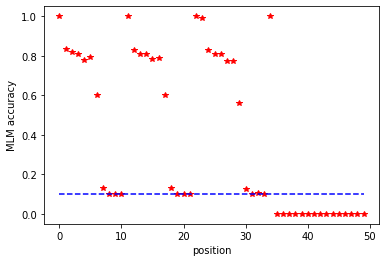

Epoch: 487 Pretraining Perplexity: 2.9659 Validation accuracy: 0.5926 Validation ppl: 2.7913 lr: 5.9999999999999995e-05


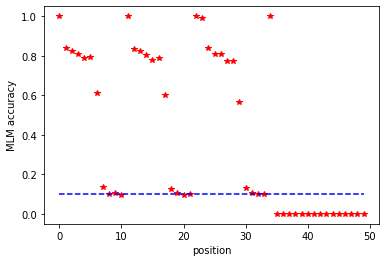

Epoch: 488 Pretraining Perplexity: 2.9595 Validation accuracy: 0.5792 Validation ppl: 2.8716 lr: 5.9999999999999995e-05


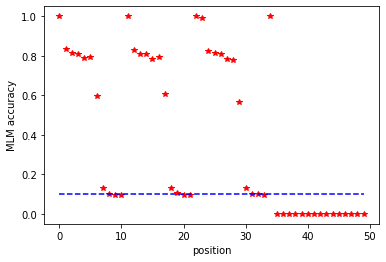

Epoch: 489 Pretraining Perplexity: 2.9598 Validation accuracy: 0.5718 Validation ppl: 2.9545 lr: 5.9999999999999995e-05


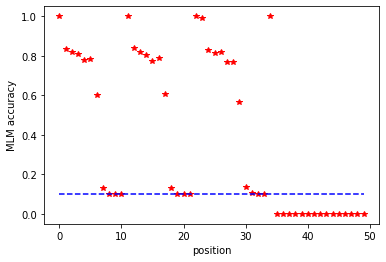

Epoch: 490 Pretraining Perplexity: 2.9657 Validation accuracy: 0.5756 Validation ppl: 2.8863 lr: 5.9999999999999995e-05


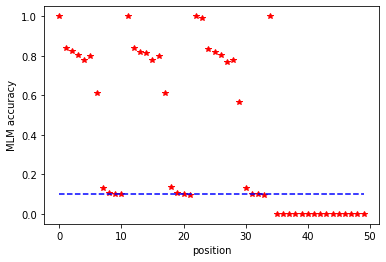

Epoch: 491 Pretraining Perplexity: 2.9575 Validation accuracy: 0.5701 Validation ppl: 2.9194 lr: 5.9999999999999995e-05


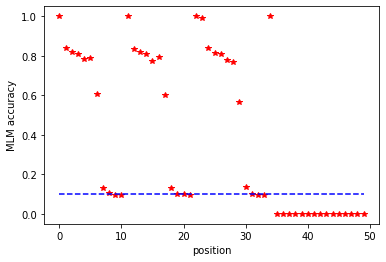

Epoch: 492 Pretraining Perplexity: 2.9597 Validation accuracy: 0.5455 Validation ppl: 3.1648 lr: 5.9999999999999995e-05


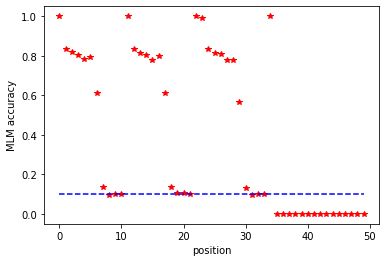

Epoch: 493 Pretraining Perplexity: 2.9580 Validation accuracy: 0.5927 Validation ppl: 2.7656 lr: 5.9999999999999995e-05


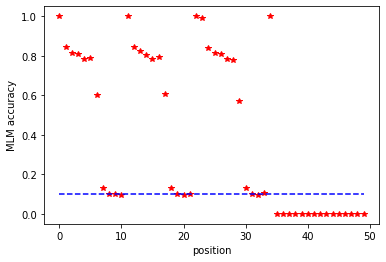

Epoch: 494 Pretraining Perplexity: 2.9594 Validation accuracy: 0.5888 Validation ppl: 2.8087 lr: 5.9999999999999995e-05


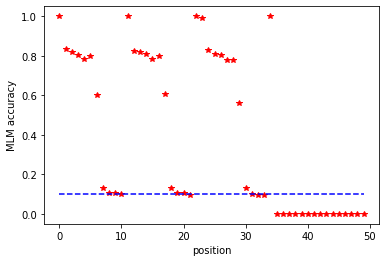

Epoch: 495 Pretraining Perplexity: 2.9534 Validation accuracy: 0.5749 Validation ppl: 2.8657 lr: 5.9999999999999995e-05


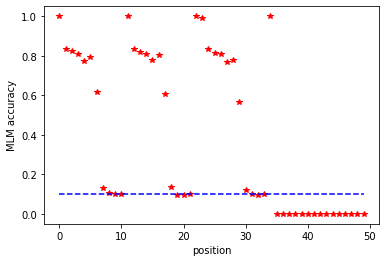

Epoch: 496 Pretraining Perplexity: 2.9501 Validation accuracy: 0.5835 Validation ppl: 2.9197 lr: 5.9999999999999995e-05


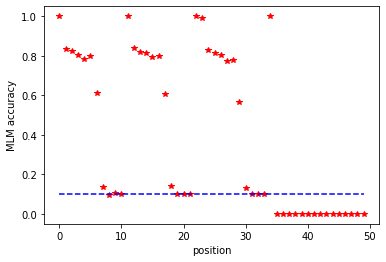

Epoch: 497 Pretraining Perplexity: 2.9412 Validation accuracy: 0.5952 Validation ppl: 2.8109 lr: 5.9999999999999995e-05


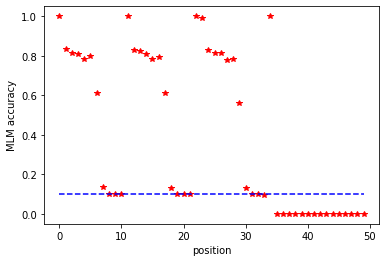

Epoch: 498 Pretraining Perplexity: 2.9494 Validation accuracy: 0.5752 Validation ppl: 2.9202 lr: 5.9999999999999995e-05


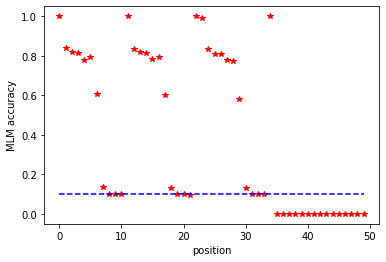

Epoch: 499 Pretraining Perplexity: 2.9537 Validation accuracy: 0.5738 Validation ppl: 2.9304 lr: 5.9999999999999995e-05


In [ ]:
# OPTIONAL, you can skip this cell at the cost of performance
# This cell might take more than 30 minutes!
pretrained_path = 'discriminator_pretrained.pt'

# Instantiate a discriminator
discriminator_pretrain = Discriminator(
  text_field = TEXT, 
  hidden_size= 128, 
  layers     = 2, 
  heads      = 4
).to(device)

if not RETRAIN_PRETRAIN:
  if not os.path.exists(pretrained_path):
    print ('has to pretrain because checkpoint does not exist!')

if RETRAIN_PRETRAIN or (not os.path.exists(pretrained_path)):
  EPOCHS = 500
  LEARNING_RATE = 6e-4
  ACCUMULATE = 10

  discriminator_pretrain.pretrain_all(train_iter, val_iter, epochs=EPOCHS, 
                             learning_rate=LEARNING_RATE, accumulate=ACCUMULATE)
  torch.save(discriminator_pretrain.state_dict(), pretrained_path)
else:
  discriminator_pretrain.load_state_dict(torch.load(pretrained_path))

Now, we train our discriminator. Set `SKIP_PRETRAINING` to `True` or skip running the previous cell if you want to skip pretraining, which is unnecessary for this toy task.

In [ ]:
EPOCHS = 50
LEARNING_RATE = 6e-4
SKIP_PRETRAINING = False # whether skip pretraining of discriminator or not

pretrained_path = 'discriminator_pretrained.pt'

discriminator = Discriminator(
    text_field = TEXT, 
    hidden_size= 128, 
    layers     = 2, 
    heads      = 4
  ).to(device)

if (not SKIP_PRETRAINING) and os.path.exists(pretrained_path):
  print ('Loading a pretrained model')
  discriminator.load_state_dict(discriminator_pretrain.state_dict())
  
discriminator.train_all(train_iter, lmgen_train_iter, val_iter, lmgen_val_iter, 
                        epochs=EPOCHS, learning_rate=LEARNING_RATE)
discriminator.load_state_dict(discriminator.best_model)

Loading a pretrained model
best model sofar
Epoch: 0 Training Perplexity: 1.5039 Validation accuracy: 0.8857 Validation ppl: 1.3608 lr: 0.0005940280539337352
Epoch: 1 Training Perplexity: 1.3520 Validation accuracy: 0.8657 Validation ppl: 1.3747 lr: 0.0005763430990243683
Epoch: 2 Training Perplexity: 1.3118 Validation accuracy: 0.8029 Validation ppl: 1.5366 lr: 0.0005476496390994928
best model sofar
Epoch: 3 Training Perplexity: 1.2887 Validation accuracy: 0.8871 Validation ppl: 1.3250 lr: 0.000509090717349297
best model sofar
Epoch: 4 Training Perplexity: 1.1661 Validation accuracy: 0.9700 Validation ppl: 1.1074 lr: 0.00046220238111847005
best model sofar
Epoch: 5 Training Perplexity: 1.1088 Validation accuracy: 0.9714 Validation ppl: 1.1038 lr: 0.00040885249136097943
best model sofar
Epoch: 6 Training Perplexity: 1.0959 Validation accuracy: 0.9800 Validation ppl: 1.0797 lr: 0.00035116631384624574
best model sofar
Epoch: 7 Training Perplexity: 1.0845 Validation accuracy: 0.9814 Valida

<All keys matched successfully>

A trained discriminator should be able to assign higher scores (or lower energies) to real data, and lower scores (or higher energies) to LM generations. We can visualize the score distribution of real data versus LM generations to make sure that this is the case.

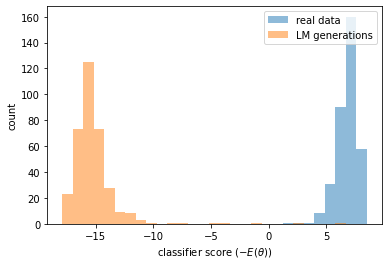

In [ ]:
def get_scores(filename, max_size):
  scores = []
  with open(filename) as fin:
    i = 0
    for l in fin:
      i += 1
      if i > max_size:
        break
      sample = l.strip()
      text = TEXT.process([sample.split()])
      text = text.to(device)
      logits = discriminator.forward(text)
      l = logits[:, 0] - logits[:, 1]
      l = l.item()
      scores.append(l)
  return scores

scores_real = get_scores('data/val.txt', 1000)
scores_fake = get_scores('data/LM_generated/val.txt', 1000)

bins = np.linspace(min(scores_real+scores_fake), max(scores_real+scores_fake), 30)

plt.hist(scores_real, bins, alpha=0.5, label='real data')
plt.hist(scores_fake, bins, alpha=0.5, label='LM generations')
plt.legend(loc='upper right')
plt.xlabel(r'classifier score ($-E(\theta)$)')
plt.ylabel('count')
plt.show()

Now we can put everything together and run Algorithm 1 to generate from our joint model. In the below cell, we vary the number of samples (n in Algorithm 1) and evaluate the per-digit accuracy. We also plot an oracle curve which shows the best achievable accuracy (by selecting the best sample in the sample set) for comparison.

n: 1
n: 5
n: 10
n: 20
7037314759+252538157
n: 40
n: 80


Text(0, 0.5, 'accuracy')

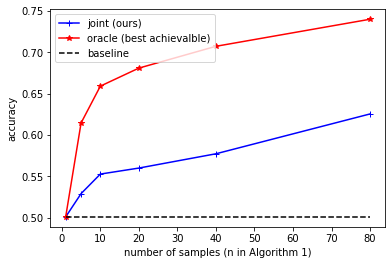

In [ ]:
num_sentences = 100

ns = [1, 5, 10, 20, 40, 80]
oracle_accs = []
joint_accs = []
for n in ns:
  print (f'n: {n}')
  correct = 0
  total = 0
  num_correct_oracle = 0.
  num_correct_joint = 0.
  for i in range(num_sentences):
    sample_set = []
    scores = []
    best_acc = 0.
    for j in range(n):
      sample = generator.predict(1, None)[0]
      best_acc = max(best_acc, num_of_correct(sample)[0])
      sample_set.append(sample)

      text = TEXT.process([sample.split()])
      text = text.to(device)
      
      logits = discriminator.forward(text)
      score = logits[:, 0] - logits[:, 1]
      scores.append(score)
    scores = torch.Tensor(scores)
    scores[scores.ne(scores)] = 0
    probs = torch.softmax(scores, -1)
    probs = probs.numpy()
    probs = probs / probs.sum()
    sample = np.random.choice(sample_set, p=probs)
    num_correct_joint += num_of_correct(sample)[0]

    num_correct_oracle += best_acc
    total += 1
  joint_accs.append(num_correct_joint/total)
  oracle_accs.append(num_correct_oracle/total)

plt.plot(ns, joint_accs, 'b+-', label='joint (ours)')
plt.plot(ns, oracle_accs, 'r*-', label='oracle (best achievalble)')
plt.plot(ns, [joint_accs[0] for _ in ns], 'k--', label='baseline')
plt.legend()
plt.xlabel('number of samples (n in Algorithm 1)')
plt.ylabel('accuracy')

In the above curve, we can see that the accuracy increases as we sample more samples (increase n).